In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

from datetime import timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Load CSV Files
data_dir = Path("../resources/raw_data")

# Load all three files
df_projects = pd.read_csv(data_dir / "dim__projects__anonymized.csv")
df_time_entries = pd.read_csv(data_dir / "fct__time_entries.csv")
df_clients = pd.read_csv(data_dir / "dim__notion_clients__anonymized.csv")
df_deals = pd.read_csv(data_dir / "fct__hubspot_deals__anonymized.csv")
df_hr = pd.read_csv(data_dir / "dim__notion_hr__anonymized.csv")
df_roles_end = pd.read_csv(data_dir / "notion_roles_enddates.csv")
df_roles = pd.read_csv(data_dir / "dim__notion_roles__anonymized.csv")

print(f"✓ Projects loaded: {df_projects.shape}")
print(f"✓ Time entries loaded: {df_time_entries.shape}")
print(f"✓ Clients loaded: {df_clients.shape}")
print(f"✓ Deals loaded: {df_deals.shape}")



✓ Projects loaded: (91, 7)
✓ Time entries loaded: (9808, 7)
✓ Clients loaded: (48, 10)
✓ Deals loaded: (322, 11)


In [4]:
df_roles

role_id                 industry_name  \
0    68fb318f-438b-4257-95f2-3893564ebd01                           NaN   
1    b5a1a16b-99d7-4895-b927-0d0afa074c35                           NaN   
2    264b42da-30b3-8026-b4e1-f6a7c2832cc2                           NaN   
3    0517e8f8-b88c-41fa-ae1a-57458f4571d0                           NaN   
4    347c5d6b-8487-437c-8945-612a32c0b866                           NaN   
..                                    ...                           ...   
96   c90ee650-07ac-4725-a75d-f0b4d5f6b5e6                          Tech   
97   a53e017d-e456-49bd-89b6-fdbeec1b30b4                          Tech   
98   60b9abb5-6ff3-4bcd-be3c-ec6f396305c3                          Tech   
99   38968285-7e0f-4c8b-b473-9cbacd5f0ab4                          Tech   
100  a80d6f1c-0863-48a9-a49c-fc8c7a24896b  Transportation and Logistics   

     role_category_name  hourly_rate                   billing_type seniority  \
0                   NaN          NaN                            NaN        K2   
1                   NaN          NaN                            NaN       NaN   
2          Data Analyst        900.0                         Direct       NaN   
3         Data Engineer       1100.0  Invoicing(Right people Group)       NaN   
4                   NaN       1100.0                            NaN       NaN   
..                  ...          ...                            ...       ...   
96       Data Scientist       1000.0          Self-billing(Tingent)       NaN   
97   Business Developer       1350.0                            NaN        K4   
98   Business Developer       1000.0                 Direct billing       NaN   
99                  NaN       1700.0                 Direct billing        K4   
100       Data Engineer       1200.0                      Self bill       NaN   

      startdate                    name_anon  
0    2023-10-01                          NaN  
1           NaN                          NaN  
2    2025-09-04               Terry and Sons  
3    2022-12-05                 Payne-Nelson  
4    2022-09-11                 Payne-Nelson  
..          ...                          ...  
96   2022-09-01  Richards, Acosta and Mccall  
97   2021-06-21  Richards, Acosta and Mccall  
98   2023-02-07               Price and Sons  
99   2023-02-07               Price and Sons  
100  2023-07-04    Morris, Juarez and Chavez  

[101 rows x 8 columns]

# Data Matching & Entity Resolution Pipeline

This notebook implements a multi-stage entity resolution pipeline to match and link disparate data sources using signature-based matching and optimization algorithms.

---

### Step 1: Map Projects to True Clients

**The Goal:** Create a reliable mapping from the "dirty" `client_id` in the Projects table to the "true" `client_id` in the Clients table.

**The Challenge:** The client IDs don't match directly between the two tables, requiring us to find a common "signature" or "fingerprint" to link them.

**The Solution:** We use a signature-based matching approach using two key metrics:
- **Number of projects** associated with each client
- **Number of unique people** working across all client projects

#### The Matching Process:

1. **Create "Dirty Client" Profiles**
   - Join Time Entries with Projects to link users to client IDs
   - Group by the dirty `client_id` from the Projects table
   - Calculate the signature: `(calculated_project_count, calculated_people_count)`

2. **Match Profiles**
   - The Clients table already contains the true signature: `(client_id, n_projects, n_people)`
   - Match dirty profiles to true profiles where signatures are identical
   - This produces a mapping table: `dirty_client_id → true_client_id`

3. **Apply Mapping**
   - Use the mapping to enrich the Projects table with true client IDs
   - Track match success rate to assess data quality

**Why This Works:** The combination of project count and people count creates a unique fingerprint for most clients, allowing accurate matching even when IDs differ.



# Identity Reconciliation: Matching HR Consultants to Anonymous Time Entry Users

This section implements a **two-pass assignment algorithm** to link HR consultant records with anonymous user IDs from the time tracking system. The goal is to create a unified "master person ID" that connects the same individual across different data sources.

---

## 🎯 **The Problem**

We have two separate datasets:
- **HR Data (`df_hr`)**: Contains consultant profiles with join dates (`startdate`) and consultant IDs
- **Time Entries (`df_time_entries`)**: Contains work logs with anonymous `user_id` values and dates (`dt`)

**Challenge**: The `consultant_id` and `user_id` don't match directly. We need to find which HR consultant corresponds to which time entry user.

---

## 📋 **Step 1A: Pre-Computation**

### What Happens Here:
```python
df_hr['startdate'] = pd.to_datetime(df_hr['startdate'], errors='coerce')
df_time_entries['dt'] = pd.to_datetime(df_time_entries['dt'], errors='coerce')
```

- **Source**: Converts existing date columns to proper datetime format
- **Purpose**: Ensures we can perform date arithmetic later

```python
time_person_starts = df_time_entries.groupby('user_id')['dt'].min().reset_index()
time_person_starts.rename(columns={'dt': 'first_activity_date'}, inplace=True)
```

- **Calculation**: For each anonymous `user_id`, finds their **very first day of logged activity**
- **Result**: `time_person_starts` DataFrame with columns: `user_id`, `first_activity_date`
- **Logic**: If someone's first time entry is June 1st, we assume they joined around then

---

## 📋 **Step 1B: Scoring All Possible Pairs**

### The Scoring Logic:

For every possible combination of (HR consultant × Time user), we calculate a **compatibility score** based on temporal proximity.

#### Key Parameters:
```python
TOLERANCE_DAYS = 7
```
- **Meaning**: We allow time entries to start up to 7 days **before** the HR join date
- **Why**: Accounts for data entry delays or retroactive time logging

#### For Each Pair:

1. **Calculate Days Difference**:
   ```python
   days_diff = (time_start_date - hr_join_date).days
   ```
   - **Positive**: User started logging time AFTER consultant joined (expected)
   - **Negative**: User started logging time BEFORE consultant joined (suspicious)
   - **Example**: If consultant joined June 10 and first time entry is June 12 → `days_diff = 2`

2. **Apply Hard Constraint**:
   ```python
   if days_diff < -TOLERANCE_DAYS:
       score = 0
       is_plausible = False
   ```
   - **Rule**: If time entries started more than 7 days **before** HR join date → **IMPOSSIBLE MATCH** (score = 0)
   - **Example**: Consultant joined June 10, but time entries started May 15 → Gap is -26 days → Score = 0

3. **Calculate Soft Score** (for plausible matches):
   ```python
   score = 1 / (days_diff + (TOLERANCE_DAYS + 1))
   ```
   - **Formula Breakdown**:
     - Numerator = 1 (constant)
     - Denominator = `days_diff + 8` (adding 8 because TOLERANCE_DAYS + 1 = 7 + 1)
   
   - **Scoring Examples**:
     - Same day (days_diff = 0): `1 / (0 + 8) = 0.125`
     - 1 day later (days_diff = 1): `1 / (1 + 8) = 0.111`
     - 7 days before (days_diff = -7): `1 / (-7 + 8) = 1.000` ← **HIGHEST SCORE**
     - 30 days later (days_diff = 30): `1 / (30 + 8) = 0.026`

   - **Interpretation**: **Shorter delays = Higher scores**. The algorithm prefers matches where activity starts close to the join date.

4. **Store Result**:
   ```python
   pairing_scores.append({
       'consultant_id': consultant_id,
       'user_id': user_id,
       'score': score,
       'is_plausible': is_plausible,
       'hr_join_date': hr_join_date,
       'first_activity_date': time_start_date,
       'days_diff': days_diff
   })
   ```
   - **Result**: Creates `df_pairing_scores` with every possible (consultant, user) combination and their compatibility scores

---

## 📋 **Step 1C: Pass 1 - Optimal Assignment (Hungarian Algorithm)**

### What Is This?

The **Hungarian Algorithm** is an optimization method that finds the **globally best set of 1:1 matches** by maximizing total score.

### How It Works Here:

1. **Create Score Matrix**:
   ```python
   score_matrix = df_pairing_scores.pivot_table(
       index='consultant_id', 
       columns='user_id', 
       values='score'
   ).fillna(0)
   ```
   - **Structure**: Rows = consultants, Columns = users, Values = compatibility scores
   - **Example**:
     ```
                user_1  user_2  user_3
     consultant_A  0.125   0.050   0.000
     consultant_B  0.000   0.111   0.090
     consultant_C  0.080   0.000   1.000
     ```

2. **Run Hungarian Algorithm**:
   ```python
   cost_matrix = score_matrix.max().max() - score_matrix
   consultant_indices, user_indices = linear_sum_assignment(cost_matrix)
   ```
   - **Conversion**: Algorithm minimizes cost, so we convert scores to costs by subtracting from max
   - **Output**: Pairs of indices representing optimal 1:1 matches
   - **Guarantee**: Each consultant matches to **at most one** user, and vice versa

3. **Filter Valid Matches**:
   ```python
   if score > 0:
       # Only keep matches that passed the temporal constraint
   ```
   - **Rule**: Matches with score = 0 (implausible pairs) are discarded

---

## 📋 **Step 1D: Building Pass 1 Identity Map**

### Output Creation:

```python
master_identity_map_pass1.append({
    'master_person_id': f"PERSON_{consultant_id}",  # New unified ID
    'consultant_id': consultant_id,                  # From HR data
    'user_id': user_id,                              # From time entries
    'match_score': score,                            # How confident we are
    'assignment_pass': 'Optimal'                     # This was Pass 1
})
```

- **`master_person_id`**: The new unified identifier (e.g., "PERSON_12")
- **Purpose**: This ID will be used to link HR info, time entries, and roles for the same person

---

## 📋 **Step 1E: Pass 2 - Greedy Assignment for Remaining Users**

### Why Pass 2?

After Pass 1, some users may be unmatched (e.g., if there are more users than consultants, or scores were too low).

### The Greedy Strategy:

```python
for user_id in unmatched_users_pass1:
    candidate_matches = df_pairing_scores[
        (df_pairing_scores['user_id'] == user_id) &
        (df_pairing_scores['consultant_id'].isin(unmatched_consultants_pass1)) &
        (df_pairing_scores['score'] > 0)
    ]
    
    best_match = candidate_matches.nlargest(1, 'score').iloc[0]
```

- **Process**: For each unmatched user, find the best available consultant (highest score)
- **Greedy**: Takes the best option **right now**, without considering global optimization
- **Remove from Pool**: Once matched, the consultant is removed from available options

---

## 📋 **Step 1F-G: Consolidation & Statistics**

### Final Outputs:

1. **`df_master_identity_map`**: Combined Pass 1 + Pass 2 results
   - Contains all successful matches with their scores and metadata

2. **Match Rate Calculation**:
   ```python
   Match Rate (HR) = (# matched consultants / # total consultants) × 100
   ```
   - **Example**: If 45 out of 50 consultants matched → 90% match rate

3. **Unmatched Tracking**:
   - Consultants with no matching user (may be inactive)
   - Users with no matching consultant (potential data quality issue)

---

## 🎯 **Key Concepts Summary**

| Concept | Source/Calculation | Purpose |
|---------|-------------------|---------|
| `first_activity_date` | `min(dt)` per `user_id` | Proxy for when a person started working |
| `days_diff` | `time_start_date - hr_join_date` | Temporal alignment check |
| `score` | `1 / (days_diff + 8)` | Match quality (higher = better) |
| `master_person_id` | Created as `f"PERSON_{consultant_id}"` | Unified identifier across systems |
| `is_plausible` | `True` if `days_diff >= -7` | Hard constraint filter |
| `assignment_pass` | "Optimal" or "Greedy" | Which algorithm phase created the match |

---

## ✅ **Final Result**

**`df_master_identity_map`**: A lookup table linking HR consultants to time entry users, enabling unified person-level analytics across all subsequent analyses.

IDENTITY RECONCILIATION PIPELINE - TWO-PASS ASSIGNMENT

Matching HR consultants to anonymous time entry users...
Strategy: Optimal assignment + Greedy fallback for remaining users

=== STEP 1A: PRE-COMPUTATION ===

✓ HR Consultants: 13
✓ Anonymous Time Users: 11

Earliest activity date for each anonymous time user (first 10):


user_id first_activity_date
0  5f437ae67d26442bf5452ecd          2020-08-03
1  5f437e3d9decb91192e3784a          2020-08-03
2  5f68ec6a633ecf60f5e863ce          2020-10-01
3  5f7c718cf3fda011462c67c1          2020-10-26
4  61e06b0375015b508b28241b          2021-12-01
5  638dc19ed9c69c33cb579f6b          2022-12-01
6  640f2ad98c3e1105ccb78609          2023-03-13
7  64e5f63d97f5910c716406b8          2023-08-23
8  64f5e9f270d77d3906fdbcf0          2023-09-04
9  6569cd007deb44467624660e          2023-12-01


=== STEP 1B: SCORING ALL POSSIBLE PAIRS ===

Scoring based on temporal proximity (shorter delay = higher score)...

Total possible pairs: 143
Plausible pairs (passes temporal constraint): 68 (47.6%)
Implausible pairs: 75

Top 20 most plausible pairings (before optimization):


consultant_id                   user_id     score  \
10   2a554628-d7f2-475f-8872-5a7057388c36  66cf0a91d9fd470646f99eb9  0.125000   
41   086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  64f5e9f270d77d3906fdbcf0  0.125000   
50   afd559ec-90bf-40c9-8e96-57e3d7af66fd  640f2ad98c3e1105ccb78609  0.125000   
60   db394d2e-2ed0-47a1-b5b9-236f864768ab  638dc19ed9c69c33cb579f6b  0.125000   
70   85808593-b0e4-4163-b8f1-a5fc90b219ee  61e06b0375015b508b28241b  0.125000   
84   38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8  0.125000   
97   61948bc5-3844-4219-a605-94e22f59571a  6569cd007deb44467624660e  0.125000   
112  d2458d77-5056-43b5-82c4-12543225bcd9  5f68ec6a633ecf60f5e863ce  0.125000   
134  348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  5f68ec6a633ecf60f5e863ce  0.125000   
85   38eebb46-9733-484c-afd2-543d79eb80b1  64f5e9f270d77d3906fdbcf0  0.050000   
113  d2458d77-5056-43b5-82c4-12543225bcd9  5f7c718cf3fda011462c67c1  0.030303   
135  348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  5f7c718cf3fda011462c67c1  0.030303   
42   086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  6569cd007deb44467624660e  0.010417   
86   38eebb46-9733-484c-afd2-543d79eb80b1  6569cd007deb44467624660e  0.009259   
61   db394d2e-2ed0-47a1-b5b9-236f864768ab  640f2ad98c3e1105ccb78609  0.009091   
51   afd559ec-90bf-40c9-8e96-57e3d7af66fd  64e5f63d97f5910c716406b8  0.005848   
52   afd559ec-90bf-40c9-8e96-57e3d7af66fd  64f5e9f270d77d3906fdbcf0  0.005464   
99   40d8972b-c3ad-450e-a56d-873a8cdc4368  5f437ae67d26442bf5452ecd  0.003937   
100  40d8972b-c3ad-450e-a56d-873a8cdc4368  5f437e3d9decb91192e3784a  0.003937   
98   61948bc5-3844-4219-a605-94e22f59571a  66cf0a91d9fd470646f99eb9  0.003704   

     is_plausible hr_join_date first_activity_date  days_diff  
10           True   2024-08-19          2024-08-19          0  
41           True   2023-09-04          2023-09-04          0  
50           True   2023-03-13          2023-03-13          0  
60           True   2022-12-01          2022-12-01          0  
70           True   2021-12-01          2021-12-01          0  
84           True   2023-08-23          2023-08-23          0  
97           True   2023-12-01          2023-12-01          0  
112          True   2020-10-01          2020-10-01          0  
134          True   2020-10-01          2020-10-01          0  
85           True   2023-08-23          2023-09-04         12  
113          True   2020-10-01          2020-10-26         25  
135          True   2020-10-01          2020-10-26         25  
42           True   2023-09-04          2023-12-01         88  
86           True   2023-08-23          2023-12-01        100  
61           True   2022-12-01          2023-03-13        102  
51           True   2023-03-13          2023-08-23        163  
52           True   2023-03-13          2023-09-04        175  
99           True   2019-12-01          2020-08-03        246  
100          True   2019-12-01          2020-08-03        246  
98           True   2023-12-01          2024-08-19        262


=== STEP 1C: PASS 1 - OPTIMAL ASSIGNMENT ===

Finding the single best set of unique 1:1 matches using Hungarian algorithm...

Score matrix shape: (13, 11) (consultants × users)

=== STEP 1D: BUILDING PASS 1 IDENTITY MAP ===

✓ Pass 1 complete: 11 high-confidence matches found

=== STEP 1E: PASS 2 - GREEDY FORCED ASSIGNMENT ===

Force-matching remaining active time users to best available HR consultants...

Unmatched after Pass 1:
  • HR Consultants: 2
  • Time Users: 0


✓ Pass 2 complete: No additional matches possible

=== STEP 1F: CONSOLIDATING FINAL IDENTITY MAP ===

=== FINAL STATISTICS ===

Total HR Consultants: 13
Total Time Entry Users: 11
Successfully Matched: 11
  • Pass 1 (Optimal): 11
  • Pass 2 (Greedy): 0
Unmatched HR Consultants: 2
Unmatched Time Users: 0
Match Rate (HR): 84.62%
Match Rate (Users): 100.00%

✅ MASTER IDENTITY MAP CREATED (TWO-PASS)



master_person_id  \
0   PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4   
1   PERSON_2a554628-d7f2-475f-8872-5a7057388c36   
2   PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7   
3   PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
4   PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368   
5   PERSON_61948bc5-3844-4219-a605-94e22f59571a   
6   PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
7   PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2   
8   PERSON_afd559ec-90bf-40c9-8e96-57e3d7af66fd   
9   PERSON_d2458d77-5056-43b5-82c4-12543225bcd9   
10  PERSON_db394d2e-2ed0-47a1-b5b9-236f864768ab   

                           consultant_id                   user_id seniority  \
0   086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  64f5e9f270d77d3906fdbcf0        K1   
1   2a554628-d7f2-475f-8872-5a7057388c36  66cf0a91d9fd470646f99eb9        K2   
2   348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  5f68ec6a633ecf60f5e863ce        K4   
3   38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8        K2   
4   40d8972b-c3ad-450e-a56d-873a8cdc4368  5f437ae67d26442bf5452ecd        K3   
5   61948bc5-3844-4219-a605-94e22f59571a  6569cd007deb44467624660e        K3   
6   85808593-b0e4-4163-b8f1-a5fc90b219ee  61e06b0375015b508b28241b        K2   
7   8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  5f437e3d9decb91192e3784a        K3   
8   afd559ec-90bf-40c9-8e96-57e3d7af66fd  640f2ad98c3e1105ccb78609        K2   
9   d2458d77-5056-43b5-82c4-12543225bcd9  5f7c718cf3fda011462c67c1        K3   
10  db394d2e-2ed0-47a1-b5b9-236f864768ab  638dc19ed9c69c33cb579f6b        K2   

    match_score hr_join_date first_activity_date  days_between assignment_pass  
0      0.125000   2023-09-04          2023-09-04             0         Optimal  
1      0.125000   2024-08-19          2024-08-19             0         Optimal  
2      0.125000   2020-10-01          2020-10-01             0         Optimal  
3      0.125000   2023-08-23          2023-08-23             0         Optimal  
4      0.003937   2019-12-01          2020-08-03           246         Optimal  
5      0.125000   2023-12-01          2023-12-01             0         Optimal  
6      0.125000   2021-12-01          2021-12-01             0         Optimal  
7      0.002137   2019-05-01          2020-08-03           460         Optimal  
8      0.125000   2023-03-13          2023-03-13             0         Optimal  
9      0.030303   2020-10-01          2020-10-26            25         Optimal  
10     0.125000   2022-12-01          2022-12-01             0         Optimal


=== SAVING IDENTITY MAP ===

✓ Saved: ..\data\processed\linking_tables\link__hr_to_time_users__20251007.csv
  Rows: 11
  ℹ Unmatched HR saved: ..\data\processed\linking_tables\unmatch__hr_consultants__20251007.csv

=== VISUALIZATION ===



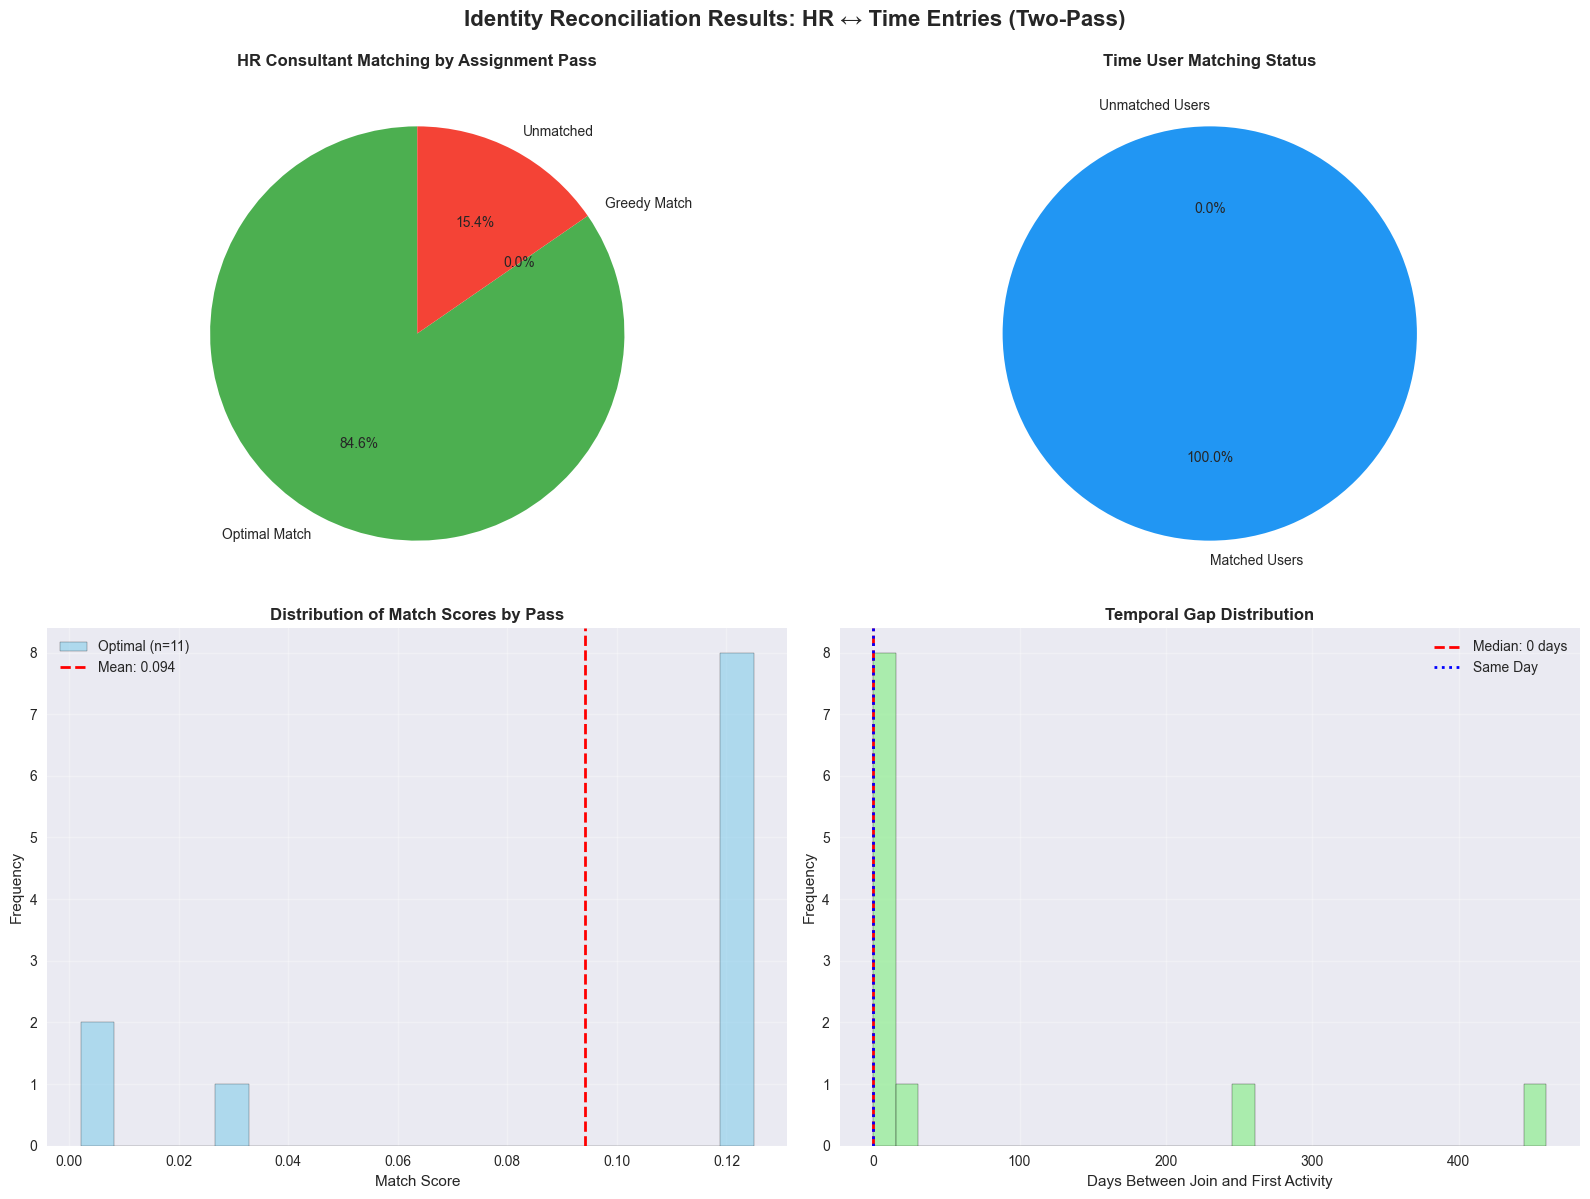


✓ Identity reconciliation complete!
✓ Master identity map stored in 'df_master_identity_map' DataFrame

Two-Pass Strategy Benefits:
  • Pass 1: Globally optimal 1:1 matching (Hungarian algorithm)
  • Pass 2: Greedy assignment for remaining active users
  • Maximizes user coverage while maintaining match quality

Next steps:
  • Use master_person_id as the unified identifier across systems
  • Link roles to projects using matched identities
  • Investigate unmatched entities for data quality issues


In [5]:
# === IDENTITY RECONCILIATION: HR ↔ TIME ENTRIES (TWO-PASS ALGORITHM) ===
print("="*80)
print("IDENTITY RECONCILIATION PIPELINE - TWO-PASS ASSIGNMENT")
print("="*80)
print("\nMatching HR consultants to anonymous time entry users...")
print("Strategy: Optimal assignment + Greedy fallback for remaining users\n")

from scipy.optimize import linear_sum_assignment

# --- STEP 1A: PRE-COMPUTATION ---
print("=== STEP 1A: PRE-COMPUTATION ===\n")

# Convert HR join dates to datetime
df_hr['startdate'] = pd.to_datetime(df_hr['startdate'], errors='coerce')

# Convert time entry dates
df_time_entries['dt'] = pd.to_datetime(df_time_entries['dt'], errors='coerce')

# For each anonymous user_id in time entries, find their very first day of activity
time_person_starts = df_time_entries.groupby('user_id')['dt'].min().reset_index()
time_person_starts.rename(columns={'dt': 'first_activity_date'}, inplace=True)

print(f"✓ HR Consultants: {len(df_hr)}")
print(f"✓ Anonymous Time Users: {len(time_person_starts)}")
print()

print("Earliest activity date for each anonymous time user (first 10):")
display(time_person_starts.head(10))

# --- STEP 1B: SCORING ALL POSSIBLE PAIRS ---
print("\n=== STEP 1B: SCORING ALL POSSIBLE PAIRS ===\n")
print("Scoring based on temporal proximity (shorter delay = higher score)...\n")

all_consultant_ids = df_hr['consultant_id'].unique()
all_user_ids = time_person_starts['user_id'].unique()
pairing_scores = []

# Hard constraint buffer: Activity can start up to 7 days BEFORE joining (data entry tolerance)
TOLERANCE_DAYS = 7

for consultant_id in all_consultant_ids:
    hr_join_date = df_hr[df_hr['consultant_id'] == consultant_id]['startdate'].iloc[0]
    
    for user_id in all_user_ids:
        time_start_date = time_person_starts[time_person_starts['user_id'] == user_id]['first_activity_date'].iloc[0]
        
        # Calculate the delay in days (negative = activity before joining)
        days_diff = (time_start_date - hr_join_date).days
        
        # HARD CONSTRAINT: Activity cannot start more than 7 days before joining
        if days_diff < -TOLERANCE_DAYS:
            score = 0
            is_plausible = False
        else:
            # SOFT SCORE: Shorter delay gets higher score
            # Add 8 to denominator to avoid division by zero and ensure -7 days gets max score
            score = 1 / (days_diff + (TOLERANCE_DAYS + 1))
            is_plausible = True
        
        pairing_scores.append({
            'consultant_id': consultant_id,
            'user_id': user_id,
            'score': score,
            'is_plausible': is_plausible,
            'hr_join_date': hr_join_date,
            'first_activity_date': time_start_date,
            'days_diff': days_diff
        })

df_pairing_scores = pd.DataFrame(pairing_scores)

# Statistics
plausible_count = df_pairing_scores['is_plausible'].sum()
total_pairs = len(df_pairing_scores)

print(f"Total possible pairs: {total_pairs}")
print(f"Plausible pairs (passes temporal constraint): {plausible_count} ({plausible_count/total_pairs*100:.1f}%)")
print(f"Implausible pairs: {total_pairs - plausible_count}")
print()

print("Top 20 most plausible pairings (before optimization):")
display(df_pairing_scores.nlargest(20, 'score')[[
    'consultant_id', 'user_id', 'score', 'is_plausible', 
    'hr_join_date', 'first_activity_date', 'days_diff'
]])

# --- STEP 1C: PASS 1 - OPTIMAL ASSIGNMENT (HUNGARIAN ALGORITHM) ---
print("\n=== STEP 1C: PASS 1 - OPTIMAL ASSIGNMENT ===\n")
print("Finding the single best set of unique 1:1 matches using Hungarian algorithm...\n")

# Create score matrix for Hungarian algorithm
score_matrix = df_pairing_scores.pivot_table(
    index='consultant_id', 
    columns='user_id', 
    values='score'
).fillna(0)

print(f"Score matrix shape: {score_matrix.shape} (consultants × users)")

# Apply Hungarian algorithm (maximize score)
# Note: We convert to cost by subtracting from max
cost_matrix = score_matrix.max().max() - score_matrix
consultant_indices, user_indices = linear_sum_assignment(cost_matrix)

# --- STEP 1D: BUILD PASS 1 IDENTITY MAP ---
print("\n=== STEP 1D: BUILDING PASS 1 IDENTITY MAP ===\n")

master_identity_map_pass1 = []
matched_consultants_pass1 = []
matched_users_pass1 = []

for c_idx, u_idx in zip(consultant_indices, user_indices):
    consultant_id = score_matrix.index[c_idx]
    user_id = score_matrix.columns[u_idx]
    score = score_matrix.iloc[c_idx, u_idx]
    
    # Only include valid matches (score > 0)
    if score > 0:
        # Get original pairing data
        pair_data = df_pairing_scores[
            (df_pairing_scores['consultant_id'] == consultant_id) & 
            (df_pairing_scores['user_id'] == user_id)
        ].iloc[0]

        # Get seniority from df_hr
        seniority = df_hr.loc[df_hr['consultant_id'] == consultant_id, 'seniority'].iloc[0]
        
        master_identity_map_pass1.append({
            'master_person_id': f"PERSON_{consultant_id}",
            'consultant_id': consultant_id,
            'user_id': user_id,
            'seniority': seniority, # ADDED
            'match_score': score,
            'hr_join_date': pair_data['hr_join_date'],
            'first_activity_date': pair_data['first_activity_date'],
            'days_between': pair_data['days_diff'],
            'assignment_pass': 'Optimal'
        })
        matched_consultants_pass1.append(consultant_id)
        matched_users_pass1.append(user_id)

df_master_identity_map_pass1 = pd.DataFrame(master_identity_map_pass1)

print(f"✓ Pass 1 complete: {len(df_master_identity_map_pass1)} high-confidence matches found")
print()

# --- STEP 1E: PASS 2 - GREEDY FORCED ASSIGNMENT FOR REMAINING USERS ---
print("=== STEP 1E: PASS 2 - GREEDY FORCED ASSIGNMENT ===\n")
print("Force-matching remaining active time users to best available HR consultants...\n")

# Identify unmatched entities after Pass 1
unmatched_consultants_pass1 = list(set(all_consultant_ids) - set(matched_consultants_pass1))
unmatched_users_pass1 = list(set(all_user_ids) - set(matched_users_pass1))

print(f"Unmatched after Pass 1:")
print(f"  • HR Consultants: {len(unmatched_consultants_pass1)}")
print(f"  • Time Users: {len(unmatched_users_pass1)}")
print()

master_identity_map_pass2 = []

# Prioritize matching every remaining time_user_id (active users should have HR records)
for user_id in unmatched_users_pass1:
    # Find all available, plausible HR partners from the remaining pool
    candidate_matches = df_pairing_scores[
        (df_pairing_scores['user_id'] == user_id) &
        (df_pairing_scores['consultant_id'].isin(unmatched_consultants_pass1)) &
        (df_pairing_scores['score'] > 0)  # Must pass temporal constraint
    ]
    
    if not candidate_matches.empty:
        # Greedily pick the best available HR consultant for this time user
        best_match = candidate_matches.nlargest(1, 'score').iloc[0]
        best_consultant_id = best_match['consultant_id']

        # Get seniority from df_hr
        seniority = df_hr.loc[df_hr['consultant_id'] == best_consultant_id, 'seniority'].iloc[0]
        
        # Add to Pass 2 assignments
        master_identity_map_pass2.append({
            'master_person_id': f"PERSON_{best_consultant_id}",
            'consultant_id': best_consultant_id,
            'user_id': user_id,
            'seniority': seniority, # ADDED
            'match_score': best_match['score'],
            'hr_join_date': best_match['hr_join_date'],
            'first_activity_date': best_match['first_activity_date'],
            'days_between': best_match['days_diff'],
            'assignment_pass': 'Greedy'
        })
        
        # CRITICAL: Remove the chosen consultant from available pool
        unmatched_consultants_pass1.remove(best_consultant_id)
        
        if len(master_identity_map_pass2) <= 10:
            print(f"Matched User {user_id} → Consultant {best_consultant_id} (score: {best_match['score']:.4f})")

df_master_identity_map_pass2 = pd.DataFrame(master_identity_map_pass2)

if not df_master_identity_map_pass2.empty:
    print(f"\n✓ Pass 2 complete: {len(df_master_identity_map_pass2)} additional matches found")
else:
    print("\n✓ Pass 2 complete: No additional matches possible")
print()

# --- STEP 1F: CONSOLIDATE FINAL IDENTITY MAP ---
print("=== STEP 1F: CONSOLIDATING FINAL IDENTITY MAP ===\n")

df_master_identity_map = pd.concat([
    df_master_identity_map_pass1, 
    df_master_identity_map_pass2
], ignore_index=True)

# Final unmatched entities
matched_consultants = df_master_identity_map['consultant_id'].unique()
matched_users = df_master_identity_map['user_id'].unique()
unmatched_consultants = set(all_consultant_ids) - set(matched_consultants)
unmatched_users = set(all_user_ids) - set(matched_users)

# --- STEP 1G: FINAL STATISTICS & VALIDATION ---
print("=== FINAL STATISTICS ===\n")
print(f"Total HR Consultants: {len(all_consultant_ids)}")
print(f"Total Time Entry Users: {len(all_user_ids)}")
print(f"Successfully Matched: {len(df_master_identity_map)}")
print(f"  • Pass 1 (Optimal): {len(df_master_identity_map_pass1)}")
print(f"  • Pass 2 (Greedy): {len(df_master_identity_map_pass2)}")
print(f"Unmatched HR Consultants: {len(unmatched_consultants)}")
print(f"Unmatched Time Users: {len(unmatched_users)}")
print(f"Match Rate (HR): {(len(matched_consultants) / len(all_consultant_ids) * 100):.2f}%")
print(f"Match Rate (Users): {(len(matched_users) / len(all_user_ids) * 100):.2f}%")
print()

print("="*80)
print("✅ MASTER IDENTITY MAP CREATED (TWO-PASS)")
print("="*80)
print()
display(df_master_identity_map)

# --- STEP 1H: SAVE IDENTITY MAP ---
print("\n=== SAVING IDENTITY MAP ===\n")

if 'output_dir' not in locals():
    output_dir = Path("../data/processed/linking_tables")
    output_dir.mkdir(parents=True, exist_ok=True)
    timestamp = pd.Timestamp.now().strftime("%Y%m%d")

identity_map_path = output_dir / f"link__hr_to_time_users__{timestamp}.csv"
df_master_identity_map.to_csv(identity_map_path, index=False)
print(f"✓ Saved: {identity_map_path}")
print(f"  Rows: {len(df_master_identity_map)}")

# Save unmatched for investigation
if len(unmatched_consultants) > 0:
    unmatched_hr_df = df_hr[df_hr['consultant_id'].isin(unmatched_consultants)]
    unmatched_hr_path = output_dir / f"unmatch__hr_consultants__{timestamp}.csv"
    unmatched_hr_df.to_csv(unmatched_hr_path, index=False)
    print(f"  ℹ Unmatched HR saved: {unmatched_hr_path}")

if len(unmatched_users) > 0:
    unmatched_users_df = time_person_starts[time_person_starts['user_id'].isin(unmatched_users)]
    unmatched_users_path = output_dir / f"unmatch__time_users__{timestamp}.csv"
    unmatched_users_df.to_csv(unmatched_users_path, index=False)
    print(f"  ℹ Unmatched users saved: {unmatched_users_path}")

# --- STEP 1I: VISUALIZATION ---
print("\n=== VISUALIZATION ===\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Match Status by Pass
ax1 = axes[0, 0]
pass_counts = df_master_identity_map['assignment_pass'].value_counts()
unmatched_count = len(unmatched_consultants)
status_data = pd.DataFrame({
    'Category': ['Optimal Match', 'Greedy Match', 'Unmatched'],
    'Count': [pass_counts.get('Optimal', 0), pass_counts.get('Greedy', 0), unmatched_count]
})
ax1.pie(status_data['Count'], labels=status_data['Category'], autopct='%1.1f%%',
        colors=['#4CAF50', '#FFC107', '#F44336'], startangle=90)
ax1.set_title('HR Consultant Matching by Assignment Pass', fontsize=12, fontweight='bold')

# 2. User Match Status
ax2 = axes[0, 1]
user_status_data = pd.DataFrame({
    'Category': ['Matched Users', 'Unmatched Users'],
    'Count': [len(matched_users), len(unmatched_users)]
})
ax2.pie(user_status_data['Count'], labels=user_status_data['Category'], autopct='%1.1f%%',
        colors=['#2196F3', '#FF9800'], startangle=90)
ax2.set_title('Time User Matching Status', fontsize=12, fontweight='bold')

# 3. Score Distribution by Pass
ax3 = axes[1, 0]
if len(df_master_identity_map) > 0:
    for pass_type, color in [('Optimal', 'skyblue'), ('Greedy', 'orange')]:
        pass_data = df_master_identity_map[df_master_identity_map['assignment_pass'] == pass_type]
        if len(pass_data) > 0:
            ax3.hist(pass_data['match_score'], bins=20, alpha=0.6, 
                    label=f'{pass_type} (n={len(pass_data)})', color=color, edgecolor='black')
    
    ax3.axvline(df_master_identity_map['match_score'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {df_master_identity_map["match_score"].mean():.3f}')
    ax3.set_xlabel('Match Score', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title('Distribution of Match Scores by Pass', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No Matches Found', ha='center', va='center', fontsize=14)

# 4. Days Between Join and First Activity
ax4 = axes[1, 1]
if len(df_master_identity_map) > 0:
    valid_days = df_master_identity_map[df_master_identity_map['days_between'].notna()]['days_between']
    ax4.hist(valid_days, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    ax4.axvline(valid_days.median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {valid_days.median():.0f} days')
    ax4.axvline(0, color='blue', linestyle=':', linewidth=2, label='Same Day')
    ax4.set_xlabel('Days Between Join and First Activity', fontsize=11)
    ax4.set_ylabel('Frequency', fontsize=11)
    ax4.set_title('Temporal Gap Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=14)

plt.suptitle('Identity Reconciliation Results: HR ↔ Time Entries (Two-Pass)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Identity reconciliation complete!")
print("✓ Master identity map stored in 'df_master_identity_map' DataFrame")
print("\nTwo-Pass Strategy Benefits:")
print("  • Pass 1: Globally optimal 1:1 matching (Hungarian algorithm)")
print("  • Pass 2: Greedy assignment for remaining active users")
print("  • Maximizes user coverage while maintaining match quality")
print("\nNext steps:")
print("  • Use master_person_id as the unified identifier across systems")
print("  • Link roles to projects using matched identities")
print("  • Investigate unmatched entities for data quality issues")

# Comprehensive Matched Pairs Analysis: Work Metrics & Utilization

This section enriches the matched HR-to-Time-User pairs with detailed work performance metrics, calculating utilization rates and identifying capacity gaps for each person.

---

## 🎯 **Purpose**

Transform the basic identity mapping into actionable workforce analytics by:
1. Calculating **actual work output** from time entries (billable/non-billable hours)
2. Estimating **theoretical capacity** from HR tenure data
3. Computing **utilization rates** to measure efficiency
4. Identifying **capacity gaps** and under-utilization

---

## 📋 **STEP 1: Calculate Work Metrics for Matched Users**

### What Happens Here:

```python
matched_user_ids = df_master_identity_map['user_id'].unique()
```
- **Source**: Extracts all `user_id` values from the identity map created in previous steps
- **Purpose**: Ensures we only analyze users who were successfully matched to HR consultants

### For Each Matched User:

#### 1A. **Basic Work Volume**
```python
'total_hours_logged': user_time_data['hours'].sum()
```
- **Calculation**: Sum of ALL hours logged by this user across all projects
- **Represents**: Total recorded work output (billable + non-billable)

```python
'billable_hours': user_time_data[user_time_data['billable'] == True]['hours'].sum()
'non_billable_hours': user_time_data[user_time_data['billable'] == False]['hours'].sum()
```
- **Calculation**: Splits total hours into client-facing vs internal work
- **Use Case**: Revenue analysis and work composition tracking

#### 1B. **Project Engagement Metrics**
```python
'n_projects_worked': user_time_data['project_id'].nunique()
'n_billable_projects': user_time_data[user_time_data['billable'] == True]['project_id'].nunique()
```
- **Calculation**: Counts distinct projects (all vs billable only)
- **Insight**: Measures workload diversity and client exposure

#### 1C. **Time Span & Activity Patterns**
```python
'first_time_entry': user_time_data['dt'].min()
'last_time_entry': user_time_data['dt'].max()
```
- **Source**: Earliest and latest dates from time entry records
- **Purpose**: Defines the active work period for this person

```python
'days_active_span': (max_date - min_date).days
```
- **Calculation**: Calendar days between first and last time entry
- **Note**: Includes weekends/holidays (raw span)

```python
'unique_work_days': user_time_data['dt'].dt.date.nunique()
```
- **Calculation**: Count of distinct dates with at least one time entry
- **Use**: Measures actual engagement frequency

#### 1D. **Intensity Metrics**
```python
'avg_hours_per_entry': user_time_data['hours'].mean()
```
- **Calculation**: Average hours per individual time log
- **Insight**: Typical logging granularity (e.g., 4h suggests half-day blocks)

```python
'avg_hours_per_work_day': user_time_data.groupby(dt.date)['hours'].sum().mean()
```
- **Calculation**: 
  1. Group all time entries by date
  2. Sum hours for each date
  3. Average across all work days
- **Represents**: Daily work intensity when active

---

## 📋 **STEP 2: Calculate HR-Based Availability Metrics**

### Standard Work Assumptions (Constants):
```python
STANDARD_WORK_HOURS_PER_DAY = 8
STANDARD_WORK_DAYS_PER_WEEK = 5
STANDARD_WORK_WEEKS_PER_YEAR = 52
```
- **Industry Standard**: 40-hour work week baseline
- **Purpose**: Establishes theoretical maximum capacity

### For Each Matched Consultant:

#### 2A. **Tenure Calculation**
```python
days_since_joining = (today - join_date).days
```
- **Source**: `today` = current date, `join_date` = HR startdate
- **Output**: Total calendar days employed

```python
estimated_work_days = int(days_since_joining * (5/7))
```
- **Formula**: Calendar days × (5 workdays / 7 total days)
- **Approximation**: Converts total days to business days (rough estimate)

#### 2B. **Theoretical Capacity**
```python
total_potential_hours = estimated_work_days * STANDARD_WORK_HOURS_PER_DAY
```
- **Formula**: Work days × 8 hours/day
- **Represents**: Maximum billable hours if 100% utilized (unrealistic)

#### 2C. **PTO Adjustment** (More Realistic)
```python
estimated_pto_days = int(years_employed * 15)
```
- **Assumption**: 15 days PTO/holidays per year (industry average)
- **Source**: `years_employed = days_since_joining / 365.25`

```python
adjusted_work_days = max(0, estimated_work_days - estimated_pto_days)
adjusted_potential_hours = adjusted_work_days * STANDARD_WORK_HOURS_PER_DAY
```
- **Formula**: (Business days - PTO days) × 8h
- **Purpose**: More realistic capacity after accounting for time off
- **Safety**: `max(0, ...)` prevents negative values for new hires

---

## 📋 **STEP 3: Merge & Calculate Utilization Metrics**

### Joining the Data:
```python
df_enriched_matches = df_master_identity_map
    .merge(df_user_work_metrics, on='user_id')
    .merge(df_consultant_availability, on=['consultant_id', 'user_id'])
```
- **Result**: Single table with identity info + work metrics + capacity estimates

### Key Calculated Metrics:

#### 3A. **Utilization Rate**
```python
utilization_rate = (total_hours_logged / adjusted_potential_hours_pto) * 100
```
- **Formula**: (Actual work / Available capacity) × 100
- **Interpretation**:
  - **< 50%**: Significant under-utilization
  - **50-70%**: Moderate utilization
  - **70-90%**: Good utilization (target range)
  - **> 100%**: Over-capacity (overtime or data error)

#### 3B. **Billable Utilization Rate**
```python
billable_utilization_rate = (billable_hours / adjusted_potential_hours_pto) * 100
```
- **Formula**: (Client-facing hours / Capacity) × 100
- **Business Use**: Revenue-generating efficiency metric
- **Industry Benchmark**: 60-75% is healthy for consultancies

#### 3C. **Billable Percentage**
```python
billable_percentage = (billable_hours / total_hours_logged) * 100
```
- **Formula**: (Billable / Total logged) × 100
- **Shows**: What portion of work time is revenue-generating
- **Target**: 70-80% (rest is admin, training, sales)

#### 3D. **Work Day Coverage**
```python
work_day_coverage = (unique_work_days / adjusted_work_days_pto) * 100
```
- **Formula**: (Days with time entries / Available work days) × 100
- **Indicates**: Consistency of time logging
- **Low values**: Potential compliance issue or project gaps

#### 3E. **Capacity Gaps**
```python
hours_gap = adjusted_potential_hours_pto - total_hours_logged
billable_hours_gap = adjusted_potential_hours_pto - billable_hours
```
- **Calculation**: Theoretical capacity minus actual logged hours
- **Positive Gap**: Under-utilized capacity (opportunity cost)
- **Negative Gap**: Over-capacity (overtime or tracking errors)

---

## 📋 **STEP 4: Categorization & Insights**

### Utilization Categories:
```python
bins=[0, 30, 50, 70, 90, float('inf')]
labels=['Very Low (<30%)', 'Low (30-50%)', 'Medium (50-70%)', 
        'Good (70-90%)', 'Excellent (>90%)']
```
- **Purpose**: Segment workforce by performance tier
- **Use Case**: Identify top performers and under-performers

### Top/Bottom Rankings:
- **Top 10 by Total Hours**: Hardest workers (volume)
- **Top 10 by Billable Rate**: Most revenue-efficient
- **Bottom 10 by Utilization**: Require intervention (idle capacity)

---

## 📊 **Key Metrics Summary Table**

| Metric | Source/Calculation | Business Meaning |
|--------|-------------------|------------------|
| `total_hours_logged` | `sum(hours)` from time entries | Total work output |
| `billable_hours` | `sum(hours WHERE billable=True)` | Revenue-generating work |
| `adjusted_potential_hours_pto` | `(work_days - PTO) × 8h` | Realistic capacity |
| `utilization_rate` | `(logged / potential) × 100` | Overall efficiency |
| `billable_utilization_rate` | `(billable / potential) × 100` | Revenue efficiency |
| `billable_percentage` | `(billable / logged) × 100` | Work composition |
| `hours_gap` | `potential - logged` | Unutilized capacity |
| `unique_work_days` | `count(distinct dates)` | Activity frequency |
| `avg_hours_per_work_day` | `sum(hours per day) / days` | Daily intensity |
| `n_projects_worked` | `count(distinct project_id)` | Workload diversity |

---

## 📈 **Visualization Dashboard (12 Charts)**

### 1. **Utilization Rate Distribution** (Histogram)
- Shows spread of utilization across team
- **Red line**: Median utilization
- **Green line**: 70% target threshold

### 2. **Billable vs Total Hours** (Scatter Plot)
- **Color**: Represents billable percentage
- **Diagonal line**: 100% billable (theoretical max)
- **Insight**: Identifies people with low billable ratios

### 3. **Utilization Category Pie Chart**
- Segments team into performance buckets
- Quick visual of team health distribution

### 4. **Actual vs Potential Hours** (Scatter)
- **Color**: Utilization rate (green = good, red = poor)
- **Diagonal**: 100% utilization line
- **Purpose**: Spot over/under-utilized people

### 5-12. **Additional Analytics**
- Billable utilization histogram
- Billable percentage distribution
- Tenure vs hours correlation
- Projects per person
- Work day coverage
- Assignment pass comparison
- Hours gap (waste) distribution
- Daily work intensity

---

## ✅ **Final Outputs**

### **`df_enriched_matches`** DataFrame Contains:
- All identity matching info (person_id, consultant_id, user_id)
- 30+ calculated metrics per person
- Health indicators and categories
- Ready for executive dashboards and workforce planning

### **Saved Artifacts**:
```python
link__hr_to_time_users_enriched__{timestamp}.csv
```
- Complete enriched dataset for further analysis
- Includes all calculated fields
- Can be loaded into BI tools (Tableau, Power BI)

---

## 💡 **Business Applications**

1. **Capacity Planning**: Identify who has bandwidth for new projects
2. **Performance Reviews**: Objective utilization metrics
3. **Revenue Optimization**: Improve billable percentage
4. **Hiring Decisions**: Spots when team is over/under-staffed
5. **Project Staffing**: Match people to projects based on availability
6. **Budget Forecasting**: Predict labor costs from utilization trends

---

## 🔑 **Key Assumptions & Limitations**

| Assumption | Reality Check |
|------------|---------------|
| 8-hour workday | Some people work more/less |
| 15 days PTO/year | Varies by country/contract |
| 5-day work week | Remote workers may have flexible schedules |
| All time logged | Actual work may exceed logged hours |
| PTO accrues linearly | Often front-loaded or variable |

**Recommendation**: Use these metrics as **directional indicators**, not absolute truth. Validate with manager feedback.

---

## ✅ **What This Enables**

By the end of this section, we can answer:
- ✓ Who are our most/least utilized people?
- ✓ How much revenue-generating capacity do we have?
- ✓ Where is our biggest capacity waste?
- ✓ Who should be assigned to new projects?
- ✓ Do we need to hire more people?

**Next Step**: Use these enriched person profiles to assign roles based on actual capacity.

MATCHED PAIRS: DETAILED WORK PATTERN ANALYSIS

Enriching matched pairs with work metrics and utilization statistics...

=== STEP 1: CALCULATING WORK METRICS ===

✓ Calculated work metrics for 11 matched users

=== STEP 2: CALCULATING HR AVAILABILITY METRICS ===

✓ Calculated availability metrics for 11 matched consultants

=== STEP 3: CREATING ENRICHED MATCHED PAIRS TABLE ===

✓ Enriched matched pairs table created with 11 rows
✓ Added 34 total columns

=== STEP 4: KEY INSIGHTS & STATISTICS ===

Sample of Enriched Matched Pairs (First 10):


master_person_id  \
0  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4   
1  PERSON_2a554628-d7f2-475f-8872-5a7057388c36   
2  PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7   
3  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
4  PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368   
5  PERSON_61948bc5-3844-4219-a605-94e22f59571a   
6  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
7  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2   
8  PERSON_afd559ec-90bf-40c9-8e96-57e3d7af66fd   
9  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9   

                          consultant_id                   user_id  \
0  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  64f5e9f270d77d3906fdbcf0   
1  2a554628-d7f2-475f-8872-5a7057388c36  66cf0a91d9fd470646f99eb9   
2  348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  5f68ec6a633ecf60f5e863ce   
3  38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
4  40d8972b-c3ad-450e-a56d-873a8cdc4368  5f437ae67d26442bf5452ecd   
5  61948bc5-3844-4219-a605-94e22f59571a  6569cd007deb44467624660e   
6  85808593-b0e4-4163-b8f1-a5fc90b219ee  61e06b0375015b508b28241b   
7  8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  5f437e3d9decb91192e3784a   
8  afd559ec-90bf-40c9-8e96-57e3d7af66fd  640f2ad98c3e1105ccb78609   
9  d2458d77-5056-43b5-82c4-12543225bcd9  5f7c718cf3fda011462c67c1   

  assignment_pass  total_hours_logged  billable_hours  \
0         Optimal             3360.00     2320.000000   
1         Optimal             1412.00      928.000000   
2         Optimal             9278.00     5787.000000   
3         Optimal             4588.00      262.500000   
4         Optimal             9831.05     6112.050000   
5         Optimal             2837.00     1060.000000   
6         Optimal             6536.60     3632.016667   
7         Optimal             9691.50     4902.750000   
8         Optimal             4288.00     2837.000000   
9         Optimal             9087.50     7345.000000   

   adjusted_potential_hours_pto  utilization_rate  billable_utilization_rate  \
0                          4112             81.71                      56.42   
1                          2224             63.49                      41.73   
2                          9864             94.06                      58.67   
3                          4184            109.66                       6.27   
4                         11512             85.40                      53.09   
5                          3640             77.94                      29.12   
6                          7576             86.28                      47.94   
7                         12664             76.53                      38.71   
8                          5056             84.81                      56.11   
9                          9864             92.13                      74.46   

   billable_percentage  n_projects_worked  years_employed  
0                69.05                  7        2.091718  
1                65.72                  6        1.133470  
2                62.37                 14        5.015743  
3                 5.72                 12        2.124572  
4                62.17                 24        5.850787  
5                37.36                  7        1.850787  
6                55.56                 14        3.849418  
7                50.59                 12        6.436687  
8                66.16                  7        2.570842  
9                80.83                 16        5.015743


=== UTILIZATION STATISTICS ===

       utilization_rate  billable_utilization_rate  billable_percentage  \
count         11.000000                  11.000000            11.000000   
mean          85.376364                  45.762727            54.767273   
std           11.579888                  17.876808            20.085027   
min           63.490000                   6.270000             5.720000   
25%           79.825000                  39.790000            48.750000   
50%           85.400000                  47.940000            62.170000   
75%           89.630000                  56.265000            65.940000   
max          109.660000                  74.460000            80.830000   

       total_hours_logged  billable_hours    hours_gap  
count           11.000000       11.000000    11.000000  
mean          5981.422727     3407.119697   955.304545  
std           3050.504825     2346.675609   824.218190  
min           1412.000000      262.500000  -404.000000  
25%   

master_person_id  total_hours_logged  \
4   PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368             9831.05   
7   PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2             9691.50   
2   PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7             9278.00   
9   PERSON_d2458d77-5056-43b5-82c4-12543225bcd9             9087.50   
6   PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee             6536.60   
10  PERSON_db394d2e-2ed0-47a1-b5b9-236f864768ab             4886.00   
3   PERSON_38eebb46-9733-484c-afd2-543d79eb80b1             4588.00   
8   PERSON_afd559ec-90bf-40c9-8e96-57e3d7af66fd             4288.00   
0   PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             3360.00   
5   PERSON_61948bc5-3844-4219-a605-94e22f59571a             2837.00   

    billable_hours  utilization_rate  n_projects_worked  years_employed  
4      6112.050000             85.40                 24        5.850787  
7      4902.750000             76.53                 12        6.436687  
2      5787.000000             94.06                 14        5.015743  
9      7345.000000             92.13                 16        5.015743  
6      3632.016667             86.28                 14        3.849418  
10     2292.000000             87.13                 13        2.850103  
3       262.500000            109.66                 12        2.124572  
8      2837.000000             84.81                  7        2.570842  
0      2320.000000             81.71                  7        2.091718  
5      1060.000000             77.94                  7        1.850787


=== TOP 10 BY BILLABLE UTILIZATION RATE ===



master_person_id  billable_hours  \
9   PERSON_d2458d77-5056-43b5-82c4-12543225bcd9     7345.000000   
2   PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7     5787.000000   
0   PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4     2320.000000   
8   PERSON_afd559ec-90bf-40c9-8e96-57e3d7af66fd     2837.000000   
4   PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368     6112.050000   
6   PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee     3632.016667   
1   PERSON_2a554628-d7f2-475f-8872-5a7057388c36      928.000000   
10  PERSON_db394d2e-2ed0-47a1-b5b9-236f864768ab     2292.000000   
7   PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2     4902.750000   
5   PERSON_61948bc5-3844-4219-a605-94e22f59571a     1060.000000   

    billable_utilization_rate  billable_percentage  years_employed  
9                       74.46                80.83        5.015743  
2                       58.67                62.37        5.015743  
0                       56.42                69.05        2.091718  
8                       56.11                66.16        2.570842  
4                       53.09                62.17        5.850787  
6                       47.94                55.56        3.849418  
1                       41.73                65.72        1.133470  
10                      40.87                46.91        2.850103  
7                       38.71                50.59        6.436687  
5                       29.12                37.36        1.850787


=== BOTTOM 10 BY UTILIZATION RATE (POTENTIAL ISSUES) ===



master_person_id  total_hours_logged  \
1   PERSON_2a554628-d7f2-475f-8872-5a7057388c36             1412.00   
7   PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2             9691.50   
5   PERSON_61948bc5-3844-4219-a605-94e22f59571a             2837.00   
0   PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             3360.00   
8   PERSON_afd559ec-90bf-40c9-8e96-57e3d7af66fd             4288.00   
4   PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368             9831.05   
6   PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee             6536.60   
10  PERSON_db394d2e-2ed0-47a1-b5b9-236f864768ab             4886.00   
9   PERSON_d2458d77-5056-43b5-82c4-12543225bcd9             9087.50   
2   PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7             9278.00   

    adjusted_potential_hours_pto  utilization_rate  hours_gap  years_employed  
1                           2224             63.49     812.00        1.133470  
7                          12664             76.53    2972.50        6.436687  
5                           3640             77.94     803.00        1.850787  
0                           4112             81.71     752.00        2.091718  
8                           5056             84.81     768.00        2.570842  
4                          11512             85.40    1680.95        5.850787  
6                           7576             86.28    1039.40        3.849418  
10                          5608             87.13     722.00        2.850103  
9                           9864             92.13     776.50        5.015743  
2                           9864             94.06     586.00        5.015743


=== STEP 5: VISUALIZATION DASHBOARD ===



C:\Users\guine\AppData\Local\Temp\ipykernel_23120\182493903.py:330: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax10.boxplot(utilization_by_pass, labels=pass_types, patch_artist=True,


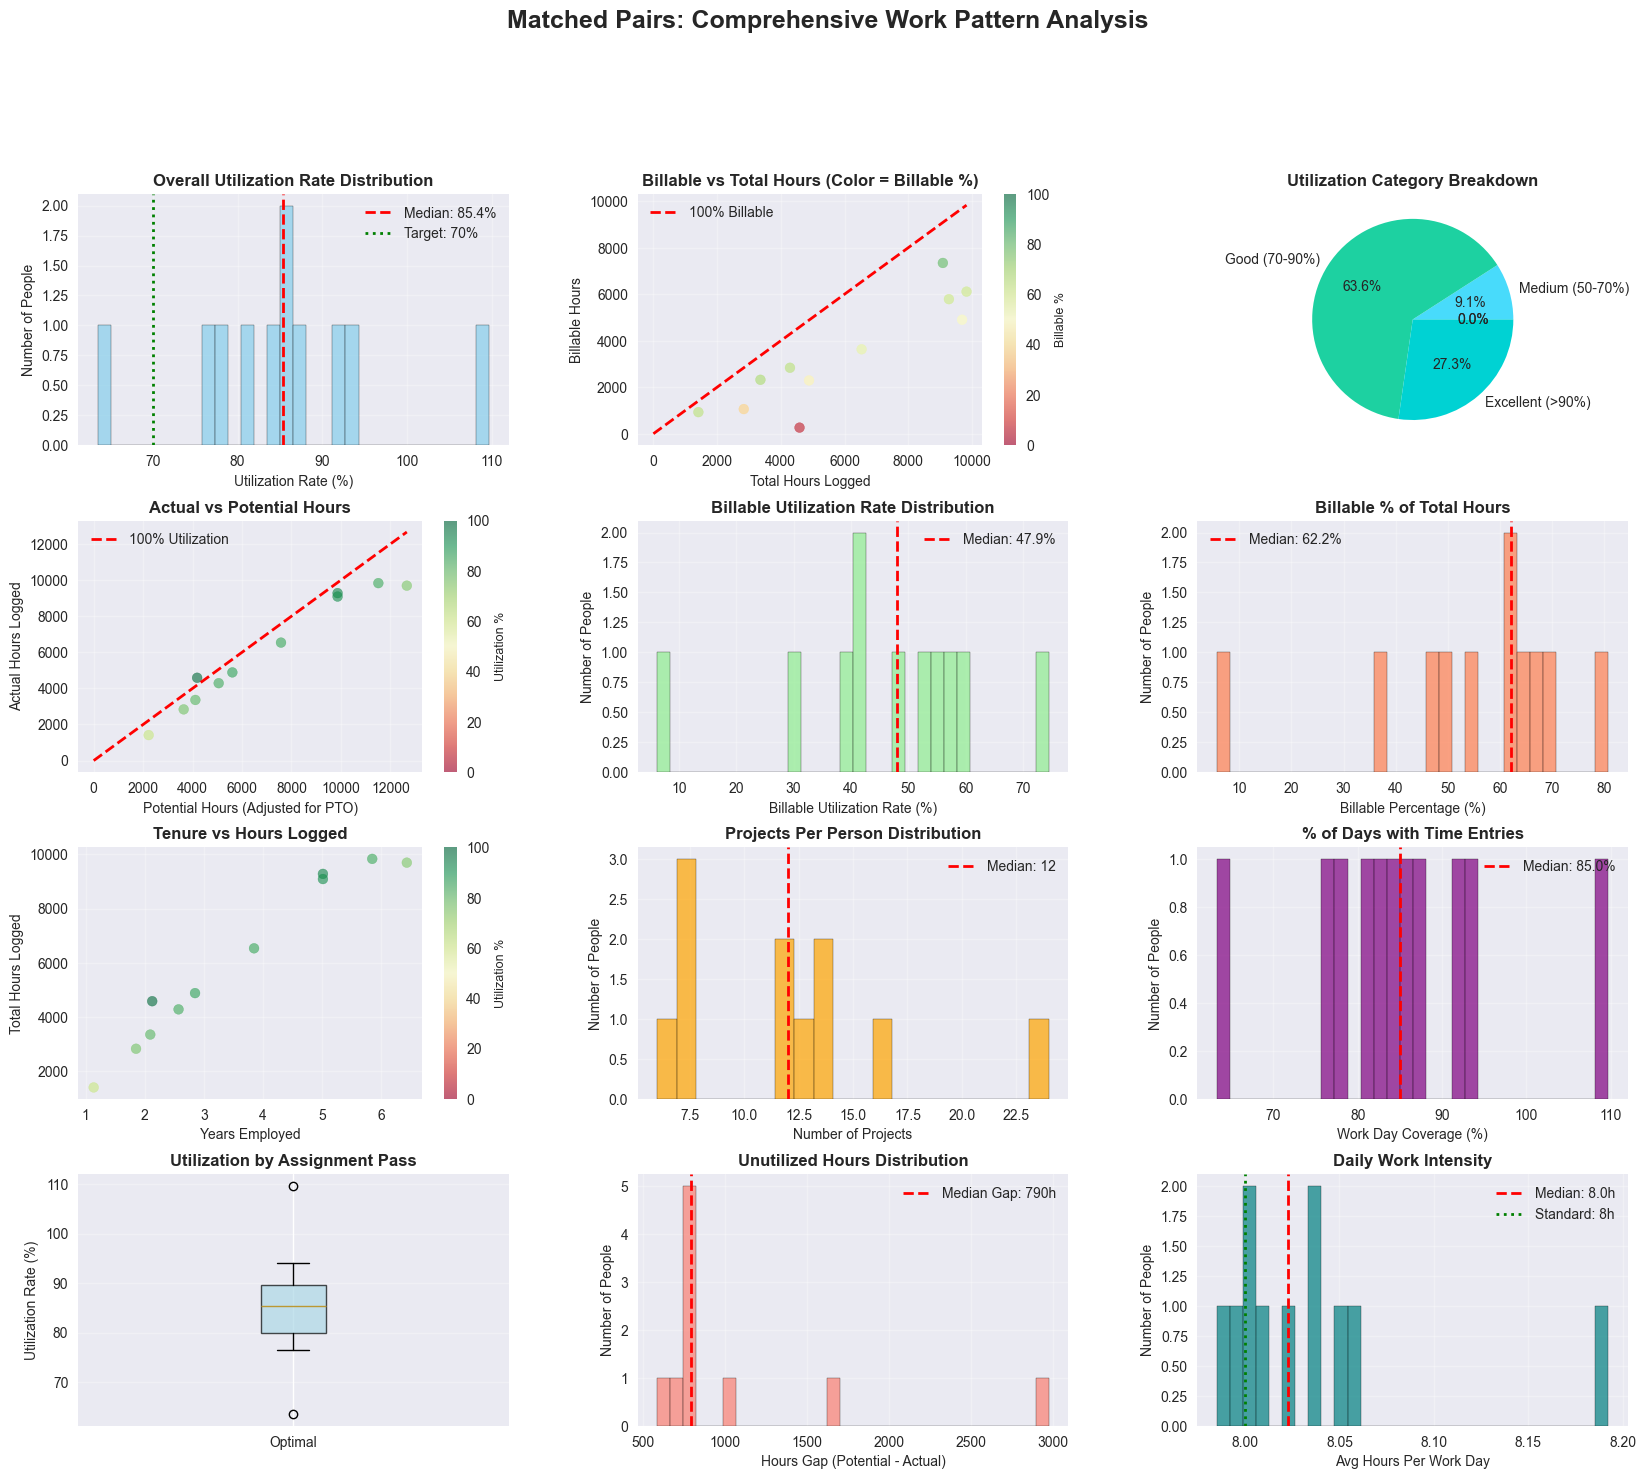


=== STEP 6: SAVING ENRICHED MATCHED PAIRS ===

✓ Saved enriched matched pairs to: ..\data\processed\linking_tables\link__hr_to_time_users_enriched__20251007.csv
  Rows: 11
  Columns: 35

SUMMARY: MATCHED PAIRS WORK ANALYSIS

Total Matched Pairs Analyzed: 11

Key Metrics:
  • Average Utilization Rate: 85.38%
  • Average Billable Utilization: 45.76%
  • Average Billable %: 54.77%
  • Median Total Hours: 4886h
  • Median Projects: 12

Enriched Data Columns Added:
  • utilization_rate, billable_utilization_rate, billable_percentage
  • work_day_coverage, hours_gap, billable_hours_gap
  • total_potential_hours, adjusted_potential_hours_pto
  • n_projects_worked, avg_hours_per_work_day

✓ Comprehensive work pattern analysis complete!


In [6]:
# === COMPREHENSIVE MATCHED PAIRS ANALYSIS ===
print("="*80)
print("MATCHED PAIRS: DETAILED WORK PATTERN ANALYSIS")
print("="*80)
print("\nEnriching matched pairs with work metrics and utilization statistics...\n")

# --- STEP 1: CALCULATE WORK METRICS FOR MATCHED USERS ---
print("=== STEP 1: CALCULATING WORK METRICS ===\n")

# Get all matched user_ids
matched_user_ids = df_master_identity_map['user_id'].unique()

# Calculate comprehensive metrics for each matched user
user_work_metrics = []

for user_id in matched_user_ids:
    user_time_data = df_time_entries[df_time_entries['user_id'] == user_id].copy()
    
    if len(user_time_data) > 0:
        metrics = {
            'user_id': user_id,
            'total_hours_logged': user_time_data['hours'].sum(),
            'billable_hours': user_time_data[user_time_data['billable'] == True]['hours'].sum(),
            'non_billable_hours': user_time_data[user_time_data['billable'] == False]['hours'].sum(),
            'total_time_entries': len(user_time_data),
            'n_projects_worked': user_time_data['project_id'].nunique(),
            'n_billable_projects': user_time_data[user_time_data['billable'] == True]['project_id'].nunique(),
            'first_time_entry': user_time_data['dt'].min(),
            'last_time_entry': user_time_data['dt'].max(),
            'days_active_span': (user_time_data['dt'].max() - user_time_data['dt'].min()).days,
            'unique_work_days': user_time_data['dt'].dt.date.nunique(),
            'avg_hours_per_entry': user_time_data['hours'].mean(),
            'avg_hours_per_work_day': user_time_data.groupby(user_time_data['dt'].dt.date)['hours'].sum().mean()
        }
        user_work_metrics.append(metrics)

df_user_work_metrics = pd.DataFrame(user_work_metrics)
print(f"✓ Calculated work metrics for {len(df_user_work_metrics)} matched users")

# --- STEP 2: CALCULATE HR-BASED AVAILABILITY METRICS ---
print("\n=== STEP 2: CALCULATING HR AVAILABILITY METRICS ===\n")

# Standard work assumptions
STANDARD_WORK_HOURS_PER_DAY = 8
STANDARD_WORK_DAYS_PER_WEEK = 5
STANDARD_WORK_WEEKS_PER_YEAR = 52

# Calculate availability for each matched consultant
consultant_availability = []

for _, row in df_master_identity_map.iterrows():
    consultant_id = row['consultant_id']
    hr_record = df_hr[df_hr['consultant_id'] == consultant_id].iloc[0]
    
    # Calculate tenure metrics
    join_date = pd.to_datetime(hr_record['startdate'])
    today = pd.Timestamp.now()
    
    # Days since joining
    days_since_joining = (today - join_date).days
    
    # Working days since joining (rough estimate: 5/7 of total days)
    estimated_work_days = int(days_since_joining * (5/7))
    
    # Total potential hours since joining
    total_potential_hours = estimated_work_days * STANDARD_WORK_HOURS_PER_DAY
    
    # Adjusted for typical PTO/holidays (assume ~15 days per year)
    years_employed = days_since_joining / 365.25
    estimated_pto_days = int(years_employed * 15)
    adjusted_work_days = max(0, estimated_work_days - estimated_pto_days)
    adjusted_potential_hours = adjusted_work_days * STANDARD_WORK_HOURS_PER_DAY
    
    consultant_availability.append({
        'consultant_id': consultant_id,
        'user_id': row['user_id'],
        'join_date': join_date,
        'days_since_joining': days_since_joining,
        'estimated_work_days': estimated_work_days,
        'adjusted_work_days_pto': adjusted_work_days,
        'total_potential_hours': total_potential_hours,
        'adjusted_potential_hours_pto': adjusted_potential_hours,
        'years_employed': years_employed
    })

df_consultant_availability = pd.DataFrame(consultant_availability)
print(f"✓ Calculated availability metrics for {len(df_consultant_availability)} matched consultants")

# --- STEP 3: MERGE ALL METRICS INTO ENRICHED MATCHED PAIRS ---
print("\n=== STEP 3: CREATING ENRICHED MATCHED PAIRS TABLE ===\n")

# Start with the master identity map
df_enriched_matches = df_master_identity_map.copy()

# Merge work metrics
df_enriched_matches = df_enriched_matches.merge(
    df_user_work_metrics,
    on='user_id',
    how='left'
)

# Merge availability metrics
df_enriched_matches = df_enriched_matches.merge(
    df_consultant_availability,
    on=['consultant_id', 'user_id'],
    how='left'
)

# Calculate utilization metrics
df_enriched_matches['utilization_rate'] = (
    df_enriched_matches['total_hours_logged'] / 
    df_enriched_matches['adjusted_potential_hours_pto'] * 100
).round(2)

df_enriched_matches['billable_utilization_rate'] = (
    df_enriched_matches['billable_hours'] / 
    df_enriched_matches['adjusted_potential_hours_pto'] * 100
).round(2)

df_enriched_matches['billable_percentage'] = (
    df_enriched_matches['billable_hours'] / 
    df_enriched_matches['total_hours_logged'] * 100
).round(2)

# Work intensity metrics
df_enriched_matches['work_day_coverage'] = (
    df_enriched_matches['unique_work_days'] / 
    df_enriched_matches['adjusted_work_days_pto'] * 100
).round(2)

# Gap analysis
df_enriched_matches['hours_gap'] = (
    df_enriched_matches['adjusted_potential_hours_pto'] - 
    df_enriched_matches['total_hours_logged']
).round(2)

df_enriched_matches['billable_hours_gap'] = (
    df_enriched_matches['adjusted_potential_hours_pto'] - 
    df_enriched_matches['billable_hours']
).round(2)

print(f"✓ Enriched matched pairs table created with {len(df_enriched_matches)} rows")
print(f"✓ Added {df_enriched_matches.shape[1]} total columns")

# --- STEP 4: DISPLAY KEY INSIGHTS ---
print("\n=== STEP 4: KEY INSIGHTS & STATISTICS ===\n")

# Display sample of enriched data
print("Sample of Enriched Matched Pairs (First 10):")
display_cols = [
    'master_person_id', 'consultant_id', 'user_id', 'assignment_pass',
    'total_hours_logged', 'billable_hours', 'adjusted_potential_hours_pto',
    'utilization_rate', 'billable_utilization_rate', 'billable_percentage',
    'n_projects_worked', 'years_employed'
]
display(df_enriched_matches[display_cols].head(10))

# Statistical Summary
print("\n=== UTILIZATION STATISTICS ===\n")
utilization_stats = df_enriched_matches[[
    'utilization_rate', 'billable_utilization_rate', 'billable_percentage',
    'total_hours_logged', 'billable_hours', 'hours_gap'
]].describe()
print(utilization_stats)

# Categorize by utilization
print("\n=== UTILIZATION CATEGORIZATION ===\n")
df_enriched_matches['utilization_category'] = pd.cut(
    df_enriched_matches['utilization_rate'],
    bins=[0, 30, 50, 70, 90, float('inf')],
    labels=['Very Low (<30%)', 'Low (30-50%)', 'Medium (50-70%)', 'Good (70-90%)', 'Excellent (>90%)']
)

utilization_counts = df_enriched_matches['utilization_category'].value_counts().sort_index()
for category, count in utilization_counts.items():
    print(f"{category}: {count} people ({count/len(df_enriched_matches)*100:.1f}%)")

# Top performers by different metrics
print("\n=== TOP 10 BY TOTAL HOURS LOGGED ===\n")
display(df_enriched_matches.nlargest(10, 'total_hours_logged')[[
    'master_person_id', 'total_hours_logged', 'billable_hours', 
    'utilization_rate', 'n_projects_worked', 'years_employed'
]])

print("\n=== TOP 10 BY BILLABLE UTILIZATION RATE ===\n")
display(df_enriched_matches.nlargest(10, 'billable_utilization_rate')[[
    'master_person_id', 'billable_hours', 'billable_utilization_rate', 
    'billable_percentage', 'years_employed'
]])

print("\n=== BOTTOM 10 BY UTILIZATION RATE (POTENTIAL ISSUES) ===\n")
display(df_enriched_matches.nsmallest(10, 'utilization_rate')[[
    'master_person_id', 'total_hours_logged', 'adjusted_potential_hours_pto',
    'utilization_rate', 'hours_gap', 'years_employed'
]])

# --- STEP 5: VISUALIZATION DASHBOARD ---
print("\n=== STEP 5: VISUALIZATION DASHBOARD ===\n")

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Utilization Rate Distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df_enriched_matches['utilization_rate'].dropna(), bins=30, 
         color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(df_enriched_matches['utilization_rate'].median(), color='red', 
            linestyle='--', linewidth=2, 
            label=f'Median: {df_enriched_matches["utilization_rate"].median():.1f}%')
ax1.axvline(70, color='green', linestyle=':', linewidth=2, label='Target: 70%')
ax1.set_xlabel('Utilization Rate (%)', fontsize=10)
ax1.set_ylabel('Number of People', fontsize=10)
ax1.set_title('Overall Utilization Rate Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Billable vs Total Hours Scatter
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(df_enriched_matches['total_hours_logged'], 
           df_enriched_matches['billable_hours'],
           alpha=0.6, s=50, c=df_enriched_matches['billable_percentage'], 
           cmap='RdYlGn', vmin=0, vmax=100)
ax2.plot([0, df_enriched_matches['total_hours_logged'].max()], 
         [0, df_enriched_matches['total_hours_logged'].max()], 
         'r--', linewidth=2, label='100% Billable')
ax2.set_xlabel('Total Hours Logged', fontsize=10)
ax2.set_ylabel('Billable Hours', fontsize=10)
ax2.set_title('Billable vs Total Hours (Color = Billable %)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(ax2.collections[0], ax=ax2)
cbar.set_label('Billable %', fontsize=9)

# 3. Utilization Category Pie Chart
ax3 = fig.add_subplot(gs[0, 2])
utilization_counts.plot(kind='pie', ax=ax3, autopct='%1.1f%%', 
                        colors=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1', '#00d2d3'])
ax3.set_ylabel('')
ax3.set_title('Utilization Category Breakdown', fontsize=12, fontweight='bold')

# 4. Hours Logged vs Potential Hours
ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(df_enriched_matches['adjusted_potential_hours_pto'], 
           df_enriched_matches['total_hours_logged'],
           alpha=0.6, s=50, c=df_enriched_matches['utilization_rate'], 
           cmap='RdYlGn', vmin=0, vmax=100)
ax4.plot([0, df_enriched_matches['adjusted_potential_hours_pto'].max()], 
         [0, df_enriched_matches['adjusted_potential_hours_pto'].max()], 
         'r--', linewidth=2, label='100% Utilization')
ax4.set_xlabel('Potential Hours (Adjusted for PTO)', fontsize=10)
ax4.set_ylabel('Actual Hours Logged', fontsize=10)
ax4.set_title('Actual vs Potential Hours', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
cbar2 = plt.colorbar(ax4.collections[0], ax=ax4)
cbar2.set_label('Utilization %', fontsize=9)

# 5. Billable Utilization Rate Distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(df_enriched_matches['billable_utilization_rate'].dropna(), bins=30, 
         color='lightgreen', edgecolor='black', alpha=0.7)
ax5.axvline(df_enriched_matches['billable_utilization_rate'].median(), color='red', 
            linestyle='--', linewidth=2, 
            label=f'Median: {df_enriched_matches["billable_utilization_rate"].median():.1f}%')
ax5.set_xlabel('Billable Utilization Rate (%)', fontsize=10)
ax5.set_ylabel('Number of People', fontsize=10)
ax5.set_title('Billable Utilization Rate Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Billable Percentage Distribution
ax6 = fig.add_subplot(gs[1, 2])
ax6.hist(df_enriched_matches['billable_percentage'].dropna(), bins=30, 
         color='coral', edgecolor='black', alpha=0.7)
ax6.axvline(df_enriched_matches['billable_percentage'].median(), color='red', 
            linestyle='--', linewidth=2, 
            label=f'Median: {df_enriched_matches["billable_percentage"].median():.1f}%')
ax6.set_xlabel('Billable Percentage (%)', fontsize=10)
ax6.set_ylabel('Number of People', fontsize=10)
ax6.set_title('Billable % of Total Hours', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Years Employed vs Total Hours
ax7 = fig.add_subplot(gs[2, 0])
ax7.scatter(df_enriched_matches['years_employed'], 
           df_enriched_matches['total_hours_logged'],
           alpha=0.6, s=50, c=df_enriched_matches['utilization_rate'], 
           cmap='RdYlGn', vmin=0, vmax=100)
ax7.set_xlabel('Years Employed', fontsize=10)
ax7.set_ylabel('Total Hours Logged', fontsize=10)
ax7.set_title('Tenure vs Hours Logged', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)
cbar3 = plt.colorbar(ax7.collections[0], ax=ax7)
cbar3.set_label('Utilization %', fontsize=9)

# 8. Projects Worked Distribution
ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(df_enriched_matches['n_projects_worked'].dropna(), bins=20, 
         color='orange', edgecolor='black', alpha=0.7)
ax8.axvline(df_enriched_matches['n_projects_worked'].median(), color='red', 
            linestyle='--', linewidth=2, 
            label=f'Median: {df_enriched_matches["n_projects_worked"].median():.0f}')
ax8.set_xlabel('Number of Projects', fontsize=10)
ax8.set_ylabel('Number of People', fontsize=10)
ax8.set_title('Projects Per Person Distribution', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Work Day Coverage Distribution
ax9 = fig.add_subplot(gs[2, 2])
ax9.hist(df_enriched_matches['work_day_coverage'].dropna(), bins=30, 
         color='purple', edgecolor='black', alpha=0.7)
ax9.axvline(df_enriched_matches['work_day_coverage'].median(), color='red', 
            linestyle='--', linewidth=2, 
            label=f'Median: {df_enriched_matches["work_day_coverage"].median():.1f}%')
ax9.set_xlabel('Work Day Coverage (%)', fontsize=10)
ax9.set_ylabel('Number of People', fontsize=10)
ax9.set_title('% of Days with Time Entries', fontsize=12, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)

# 10. Assignment Pass Comparison (Utilization)
ax10 = fig.add_subplot(gs[3, 0])
pass_types = df_enriched_matches['assignment_pass'].unique()
utilization_by_pass = [
    df_enriched_matches[df_enriched_matches['assignment_pass'] == pt]['utilization_rate'].dropna() 
    for pt in pass_types
]
ax10.boxplot(utilization_by_pass, labels=pass_types, patch_artist=True,
             boxprops=dict(facecolor='lightblue', alpha=0.7))
ax10.set_ylabel('Utilization Rate (%)', fontsize=10)
ax10.set_title('Utilization by Assignment Pass', fontsize=12, fontweight='bold')
ax10.grid(True, alpha=0.3, axis='y')

# 11. Hours Gap Distribution (Under-utilization)
ax11 = fig.add_subplot(gs[3, 1])
hours_gap_positive = df_enriched_matches[df_enriched_matches['hours_gap'] > 0]['hours_gap']
ax11.hist(hours_gap_positive, bins=30, color='salmon', edgecolor='black', alpha=0.7)
ax11.axvline(hours_gap_positive.median(), color='red', 
            linestyle='--', linewidth=2, 
            label=f'Median Gap: {hours_gap_positive.median():.0f}h')
ax11.set_xlabel('Hours Gap (Potential - Actual)', fontsize=10)
ax11.set_ylabel('Number of People', fontsize=10)
ax11.set_title('Unutilized Hours Distribution', fontsize=12, fontweight='bold')
ax11.legend()
ax11.grid(True, alpha=0.3)

# 12. Avg Hours Per Work Day
ax12 = fig.add_subplot(gs[3, 2])
ax12.hist(df_enriched_matches['avg_hours_per_work_day'].dropna(), bins=30, 
         color='teal', edgecolor='black', alpha=0.7)
ax12.axvline(df_enriched_matches['avg_hours_per_work_day'].median(), color='red', 
            linestyle='--', linewidth=2, 
            label=f'Median: {df_enriched_matches["avg_hours_per_work_day"].median():.1f}h')
ax12.axvline(8, color='green', linestyle=':', linewidth=2, label='Standard: 8h')
ax12.set_xlabel('Avg Hours Per Work Day', fontsize=10)
ax12.set_ylabel('Number of People', fontsize=10)
ax12.set_title('Daily Work Intensity', fontsize=12, fontweight='bold')
ax12.legend()
ax12.grid(True, alpha=0.3)

plt.suptitle('Matched Pairs: Comprehensive Work Pattern Analysis', 
             fontsize=18, fontweight='bold', y=0.995)
plt.show()

# --- STEP 6: SAVE ENRICHED DATA ---
print("\n=== STEP 6: SAVING ENRICHED MATCHED PAIRS ===\n")

enriched_matches_path = output_dir / f"link__hr_to_time_users_enriched__{timestamp}.csv"
df_enriched_matches.to_csv(enriched_matches_path, index=False)
print(f"✓ Saved enriched matched pairs to: {enriched_matches_path}")
print(f"  Rows: {len(df_enriched_matches)}")
print(f"  Columns: {df_enriched_matches.shape[1]}")

# --- SUMMARY ---
print("\n" + "="*80)
print("SUMMARY: MATCHED PAIRS WORK ANALYSIS")
print("="*80)
print()
print(f"Total Matched Pairs Analyzed: {len(df_enriched_matches)}")
print()
print("Key Metrics:")
print(f"  • Average Utilization Rate: {df_enriched_matches['utilization_rate'].mean():.2f}%")
print(f"  • Average Billable Utilization: {df_enriched_matches['billable_utilization_rate'].mean():.2f}%")
print(f"  • Average Billable %: {df_enriched_matches['billable_percentage'].mean():.2f}%")
print(f"  • Median Total Hours: {df_enriched_matches['total_hours_logged'].median():.0f}h")
print(f"  • Median Projects: {df_enriched_matches['n_projects_worked'].median():.0f}")
print()
print("Enriched Data Columns Added:")
print("  • utilization_rate, billable_utilization_rate, billable_percentage")
print("  • work_day_coverage, hours_gap, billable_hours_gap")
print("  • total_potential_hours, adjusted_potential_hours_pto")
print("  • n_projects_worked, avg_hours_per_work_day")
print()
print("✓ Comprehensive work pattern analysis complete!")
print("="*80)

# STAGE 2: TASK ASSIGNMENT & CAPACITY TRACKING

This cell serves as a preparatory stage for a resource allocation algorithm. Its primary function is to transform raw data into two key structured tables: one representing available work capacity (`person_capacity_tracker`) and another representing work demand (`df_roles_enriched`).

### Configuration

- **`DAILY_WORK_CAPACITY_HOURS`**: A constant is set to `8`, establishing a baseline assumption for the number of work hours in a day. This is used later to calculate the total required hours for roles.

---

### Step 2A: Enrich Time Entries with Master Person ID

This step links the anonymous time tracking data to the unified person identities created in the previous stage.

- **Process**:
    1.  A `pd.merge` operation joins `df_time_entries` with `df_master_identity_map`.
    2.  The join is performed on the `user_id` column, adding the `master_person_id` to each time entry.
    3.  Any time entries that could not be matched to a master identity are dropped.
- **Variable Created**:
    - **`df_time_entries_enriched`**: A new DataFrame containing all time entries, now with a `master_person_id` column that links each entry to a specific, unified person record.

---

### Step 2B: Create Person-Project Capacity Tracker

This step aggregates the enriched time entries to quantify the total work capacity each person has contributed to each specific project. This represents the "supply" side of the allocation problem.

- **Process**:
    1.  The `df_time_entries_enriched` DataFrame is grouped by both `master_person_id` and `project_id`.
    2.  For each person-project pair, several metrics are aggregated:
        - `total_hours_logged`: The sum of all hours logged.
        - `billable_hours`: The sum of hours specifically marked as billable.
        - `first_day_on_project` & `last_day_on_project`: The earliest and latest work dates.
        - `days_worked`: The count of unique days worked.
    3.  A new column, `project_duration_business_days`, is calculated using `np.busday_count` to find the number of business days between the first and last day of work on the project.
    4.  Two columns, `remaining_hours` and `roles_assigned_count`, are initialized to be used in a subsequent assignment algorithm.
- **Variable Created**:
    - **`person_capacity_tracker`**: A DataFrame where each row represents a unique person-project combination. It details the total hours a person has available for that project, effectively acting as a capacity ledger.

---

### Step 2C: Process Roles Table with Duration Calculation

This step processes the roles data to quantify the "demand" side of the allocation problem by calculating the total hours required for each role.

- **Process**:
    1.  The `df_roles` and `df_roles_end` DataFrames are merged to get start and end dates for each role in one place.
    2.  A function, `calculate_required_hours`, is applied to each row. It calculates the number of business days between the role's start and end dates and multiplies the result by the `DAILY_WORK_CAPACITY_HOURS` constant (8).
    3.  A fallback value is used for roles missing date information.
- **Variable Created**:
    - **`df_roles_enriched`**: An enhanced version of the roles DataFrame, now including new columns `required_hours` and `business_days_duration` that quantify the total work demand for each role.

---

### Step 2D & 2E: Statistical Summary and Visualization

The final part of the cell provides a high-level overview and visual analysis of the newly created capacity and demand tables.

- **Process**:
    1.  **Statistics**: Descriptive statistics (`.describe()`) are calculated and printed for both the `person_capacity_tracker` and `df_roles_enriched` DataFrames. It also calculates and compares the total available capacity against the total required demand to produce a "Capacity/Demand Ratio".
    2.  **Visualization**: A series of plots are generated to visualize the distributions of capacity and demand, including:
        - Histograms showing the distribution of hours per project and required hours per role.
        - A bar chart of the top 15 people by total hours logged.
        - Pie charts showing the split of billable vs. non-billable hours and roles with vs. without end dates.

STAGE 2: TASK ASSIGNMENT & CAPACITY TRACKING

Assigning roles to people based on actual work capacity and project involvement...

Work Model Assumptions:
  • Daily work capacity: 8 hours
  • Role duration calculated using business days only

=== STEP 2A: ENRICHING TIME ENTRIES WITH MASTER PERSON ID ===

✓ Enriched 9808 time entries with master_person_id
✓ Dropped 0 unmapped entries

Sample of enriched time entries:


master_person_id                   user_id  \
0  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
1  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
2  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
3  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
4  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
5  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
6  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
7  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
8  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
9  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   

                 project_id         dt  hours  billable  
0  60106d6e9ab6ce7c1dacbc9c 2025-11-28    8.0     False  
1  60106d6e9ab6ce7c1dacbc9c 2025-11-27    8.0     False  
2  60106d6e9ab6ce7c1dacbc9c 2025-11-26    8.0     False  
3  60106d6e9ab6ce7c1dacbc9c 2025-11-25    8.0     False  
4  60106d6e9ab6ce7c1dacbc9c 2025-11-24    8.0     False  
5  60106d6e9ab6ce7c1dacbc9c 2025-11-21    8.0     False  
6  60106d6e9ab6ce7c1dacbc9c 2025-11-20    8.0     False  
7  60106d6e9ab6ce7c1dacbc9c 2025-11-19    8.0     False  
8  60106d6e9ab6ce7c1dacbc9c 2025-11-18    8.0     False  
9  60106d6e9ab6ce7c1dacbc9c 2025-11-17    8.0     False


=== STEP 2B: CREATING PERSON-PROJECT CAPACITY TRACKER ===

✓ Created capacity tracker for 132 person-project combinations

Person-Project Capacity Tracker (Top 20 by hours):


master_person_id                project_id  \
87   PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  60106d6e9ab6ce7c1dacbc9c   
13   PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  5f437b557d26442bf54530ac   
117  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9  65b668d2bd0f4626444bf06e   
77   PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee  626a5a6334fd3c736767565b   
56   PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368  65b621afdfeae474a92193dc   
84   PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  5f437b18d13ed94468add25e   
27   PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  5f437b557d26442bf54530ac   
70   PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee  5f437b557d26442bf54530ac   
29   PERSON_38eebb46-9733-484c-afd2-543d79eb80b1  60106d6e9ab6ce7c1dacbc9c   
101  PERSON_afd559ec-90bf-40c9-8e96-57e3d7af66fd  626a5a6334fd3c736767565b   
40   PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368  5f437b557d26442bf54530ac   
85   PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  5f437b557d26442bf54530ac   
5    PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  65eecc5033c90b16ead59691   
63   PERSON_61948bc5-3844-4219-a605-94e22f59571a  5f437b557d26442bf54530ac   
116  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9  6426b57bf9cb2478145b7820   
15   PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  5f68f9ef5d3b7b2b1d6318e1   
102  PERSON_afd559ec-90bf-40c9-8e96-57e3d7af66fd  66c73f7caf3a79534feebd76   
48   PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368  615df4cc939aa5668fb2890b   
131  PERSON_db394d2e-2ed0-47a1-b5b9-236f864768ab  65eecc5033c90b16ead59691   
17   PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  60de22e5dbd2a938db63bdea   

     total_hours_logged  billable_hours first_day_on_project  \
87          2383.000000             0.0           2021-01-21   
13          2346.000000             0.0           2020-11-02   
117         2268.000000          2268.0           2024-01-16   
77          2230.000000          2230.0           2022-04-01   
56          2041.000000          2041.0           2024-01-08   
84          1971.000000          1971.0           2020-08-10   
27          1954.500000             0.0           2023-08-23   
70          1899.383333             0.0           2021-12-01   
29          1672.000000             0.0           2025-02-04   
101         1577.000000          1577.0           2023-03-24   
40          1521.000000             0.0           2020-10-30   
85          1463.750000             0.0           2020-11-27   
5           1372.000000          1372.0           2024-06-17   
63          1364.000000             0.0           2023-12-01   
116         1352.000000          1352.0           2023-03-06   
15          1313.000000          1313.0           2020-10-01   
102         1260.000000          1260.0           2024-08-22   
48          1213.000000          1213.0           2021-10-04   
131         1210.000000          1210.0           2024-03-06   
17          1156.000000          1156.0           2021-06-21   

    last_day_on_project  days_worked  project_duration_business_days  \
87           2025-04-17          302                            1105   
13           2025-04-02          417                            1152   
117          2025-04-30          285                             336   
77           2023-09-29          308                             390   
56           2025-05-02          276                             344   
84           2021-10-29          259                             319   
27           2025-01-17          290                             367   
70           2025-04-07          325                             873   
29           2025-11-28          209                             213   
101          2024-03-28          204                             264   
40           2025-04-30          319                            1173   
85           2024-10-11          260                            1010   
5            2025-05-02          174                             229   
63           2025-03-20          175    


=== STEP 2C: PROCESSING ROLES WITH DURATION CALCULATION ===

✓ Calculated required hours for 101 roles
✓ Roles with end dates: 96
✓ Roles without end dates: 5

Roles with Duration Calculations (First 20):


role_id  startdate    enddate  \
48  d89381f6-baf2-4022-8df1-7fae7fa7ea79 2020-10-01 2021-06-18   
97  a53e017d-e456-49bd-89b6-fdbeec1b30b4 2021-06-21 2022-02-25   
71  cf2b5070-a906-445c-b801-9c88b097e7f1 2021-08-01 2023-03-31   
73  351b821e-8b01-4e91-ae37-84e6699e644d 2021-08-01 2023-03-31   
28  f97beed2-edbe-43b9-8aea-d5c8f42090b3 2021-09-01 2022-05-31   
63  1c8ad62d-877d-47b1-afc2-58a0b76cb35e 2021-10-04 2022-03-31   
57  b0e13dd3-ee7c-4e4f-83f7-c182f0ec96bf 2021-10-04 2022-03-31   
61  89b03d88-6ad5-45a9-970d-10e18a3ba8e3 2021-11-22 2022-02-28   
49  ee3fc5d1-363e-43b1-b497-da1c096fd64e 2021-12-06 2022-06-30   
85  b1dbfce2-eb64-4565-a041-ed9c6e669aa6 2021-12-07 2022-01-03   
95  2bbe9108-3ff4-489c-8ad2-1614da590b0c 2022-01-01 2022-09-30   
80  27f1e8c7-63ee-4d5f-8a65-4a518d784537 2022-02-21 2022-05-31   
79  cec74424-f754-460d-9d8b-b69c92707e31 2022-03-01 2022-06-29   
37  47939100-a49c-4db5-9751-92d69e7cd85f 2022-04-01 2022-09-30   
40  417f57d4-7b08-4abf-84fb-514b39a45284 2022-04-01 2022-09-30   
67  6fad142b-c2f6-4a68-b3e6-aa309dbb0bc7 2022-04-18 2023-05-01   
58  c1f1595e-40d0-4dd9-8d76-20876fcffd79 2022-04-27 2022-04-27   
64  8d8ad1d3-263a-4c02-a697-20a111d3fb36 2022-05-06 2022-10-31   
87  0d8057f1-c6ab-4d9e-b4bd-2998eea02d2b 2022-06-01 2022-10-14   
81  b1a69747-2cd9-4575-a28e-94989bcce981 2022-06-01 2022-06-30   

    business_days_duration  required_hours  has_enddate  
48                     186            1488         True  
97                     179            1432         True  
71                     434            3472         True  
73                     434            3472         True  
28                     194            1552         True  
63                     128            1024         True  
57                     128            1024         True  
61                      70             560         True  
49                     148            1184         True  
85                      19             152         True  
95                     194            1552         True  
80                      71             568         True  
79                      86             688         True  
37                     130            1040         True  
40                     130            1040         True  
67                     270            2160         True  
58                       1               8         True  
64                     126            1008         True  
87                      97             776         True  
81                      21             168         True


=== STEP 2D: CAPACITY & ROLE STATISTICS ===

Person-Project Capacity Statistics:
       total_hours_logged  billable_hours  days_worked  \
count          132.000000      132.000000   132.000000   
mean           498.451894      283.926641    74.196970   
std            614.004200      510.628943    88.791843   
min              2.000000        0.000000     1.000000   
25%             40.000000        0.000000     7.000000   
50%            155.000000       11.500000    34.500000   
75%            804.000000      366.250000   121.750000   
max           2383.000000     2268.000000   417.000000   

       project_duration_business_days  
count                      132.000000  
mean                       242.287879  
std                        308.150170  
min                          0.000000  
25%                         21.000000  
50%                        129.500000  
75%                        336.000000  
max                       1236.000000  

Role Duration Statistics:
       r

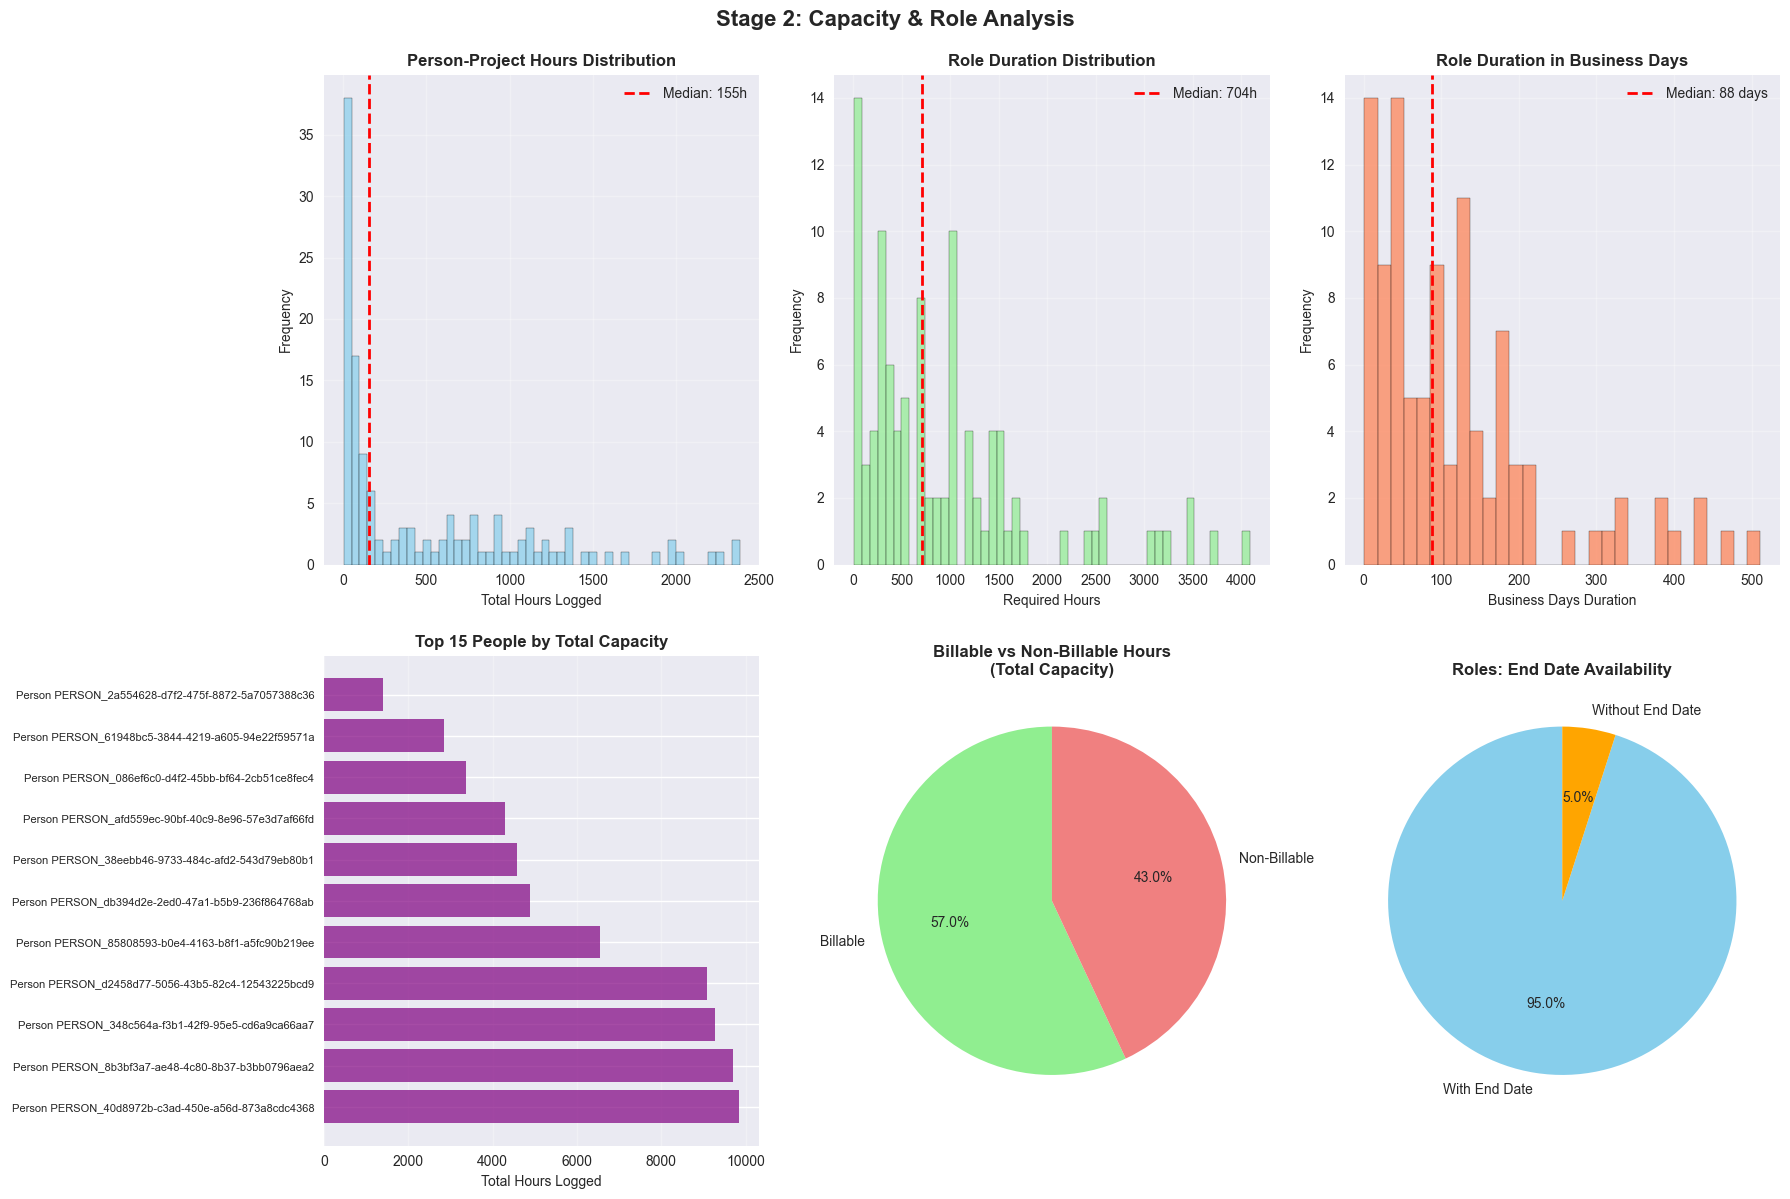


STAGE 2 SETUP COMPLETE

✓ Time entries enriched with master_person_id
✓ Person-project capacity tracker created
✓ Roles processed with duration calculations

Next Step:
  • Use person_capacity_tracker to assign roles iteratively
  • Track remaining_hours as roles are assigned
  • Ensure no person is over-allocated on any project



In [7]:
# === STAGE 2: TASK ASSIGNMENT & CAPACITY TRACKING ===
print("="*80)
print("STAGE 2: TASK ASSIGNMENT & CAPACITY TRACKING")
print("="*80)
print("\nAssigning roles to people based on actual work capacity and project involvement...\n")

# --- CONFIGURATION: Work Physics ---
DAILY_WORK_CAPACITY_HOURS = 8
print(f"Work Model Assumptions:")
print(f"  • Daily work capacity: {DAILY_WORK_CAPACITY_HOURS} hours")
print(f"  • Role duration calculated using business days only")
print()

# --- STEP 2A: ENRICH TIME ENTRIES WITH MASTER PERSON ID ---
print("=== STEP 2A: ENRICHING TIME ENTRIES WITH MASTER PERSON ID ===\n")

# Use the identity map from Stage 1 to add master_person_id to time entries
df_time_entries_enriched = pd.merge(
    df_time_entries, 
    df_master_identity_map[['user_id', 'master_person_id']], 
    on='user_id', 
    how='left'
)

# Drop entries that couldn't be mapped (unmatched users)
df_time_entries_enriched.dropna(subset=['master_person_id'], inplace=True)

print(f"✓ Enriched {len(df_time_entries_enriched)} time entries with master_person_id")
print(f"✓ Dropped {len(df_time_entries) - len(df_time_entries_enriched)} unmapped entries")
print()

print("Sample of enriched time entries:")
display(df_time_entries_enriched[['master_person_id', 'user_id', 'project_id', 'dt', 'hours', 'billable']].head(10))

# --- STEP 2B: CREATE PERSON-PROJECT CAPACITY TRACKER ---
print("\n=== STEP 2B: CREATING PERSON-PROJECT CAPACITY TRACKER ===\n")

# Aggregate capacity by person and project
person_capacity_tracker = df_time_entries_enriched.groupby(['master_person_id', 'project_id']).agg(
    total_hours_logged=('hours', 'sum'),
    billable_hours=('hours', lambda x: x[df_time_entries_enriched.loc[x.index, 'billable'] == True].sum()),
    first_day_on_project=('dt', 'min'),
    last_day_on_project=('dt', 'max'),
    days_worked=('dt', 'nunique')
).reset_index()

# Calculate working days span (approximation using business days)
person_capacity_tracker['project_duration_business_days'] = person_capacity_tracker.apply(
    lambda row: np.busday_count(
        row['first_day_on_project'].date(),
        row['last_day_on_project'].date()
    ), axis=1
)

# Initialize remaining hours (this will be updated during role assignment)
person_capacity_tracker['remaining_hours'] = person_capacity_tracker['total_hours_logged']
person_capacity_tracker['roles_assigned_count'] = 0

print(f"✓ Created capacity tracker for {len(person_capacity_tracker)} person-project combinations")
print()

print("Person-Project Capacity Tracker (Top 20 by hours):")
display(person_capacity_tracker.nlargest(20, 'total_hours_logged'))

# --- STEP 2C: PROCESS ROLES TABLE WITH DURATION CALCULATION ---
print("\n=== STEP 2C: PROCESSING ROLES WITH DURATION CALCULATION ===\n")

# Load roles end dates if not already loaded
if 'df_roles_end' not in locals():
    df_roles_end = pd.read_csv(data_dir / "notion_roles_enddates.csv")
    print(f"✓ Roles end dates loaded: {df_roles_end.shape}")

# Merge roles with end dates
df_roles_enriched = pd.merge(
    df_roles, 
    df_roles_end[['role_id', 'enddate']], 
    on='role_id', 
    how='left'
)

# Convert dates to datetime
df_roles_enriched['startdate'] = pd.to_datetime(df_roles_enriched['startdate'], errors='coerce')
df_roles_enriched['enddate'] = pd.to_datetime(df_roles_enriched['enddate'], errors='coerce')

# Calculate required hours for each role based on business days
# For roles without end dates, estimate based on average duration or set to 0
df_roles_enriched['has_enddate'] = df_roles_enriched['enddate'].notna()

# Calculate business days for roles with both start and end dates
def calculate_required_hours(row):
    if pd.isna(row['startdate']) or pd.isna(row['enddate']):
        # If missing dates, estimate based on average or return minimum
        return DAILY_WORK_CAPACITY_HOURS * 5  # Default to 1 week
    
    try:
        business_days = np.busday_count(
            row['startdate'].date(),
            row['enddate'].date()
        )
        # Ensure at least 1 day
        business_days = max(1, business_days)
        return business_days * DAILY_WORK_CAPACITY_HOURS
    except:
        return DAILY_WORK_CAPACITY_HOURS * 5  # Fallback to 1 week

df_roles_enriched['required_hours'] = df_roles_enriched.apply(calculate_required_hours, axis=1)
df_roles_enriched['business_days_duration'] = (df_roles_enriched['required_hours'] / DAILY_WORK_CAPACITY_HOURS).astype(int)

print(f"✓ Calculated required hours for {len(df_roles_enriched)} roles")
print(f"✓ Roles with end dates: {df_roles_enriched['has_enddate'].sum()}")
print(f"✓ Roles without end dates: {(~df_roles_enriched['has_enddate']).sum()}")
print()

# Sort roles chronologically for realistic assignment
df_roles_enriched.sort_values(by='startdate', inplace=True)

print("Roles with Duration Calculations (First 20):")
display(df_roles_enriched[[
    'role_id', 'startdate', 'enddate', 'business_days_duration', 'required_hours', 'has_enddate'
]].head(20))

# --- STEP 2D: STATISTICAL SUMMARY ---
print("\n=== STEP 2D: CAPACITY & ROLE STATISTICS ===\n")

print("Person-Project Capacity Statistics:")
capacity_stats = person_capacity_tracker[['total_hours_logged', 'billable_hours', 'days_worked', 'project_duration_business_days']].describe()
print(capacity_stats)

print("\nRole Duration Statistics:")
role_stats = df_roles_enriched[['required_hours', 'business_days_duration']].describe()
print(role_stats)

print("\nTotal Capacity Available:")
total_capacity = person_capacity_tracker['total_hours_logged'].sum()
print(f"  • Total hours logged across all person-project combinations: {total_capacity:,.0f}h")
print(f"  • Total person-project combinations: {len(person_capacity_tracker)}")

print("\nTotal Role Requirements:")
total_required = df_roles_enriched['required_hours'].sum()
print(f"  • Total hours required for all roles: {total_required:,.0f}h")
print(f"  • Total roles to assign: {len(df_roles_enriched)}")
print(f"  • Average hours per role: {df_roles_enriched['required_hours'].mean():.1f}h")

print("\nCapacity vs. Demand:")
capacity_ratio = total_capacity / total_required if total_required > 0 else 0
print(f"  • Capacity/Demand Ratio: {capacity_ratio:.2f}x")
if capacity_ratio > 1:
    print(f"  • Surplus capacity: {(total_capacity - total_required):,.0f}h ({((capacity_ratio - 1) * 100):.1f}%)")
else:
    print(f"  • Capacity deficit: {(total_required - total_capacity):,.0f}h ({((1 - capacity_ratio) * 100):.1f}%)")

# --- STEP 2E: VISUALIZATION ---
print("\n=== STEP 2E: VISUALIZATION ===\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribution of hours per person-project combination
ax1 = axes[0, 0]
ax1.hist(person_capacity_tracker['total_hours_logged'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(person_capacity_tracker['total_hours_logged'].median(), color='red', 
            linestyle='--', linewidth=2, label=f'Median: {person_capacity_tracker["total_hours_logged"].median():.0f}h')
ax1.set_xlabel('Total Hours Logged', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_title('Person-Project Hours Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Role duration distribution
ax2 = axes[0, 1]
ax2.hist(df_roles_enriched['required_hours'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
ax2.axvline(df_roles_enriched['required_hours'].median(), color='red', 
            linestyle='--', linewidth=2, label=f'Median: {df_roles_enriched["required_hours"].median():.0f}h')
ax2.set_xlabel('Required Hours', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('Role Duration Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Business days distribution for roles
ax3 = axes[0, 2]
ax3.hist(df_roles_enriched['business_days_duration'], bins=30, color='coral', edgecolor='black', alpha=0.7)
ax3.axvline(df_roles_enriched['business_days_duration'].median(), color='red', 
            linestyle='--', linewidth=2, label=f'Median: {df_roles_enriched["business_days_duration"].median():.0f} days')
ax3.set_xlabel('Business Days Duration', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Role Duration in Business Days', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Top 15 people by total capacity
ax4 = axes[1, 0]
top_people = person_capacity_tracker.groupby('master_person_id')['total_hours_logged'].sum().nlargest(15)
ax4.barh(range(len(top_people)), top_people.values, color='purple', alpha=0.7)
ax4.set_yticks(range(len(top_people)))
ax4.set_yticklabels([f"Person {pid}" for pid in top_people.index], fontsize=8)
ax4.set_xlabel('Total Hours Logged', fontsize=10)
ax4.set_title('Top 15 People by Total Capacity', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Billable vs Non-Billable hours
ax5 = axes[1, 1]
billable_total = person_capacity_tracker['billable_hours'].sum()
non_billable_total = person_capacity_tracker['total_hours_logged'].sum() - billable_total
ax5.pie([billable_total, non_billable_total], 
        labels=['Billable', 'Non-Billable'],
        autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'],
        startangle=90)
ax5.set_title('Billable vs Non-Billable Hours\n(Total Capacity)', fontsize=12, fontweight='bold')

# 6. Roles with vs without end dates
ax6 = axes[1, 2]
has_enddate_count = df_roles_enriched['has_enddate'].sum()
no_enddate_count = len(df_roles_enriched) - has_enddate_count
ax6.pie([has_enddate_count, no_enddate_count],
        labels=['With End Date', 'Without End Date'],
        autopct='%1.1f%%',
        colors=['skyblue', 'orange'],
        startangle=90)
ax6.set_title('Roles: End Date Availability', fontsize=12, fontweight='bold')

plt.suptitle('Stage 2: Capacity & Role Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# --- SUMMARY ---
print("\n" + "="*80)
print("STAGE 2 SETUP COMPLETE")
print("="*80)
print()
print("✓ Time entries enriched with master_person_id")
print("✓ Person-project capacity tracker created")
print("✓ Roles processed with duration calculations")
print()
print("Next Step:")
print("  • Use person_capacity_tracker to assign roles iteratively")
print("  • Track remaining_hours as roles are assigned")
print("  • Ensure no person is over-allocated on any project")
print()
print("="*80)

# STAGE 3: Unified Assignment Engine (Greedy Algorithm)

This cell implements a sophisticated, cost-based greedy algorithm to assign roles to people. Instead of finding a single "optimal" solution (which is computationally expensive), it iteratively makes the "best possible" choice at each step until all roles are assigned or no valid assignments remain.

### Core Concepts

-   **Candidate Pool**: The algorithm first generates a massive list (`global_candidate_pool`) of every possible way each role could be assigned to a person. This includes assignments to a specific project a person worked on, or to a person's general "Other" work capacity.
-   **Cost Function**: Every potential assignment in the pool is given a `base_cost`. This cost is a weighted sum of penalties:
    -   **Capacity Cost**: Penalty for assigning a role that requires more hours than the person has available.
    -   **Temporal Cost**: Penalty if the role's dates don't align well with the person's work history on that project.
    -   **Other Work Tax**: A flat penalty for not assigning to a specific project, making project-based assignments more desirable.
-   **Dynamic Costing**: In each iteration, a `schedule_cost` is added to the `base_cost`. This is a high penalty applied if the candidate assignment overlaps with a role already given to that person, discouraging double-booking.
-   **Greedy Selection**: In each loop, the algorithm finds the candidate with the lowest `dynamic_cost` across all remaining roles and makes that assignment permanently.

---

### Step-by-Step Execution

1.  **Setup (3A)**:
    -   **`person_project_capacity`**: A copy of the capacity tracker is created to track remaining hours for each person *on each project*.
    -   **`person_total_capacity`**: A second tracker is created to monitor each person's *total* remaining hours, irrespective of the project. This is for "Other" assignments.
    -   **`person_schedule`**: A dictionary is initialized to store the date ranges of roles assigned to each person. This is used to detect and penalize schedule conflicts.

2.  **Generate Global Candidate Pool (3B)**:
    -   The code iterates through every role and every person, creating all potential `(role, person)` pairings.
    -   For each pairing, it calculates a `base_cost` based on how well the person's capacity and project history fit the role's requirements.
    -   Two types of candidates are created for each role:
        1.  **Project-Based**: Matching the role to a person who worked on that specific project.
        2.  **"Other" Work**: Matching the role to a person's general availability, with an added `OTHER_WORK_TAX` to make it less attractive.
    -   The result is a large DataFrame, `df_candidate_pool`, containing all possibilities.

3.  **Iterative Greedy Assignment (3C)**:
    -   The algorithm enters a `while` loop that continues as long as there are roles left to assign.
    -   **Inside the loop**:
        1.  **Filter**: It considers only the candidates for roles that haven't been assigned yet.
        2.  **Dynamic Costing**: It calculates the `schedule_cost` for every candidate by checking for overlaps in the `person_schedule`. The `dynamic_cost` is then `base_cost + schedule_cost`.
        3.  **Selection**: It finds the single candidate with the **lowest `dynamic_cost`** in the entire pool. This is the "best" available move.
        4.  **Assignment**: The best candidate is recorded in `final_assignments`, along with flags for whether it caused a capacity or schedule violation.
        5.  **State Update**:
            -   The assigned role is removed from the `roles_to_assign` set.
            -   The person's schedule is updated with the new role's dates.
            -   The person's remaining hours (in either the project-specific or total capacity tracker) are reduced. **Note: Hours can go negative**, indicating an overallocation.
    -   The loop repeats, making the next best choice based on the updated state.

### Final Output

-   **`df_role_assignments`**: A DataFrame containing the final list of assignments, detailing which person and project each role was assigned to, the final cost, and any violations that occurred.
-   **`df_unassigned_roles`**: A list of roles that could not be assigned because no valid candidates were left.

In [8]:
print("\n--- STAGE 2: Running the UNIFIED Assignment Engine ---")

# --- 3A: Setup for Unified Assignment ---
# We use the same capacity trackers, but they will be updated in a single loop
person_project_capacity = person_capacity_tracker.copy() # For project-specific hours
person_project_capacity.rename(columns={'project_id': 'projectID'}, inplace=True)  # Fix column name

person_total_capacity = df_time_entries_enriched.groupby('master_person_id')['hours'].sum().reset_index()
person_total_capacity.rename(columns={'hours': 'total_logged_hours'}, inplace=True)
person_total_capacity['remaining_total_hours'] = person_total_capacity['total_logged_hours']

# A single schedule tracker for all assignments
person_schedule = {person_id: [] for person_id in person_total_capacity['master_person_id']}

# Add role date columns to df_roles_enriched for easier access
df_roles_enriched['role_start_date'] = df_roles_enriched['startdate']
df_roles_enriched['role_end_date'] = df_roles_enriched['enddate']

# --- 3B: Generate a GLOBAL Candidate Pool ---
print("[3B] Generating a global pool of all possible role assignments...")
global_candidate_pool = []

# Define weights for our cost function. You can tune these.
W_CAPACITY = 1.5 # Weight for capacity violations
W_TEMPORAL = 1.0 # Weight for temporal misalignment
OTHER_WORK_TAX = 50 # Base cost for assigning work as 'Other'
W_SCHEDULE_CONFLICT = 200 # A high penalty for double-booking a person

for role in df_roles_enriched.itertuples():
    # --- Candidate Type 1: Project-Based Assignments ---
    for p_can in person_project_capacity.itertuples():
        # Temporal Overlap Check (still a useful pre-filter)
        if pd.isna(role.role_start_date) or pd.isna(role.role_end_date):
            continue
            
        if not ((role.role_start_date <= p_can.last_day_on_project) and 
                (role.role_end_date >= p_can.first_day_on_project)):
            continue
            
        # Calculate Costs (these are now "base" costs before dynamic checks)
        capacity_cost = W_CAPACITY * max(0, role.required_hours - p_can.remaining_hours)
        
        # Calculate how many days of the role fall outside the person's work window on the project
        non_overlap_days_start = max(0, (p_can.first_day_on_project - role.role_start_date).days)
        non_overlap_days_end = max(0, (role.role_end_date - p_can.last_day_on_project).days)
        temporal_cost = W_TEMPORAL * (non_overlap_days_start + non_overlap_days_end)
        
        base_cost = capacity_cost + temporal_cost
        
        global_candidate_pool.append({
            'role_id': role.role_id,
            'assign_to_person': p_can.master_person_id,
            'assign_to_project': p_can.projectID,
            'assignment_type': 'Project',
            'base_cost': base_cost,
            'role_hours': role.required_hours,
            'role_start': role.role_start_date,
            'role_end': role.role_end_date,
        })

    # --- Candidate Type 2: Other/Non-Project Assignments ---
    for t_can in person_total_capacity.itertuples():
        if pd.isna(role.role_start_date) or pd.isna(role.role_end_date):
            continue
            
        capacity_cost = W_CAPACITY * max(0, role.required_hours - t_can.remaining_total_hours)
        base_cost = capacity_cost + OTHER_WORK_TAX
        
        global_candidate_pool.append({
            'role_id': role.role_id,
            'assign_to_person': t_can.master_person_id,
            'assign_to_project': 'Other',
            'assignment_type': 'Other',
            'base_cost': base_cost,
            'role_hours': role.required_hours,
            'role_start': role.role_start_date,
            'role_end': role.role_end_date,
        })

df_candidate_pool = pd.DataFrame(global_candidate_pool)
print(f"Generated {len(df_candidate_pool):,} total possible assignments to evaluate.")


# --- 3C: Iterative Greedy Assignment with Dynamic Costing ---
print("[3C] Iteratively selecting the best possible assignment with dynamic costing...")
final_assignments = []
roles_to_assign = set(df_roles_enriched['role_id'])

iteration = 0
while roles_to_assign:
    iteration += 1
    if iteration % 100 == 0:
        print(f"  Iteration {iteration}: {len(roles_to_assign)} roles remaining...")
    
    # Filter the pool to only unassigned roles
    current_candidates = df_candidate_pool[df_candidate_pool['role_id'].isin(roles_to_assign)].copy()
    
    if current_candidates.empty:
        print(f"Stopping. No valid candidates left for the remaining {len(roles_to_assign)} roles.")
        break

    # --- DYNAMIC COST CALCULATION ---
    def get_conflict_cost(row):
        for start, end in person_schedule.get(row['assign_to_person'], []):
            if (row['role_start'] <= end) and (row['role_end'] >= start):
                return W_SCHEDULE_CONFLICT
        return 0
    
    current_candidates['schedule_cost'] = current_candidates.apply(get_conflict_cost, axis=1)
    current_candidates['dynamic_cost'] = current_candidates['base_cost'] + current_candidates['schedule_cost']
    
    # --- SELECTION ---
    best_candidate = current_candidates.sort_values('dynamic_cost', ascending=True).iloc[0]
    
    # --- GATHER INFO & FLAGS FOR REPORTING ---
    role_id = best_candidate['role_id']
    person_id = best_candidate['assign_to_person']
    project_id = best_candidate['assign_to_project']
    assign_type = best_candidate['assignment_type']
    role_hours = best_candidate['role_hours']
    
    # Flag 1: Schedule Conflict
    had_schedule_conflict = best_candidate['schedule_cost'] > 0
    
    # Flag 2: Capacity Violation
    capacity_violation_hours = 0
    if assign_type == 'Project':
        rem_hours = person_project_capacity.loc[
            (person_project_capacity['master_person_id'] == person_id) &
            (person_project_capacity['projectID'] == project_id),
            'remaining_hours'
        ].iloc[0]
        capacity_violation_hours = max(0, role_hours - rem_hours)
    else: # 'Other'
        rem_hours = person_total_capacity.loc[
            person_total_capacity['master_person_id'] == person_id,
            'remaining_total_hours'
        ].iloc[0]
        capacity_violation_hours = max(0, role_hours - rem_hours)

    # --- MAKE THE ASSIGNMENT ---
    final_assignments.append({
        'role_id': role_id,
        'assigned_to_person': person_id,
        'assigned_to_project': project_id,
        'assignment_type': assign_type,
        'assignment_cost': best_candidate['dynamic_cost'],
        'required_hours': role_hours,
        'capacity_violation_hours': capacity_violation_hours,
        'had_schedule_conflict': had_schedule_conflict
    })
    
    # --- UPDATE STATE (Capacities can now go negative) ---
    person_schedule[person_id].append((best_candidate['role_start'], best_candidate['role_end']))
    roles_to_assign.remove(role_id)
    
    if assign_type == 'Project':
        proj_idx = person_project_capacity[
            (person_project_capacity['master_person_id'] == person_id) &
            (person_project_capacity['projectID'] == project_id)
        ].index[0]
        person_project_capacity.loc[proj_idx, 'remaining_hours'] -= role_hours
    
    total_idx = person_total_capacity[person_total_capacity['master_person_id'] == person_id].index[0]
    person_total_capacity.loc[total_idx, 'remaining_total_hours'] -= role_hours

df_role_assignments = pd.DataFrame(final_assignments)
df_unassigned_roles = df_roles_enriched[df_roles_enriched['role_id'].isin(roles_to_assign)]

print(f"\n✓ Assignment complete!")
print(f"  Total assigned: {len(df_role_assignments)}")
print(f"  Total unassigned: {len(df_unassigned_roles)}")
print(f"  Assignment rate: {len(df_role_assignments) / len(df_roles_enriched) * 100:.2f}%")


--- STAGE 2: Running the UNIFIED Assignment Engine ---
[3B] Generating a global pool of all possible role assignments...
Generated 4,926 total possible assignments to evaluate.
[3C] Iteratively selecting the best possible assignment with dynamic costing...
Stopping. No valid candidates left for the remaining 5 roles.

✓ Assignment complete!
  Total assigned: 96
  Total unassigned: 5
  Assignment rate: 95.05%


# SENSITIVITY ANALYSIS: Tuning the Assignment Algorithm

This cell performs a sensitivity analysis to understand how changing the cost parameters of the assignment algorithm affects its performance. The goal is to find the optimal set of weights that maximizes the number of assigned roles while minimizing undesirable outcomes like schedule conflicts and capacity violations.

---

### Core Components

1.  **`run_assignment_simulation` Function**:
    -   This is a self-contained wrapper that runs the entire greedy assignment algorithm from the previous stage.
    -   Crucially, it accepts a `params` dictionary which contains the cost weights (`W_CAPACITY`, `W_TEMPORAL`, `OTHER_WORK_TAX`, `W_SCHEDULE_CONFLICT`).
    -   Instead of just returning the assignments, it calculates and returns a dictionary of key performance indicators (KPIs) for that specific run, such as the total number of assignments, the number of conflicts, and the average cost.

2.  **`scenarios` List**:
    -   A list of predefined scenarios is created. Each scenario is a dictionary containing a descriptive name and a unique set of cost parameters.
    -   Examples of scenarios include:
        -   **`Current (Baseline)`**: The default parameters used in the initial run.
        -   **`Strict Capacity Enforcement`**: Sets a very high penalty (`W_CAPACITY`) for exceeding a person's available hours.
        -   **`Strict Schedule (No Overlaps)`**: Sets a massive penalty (`W_SCHEDULE_CONFLICT`) for assigning overlapping roles to the same person.
        -   **`Prefer Project Assignments`**: Increases the `OTHER_WORK_TAX` to make assigning roles to a person's general capacity less attractive than assigning them to a specific project they worked on.
        -   **`Maximize Assignments (Aggressive)`**: Lowers all penalties to encourage the algorithm to make assignments even if they are not "perfect".

3.  **Simulation and Reporting**:
    -   The code iterates through each scenario in the `scenarios` list, running the full assignment simulation for each one.
    -   The summary KPIs from each run are collected into a final DataFrame, `df_sensitivity_report`. This table allows for a direct, side-by-side comparison of how each parameter set performed.

---

### Analysis and Visualization

The final part of the cell analyzes the results to provide actionable insights:

-   **Top Scenarios**: It programmatically identifies and displays the top 5 scenarios based on two key criteria:
    1.  **Highest Assignment Rate**: Which parameters resulted in the most roles being successfully assigned?
    2.  **Fewest Violations**: Which parameters produced the "cleanest" assignments with the minimum number of capacity violations?

-   **Visual Comparison**: A dashboard with four charts is generated to visually compare the performance of all scenarios across key metrics:
    1.  **Assignment Rate**: How many roles were assigned?
    2.  **Assignment Type**: What was the mix of "Project" vs. "Other" assignments?
    3.  **Capacity Violations**: How many total hours were overallocated?
    4.  **Schedule Conflicts**: How many times was a person double-booked?

-   **Recommendations**: The analysis concludes by comparing the best-performing scenario to the baseline, offering a clear recommendation on whether to adopt a new set of parameters to improve the assignment outcome.

### Business Value

This analysis is critical for fine-tuning the resource allocation model. By testing different strategies (e.g., prioritizing schedule adherence vs. maximizing role coverage), the business can choose the parameter set that best aligns with its operational goals, whether that's ensuring no one is overworked, maximizing the number of staffed roles, or strongly encouraging project-based work.

SENSITIVITY ANALYSIS: ROLE ASSIGNMENT PARAMETERS
Testing how different cost parameters affect assignment outcomes

Defining test scenarios...

Running 10 scenarios...
This may take a few minutes...

[1/10] Running: Current (Baseline)... ✓ (Assigned: 96/101)
[2/10] Running: Strict Capacity Enforcement... ✓ (Assigned: 96/101)
[3/10] Running: Flexible Capacity (Allow Overallocation)... ✓ (Assigned: 96/101)
[4/10] Running: No Capacity Penalty... ✓ (Assigned: 96/101)
[5/10] Running: Strict Schedule (No Overlaps)... ✓ (Assigned: 96/101)
[6/10] Running: Flexible Schedule (Allow Overlaps)... ✓ (Assigned: 96/101)
[7/10] Running: No Schedule Conflict Penalty... ✓ (Assigned: 96/101)
[8/10] Running: Prefer Project Assignments... ✓ (Assigned: 96/101)
[9/10] Running: Prefer Other Work... ✓ (Assigned: 96/101)
[10/10] Running: Maximize Assignments (Aggressive)... ✓ (Assigned: 96/101)

SENSITIVITY ANALYSIS COMPARISON REPORT

=== Full Comparison Table ===



Scenario  Total_Roles  Assigned_Total  \
0                        Current (Baseline)          101              96   
1               Strict Capacity Enforcement          101              96   
2  Flexible Capacity (Allow Overallocation)          101              96   
3                       No Capacity Penalty          101              96   
4             Strict Schedule (No Overlaps)          101              96   
5        Flexible Schedule (Allow Overlaps)          101              96   
6              No Schedule Conflict Penalty          101              96   
7                Prefer Project Assignments          101              96   
8                         Prefer Other Work          101              96   
9         Maximize Assignments (Aggressive)          101              96   

   Assigned_Project  Assigned_Other  Unassigned  Assignment_Rate_%  \
0                64              32           5              95.05   
1                62              34           5              95.05   
2                65              31           5              95.05   
3                67              29           5              95.05   
4                63              33           5              95.05   
5                69              27           5              95.05   
6                83              13           5              95.05   
7                62              34           5              95.05   
8                61              35           5              95.05   
9                66              30           5              95.05   

   Schedule_Conflicts  Capacity_Violations  Total_Violation_Hours  \
0                  19                   41                89619.8   
1                  19                   37               126339.4   
2                  17                   34                62386.4   
3                  20                   54               143534.4   
4                  17                   39               102547.4   
5                  24                   34                75041.1   
6                   0                   45                89499.3   
7                  16                   36                76009.7   
8                  18                   37               120804.2   
9                  22                   38                79451.3   

   Avg_Assignment_Cost  
0                57.10  
1                57.29  
2                53.24  
3                57.89  
4               195.21  
5                27.03  
6                 7.14  
7                69.45  
8                44.79  
9                21.14


=== TOP 5 SCENARIOS BY ASSIGNMENT RATE ===



Scenario  Assignment_Rate_%  \
0                        Current (Baseline)              95.05   
1               Strict Capacity Enforcement              95.05   
2  Flexible Capacity (Allow Overallocation)              95.05   
3                       No Capacity Penalty              95.05   
4             Strict Schedule (No Overlaps)              95.05   

   Assigned_Project  Assigned_Other  Schedule_Conflicts  Total_Violation_Hours  
0                64              32                  19                89619.8  
1                62              34                  19               126339.4  
2                65              31                  17                62386.4  
3                67              29                  20               143534.4  
4                63              33                  17               102547.4


=== SCENARIOS WITH FEWEST VIOLATIONS ===



Scenario  Assignment_Rate_%  \
2  Flexible Capacity (Allow Overallocation)              95.05   
5        Flexible Schedule (Allow Overlaps)              95.05   
7                Prefer Project Assignments              95.05   
9         Maximize Assignments (Aggressive)              95.05   
6              No Schedule Conflict Penalty              95.05   

   Total_Violation_Hours  Capacity_Violations  Schedule_Conflicts  
2                62386.4                   34                  17  
5                75041.1                   34                  24  
7                76009.7                   36                  16  
9                79451.3                   38                  22  
6                89499.3                   45                   0


=== GENERATING COMPARISON VISUALIZATIONS ===



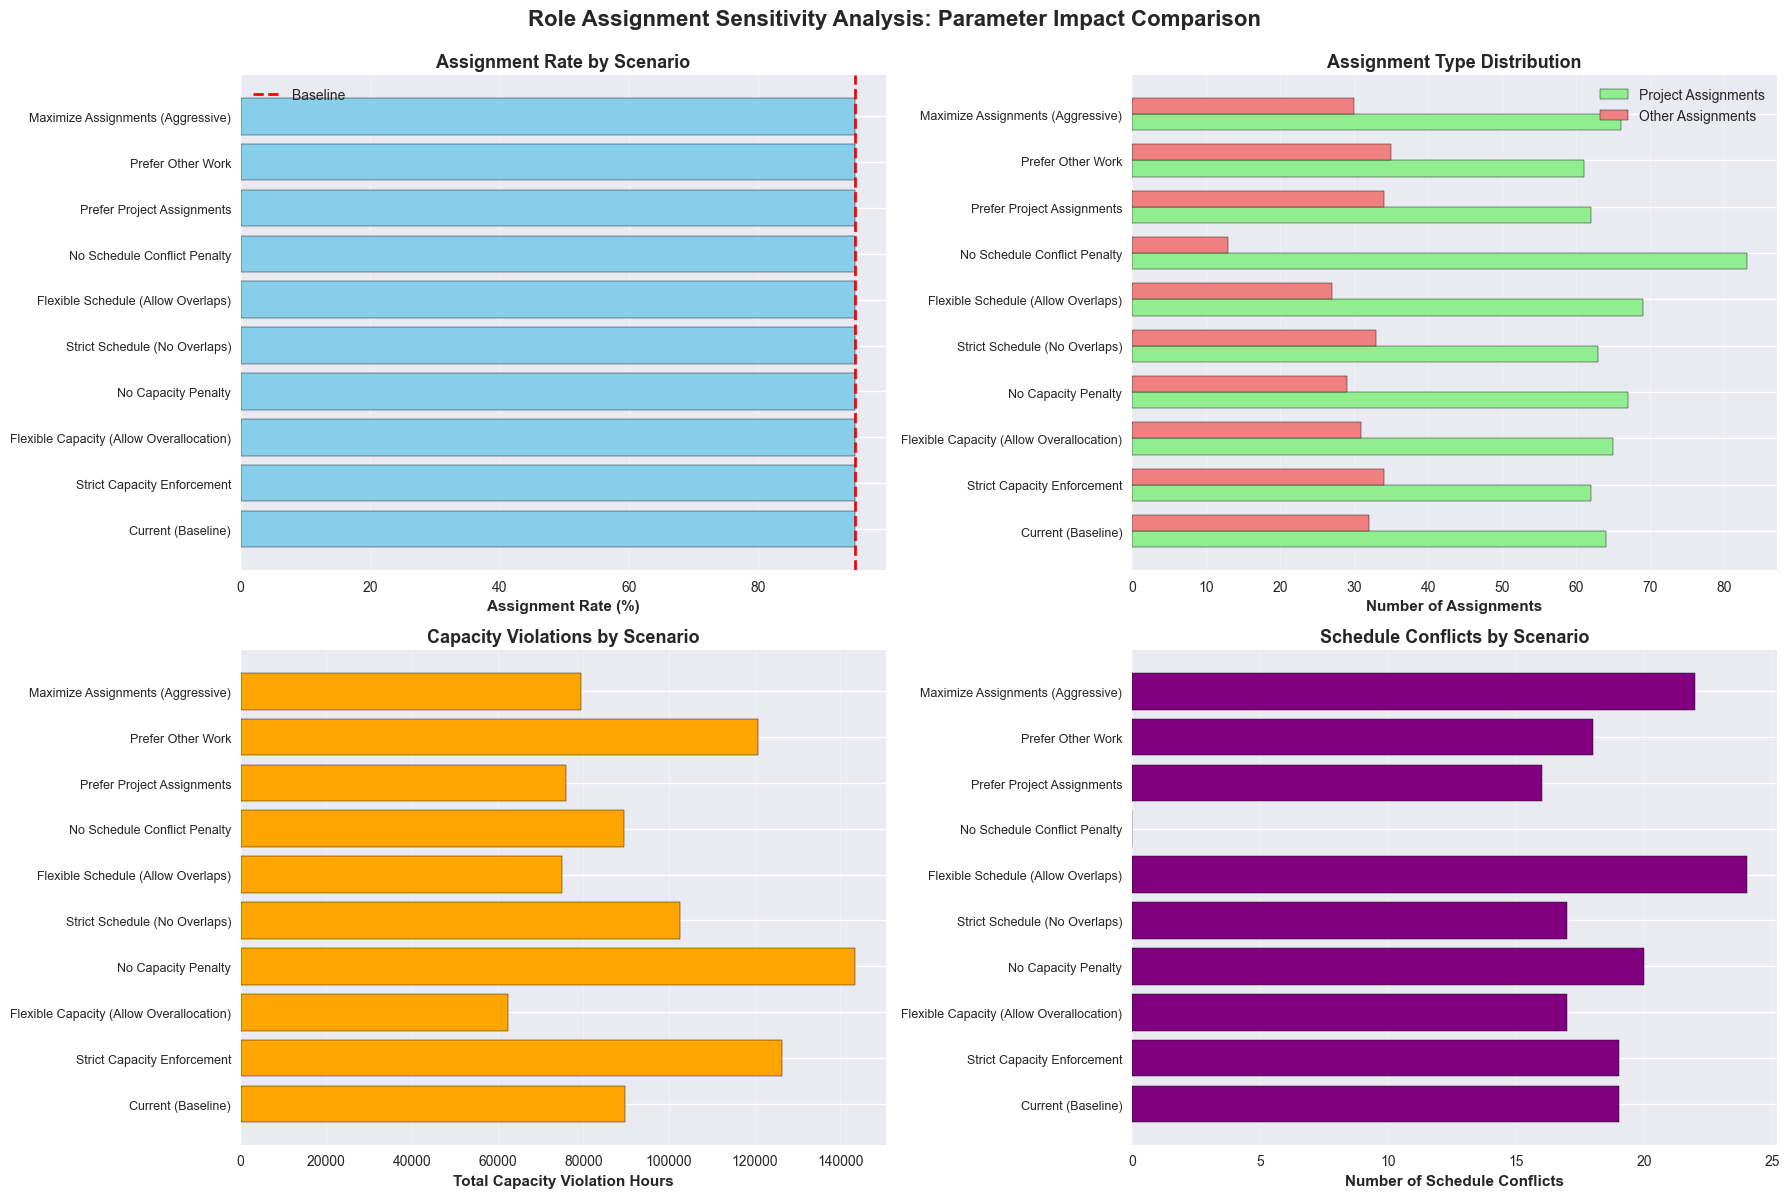


=== SAVING SENSITIVITY ANALYSIS RESULTS ===

✓ Saved sensitivity analysis to: ..\data\processed\linking_tables\analysis__sensitivity_assignment_params__20251007.csv
  Scenarios tested: 10

KEY INSIGHTS FROM SENSITIVITY ANALYSIS

🏆 BEST ASSIGNMENT RATE: Current (Baseline)
   • Assignment Rate: 95.05%
   • Assigned: 96/101
   • Schedule Conflicts: 19
   • Violation Hours: 89619.8h

📊 IMPROVEMENT OVER BASELINE:
   • Baseline Rate: 95.05%
   • Best Rate: 95.05%
   • Improvement: +0.00 percentage points

💡 RECOMMENDATIONS:
   ✓ Current parameters are already optimal

✅ SENSITIVITY ANALYSIS COMPLETE


In [9]:
print("SENSITIVITY ANALYSIS: ROLE ASSIGNMENT PARAMETERS")
print("="*80)
print("Testing how different cost parameters affect assignment outcomes\n")

def run_assignment_simulation(df_roles_enriched, df_time_entries_enriched, person_capacity_tracker, params):
    """
    Self-contained function to run the entire assignment simulation with given parameters.
    Returns summary statistics for comparison.
    """
    # --- Setup ---
    person_project_capacity = person_capacity_tracker.copy()
    person_project_capacity.rename(columns={'project_id': 'projectID'}, inplace=True)
    
    person_total_capacity = df_time_entries_enriched.groupby('master_person_id')['hours'].sum().reset_index()
    person_total_capacity.rename(columns={'hours': 'total_logged_hours'}, inplace=True)
    person_total_capacity['remaining_total_hours'] = person_total_capacity['total_logged_hours']
    
    person_schedule = {person_id: [] for person_id in person_total_capacity['master_person_id']}
    
    # Add role date columns
    df_roles_sim = df_roles_enriched.copy()
    df_roles_sim['role_start_date'] = df_roles_sim['startdate']
    df_roles_sim['role_end_date'] = df_roles_sim['enddate']

    # --- Generate Candidate Pool ---
    global_candidate_pool = []
    
    for role in df_roles_sim.itertuples():
        # Project-Based Candidates
        for p_can in person_project_capacity.itertuples():
            if pd.isna(role.role_start_date) or pd.isna(role.role_end_date):
                continue
            if not ((role.role_start_date <= p_can.last_day_on_project) and 
                    (role.role_end_date >= p_can.first_day_on_project)):
                continue
                
            capacity_cost = params['W_CAPACITY'] * max(0, role.required_hours - p_can.remaining_hours)
            non_overlap_days_start = max(0, (p_can.first_day_on_project - role.role_start_date).days)
            non_overlap_days_end = max(0, (role.role_end_date - p_can.last_day_on_project).days)
            temporal_cost = params['W_TEMPORAL'] * (non_overlap_days_start + non_overlap_days_end)
            base_cost = capacity_cost + temporal_cost
            
            global_candidate_pool.append({
                'role_id': role.role_id,
                'assign_to_person': p_can.master_person_id,
                'assign_to_project': p_can.projectID,
                'assignment_type': 'Project',
                'base_cost': base_cost,
                'role_hours': role.required_hours,
                'role_start': role.role_start_date,
                'role_end': role.role_end_date,
            })
            
        # Other/Non-Project Candidates
        for t_can in person_total_capacity.itertuples():
            if pd.isna(role.role_start_date) or pd.isna(role.role_end_date):
                continue
                
            capacity_cost = params['W_CAPACITY'] * max(0, role.required_hours - t_can.remaining_total_hours)
            base_cost = capacity_cost + params['OTHER_WORK_TAX']
            
            global_candidate_pool.append({
                'role_id': role.role_id,
                'assign_to_person': t_can.master_person_id,
                'assign_to_project': 'Other',
                'assignment_type': 'Other',
                'base_cost': base_cost,
                'role_hours': role.required_hours,
                'role_start': role.role_start_date,
                'role_end': role.role_end_date,
            })
            
    df_candidate_pool = pd.DataFrame(global_candidate_pool)

    # --- Iterative Assignment ---
    final_assignments = []
    roles_to_assign = set(df_roles_sim['role_id'])
    
    while roles_to_assign:
        current_candidates = df_candidate_pool[df_candidate_pool['role_id'].isin(roles_to_assign)].copy()
        if current_candidates.empty:
            break
        
        def get_conflict_cost(row):
            for start, end in person_schedule.get(row['assign_to_person'], []):
                if (row['role_start'] <= end) and (row['role_end'] >= start):
                    return params['W_SCHEDULE_CONFLICT']
            return 0
            
        current_candidates['schedule_cost'] = current_candidates.apply(get_conflict_cost, axis=1)
        current_candidates['dynamic_cost'] = current_candidates['base_cost'] + current_candidates['schedule_cost']
        
        best_candidate = current_candidates.sort_values('dynamic_cost', ascending=True).iloc[0]
        
        role_id = best_candidate['role_id']
        person_id = best_candidate['assign_to_person']
        project_id = best_candidate['assign_to_project']
        assign_type = best_candidate['assignment_type']
        role_hours = best_candidate['role_hours']
        
        # Calculate capacity violation
        capacity_violation_hours = 0
        if assign_type == 'Project':
            rem_hours = person_project_capacity.loc[
                (person_project_capacity['master_person_id'] == person_id) & 
                (person_project_capacity['projectID'] == project_id), 
                'remaining_hours'
            ].iloc[0]
            capacity_violation_hours = max(0, role_hours - rem_hours)
        else:
            rem_hours = person_total_capacity.loc[
                person_total_capacity['master_person_id'] == person_id, 
                'remaining_total_hours'
            ].iloc[0]
            capacity_violation_hours = max(0, role_hours - rem_hours)
        
        final_assignments.append({
            'role_id': role_id,
            'assigned_to_person': person_id,
            'assigned_to_project': project_id,
            'assignment_type': assign_type,
            'had_schedule_conflict': best_candidate['schedule_cost'] > 0,
            'capacity_violation_hours': capacity_violation_hours,
            'assignment_cost': best_candidate['dynamic_cost'],
        })
        
        # Update state
        person_schedule[person_id].append((best_candidate['role_start'], best_candidate['role_end']))
        roles_to_assign.remove(role_id)
        
        if assign_type == 'Project':
            proj_idx = person_project_capacity[
                (person_project_capacity['master_person_id'] == person_id) & 
                (person_project_capacity['projectID'] == project_id)
            ].index[0]
            person_project_capacity.loc[proj_idx, 'remaining_hours'] -= role_hours
        
        total_idx = person_total_capacity[person_total_capacity['master_person_id'] == person_id].index[0]
        person_total_capacity.loc[total_idx, 'remaining_total_hours'] -= role_hours
    
    # --- Summarize Results ---
    df_results = pd.DataFrame(final_assignments)
    total_roles = len(df_roles_sim)
    assigned_count = len(df_results)
    unassigned_count = len(roles_to_assign)
    
    return {
        "Scenario": params['name'],
        "Total_Roles": total_roles,
        "Assigned_Total": assigned_count,
        "Assigned_Project": len(df_results[df_results['assignment_type'] == 'Project']),
        "Assigned_Other": len(df_results[df_results['assignment_type'] == 'Other']),
        "Unassigned": unassigned_count,
        "Assignment_Rate_%": round((assigned_count / total_roles * 100), 2),
        "Schedule_Conflicts": int(df_results['had_schedule_conflict'].sum()),
        "Capacity_Violations": int((df_results['capacity_violation_hours'] > 0).sum()),
        "Total_Violation_Hours": round(df_results['capacity_violation_hours'].sum(), 1),
        "Avg_Assignment_Cost": round(df_results['assignment_cost'].mean(), 2),
    }

# --- Define Scenarios to Test ---
print("Defining test scenarios...\n")

scenarios = [
    {
        "name": "Current (Baseline)",
        "W_CAPACITY": 1.5,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 50,
        "W_SCHEDULE_CONFLICT": 200
    },
    {
        "name": "Strict Capacity Enforcement",
        "W_CAPACITY": 5.0,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 50,
        "W_SCHEDULE_CONFLICT": 200
    },
    {
        "name": "Flexible Capacity (Allow Overallocation)",
        "W_CAPACITY": 0.5,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 50,
        "W_SCHEDULE_CONFLICT": 200
    },
    {
        "name": "No Capacity Penalty",
        "W_CAPACITY": 0.0,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 50,
        "W_SCHEDULE_CONFLICT": 200
    },
    {
        "name": "Strict Schedule (No Overlaps)",
        "W_CAPACITY": 1.5,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 50,
        "W_SCHEDULE_CONFLICT": 1000
    },
    {
        "name": "Flexible Schedule (Allow Overlaps)",
        "W_CAPACITY": 1.5,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 50,
        "W_SCHEDULE_CONFLICT": 50
    },
    {
        "name": "No Schedule Conflict Penalty",
        "W_CAPACITY": 1.5,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 50,
        "W_SCHEDULE_CONFLICT": 0
    },
    {
        "name": "Prefer Project Assignments",
        "W_CAPACITY": 1.5,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 100,
        "W_SCHEDULE_CONFLICT": 200
    },
    {
        "name": "Prefer Other Work",
        "W_CAPACITY": 1.5,
        "W_TEMPORAL": 1.0,
        "OTHER_WORK_TAX": 20,
        "W_SCHEDULE_CONFLICT": 200
    },
    {
        "name": "Maximize Assignments (Aggressive)",
        "W_CAPACITY": 0.1,
        "W_TEMPORAL": 0.5,
        "OTHER_WORK_TAX": 30,
        "W_SCHEDULE_CONFLICT": 50
    },
]

# --- Run All Scenarios ---
print(f"Running {len(scenarios)} scenarios...")
print("This may take a few minutes...\n")

analysis_results = []
for i, params in enumerate(scenarios, 1):
    print(f"[{i}/{len(scenarios)}] Running: {params['name']}...", end=" ")
    
    result = run_assignment_simulation(
        df_roles_enriched.copy(),
        df_time_entries_enriched.copy(),
        person_capacity_tracker.copy(),
        params
    )
    analysis_results.append(result)
    print(f"✓ (Assigned: {result['Assigned_Total']}/{result['Total_Roles']})")

# --- Create Comparison Report ---
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS COMPARISON REPORT")
print("="*80)

df_sensitivity_report = pd.DataFrame(analysis_results)

# Display full report
print("\n=== Full Comparison Table ===\n")
display(df_sensitivity_report)

# --- Identify Best Scenarios ---
print("\n=== TOP 5 SCENARIOS BY ASSIGNMENT RATE ===\n")
top_by_rate = df_sensitivity_report.nlargest(5, 'Assignment_Rate_%')
display(top_by_rate[['Scenario', 'Assignment_Rate_%', 'Assigned_Project', 'Assigned_Other', 
                      'Schedule_Conflicts', 'Total_Violation_Hours']])

print("\n=== SCENARIOS WITH FEWEST VIOLATIONS ===\n")
min_violations = df_sensitivity_report.nsmallest(5, 'Total_Violation_Hours')
display(min_violations[['Scenario', 'Assignment_Rate_%', 'Total_Violation_Hours', 
                         'Capacity_Violations', 'Schedule_Conflicts']])

# --- Visualization ---
print("\n=== GENERATING COMPARISON VISUALIZATIONS ===\n")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Assignment Rate Comparison
ax1 = axes[0, 0]
scenarios_names = df_sensitivity_report['Scenario']
ax1.barh(range(len(scenarios_names)), df_sensitivity_report['Assignment_Rate_%'], 
         color='skyblue', edgecolor='black')
ax1.set_yticks(range(len(scenarios_names)))
ax1.set_yticklabels(scenarios_names, fontsize=9)
ax1.set_xlabel('Assignment Rate (%)', fontsize=11, fontweight='bold')
ax1.set_title('Assignment Rate by Scenario', fontsize=13, fontweight='bold')
ax1.axvline(x=df_sensitivity_report[df_sensitivity_report['Scenario'] == 'Current (Baseline)']['Assignment_Rate_%'].iloc[0],
            color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Project vs Other Assignments
ax2 = axes[0, 1]
x = np.arange(len(scenarios_names))
width = 0.35
ax2.barh(x - width/2, df_sensitivity_report['Assigned_Project'], width, 
         label='Project Assignments', color='lightgreen', edgecolor='black')
ax2.barh(x + width/2, df_sensitivity_report['Assigned_Other'], width, 
         label='Other Assignments', color='lightcoral', edgecolor='black')
ax2.set_yticks(x)
ax2.set_yticklabels(scenarios_names, fontsize=9)
ax2.set_xlabel('Number of Assignments', fontsize=11, fontweight='bold')
ax2.set_title('Assignment Type Distribution', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

# 3. Violations Comparison
ax3 = axes[1, 0]
ax3.barh(range(len(scenarios_names)), df_sensitivity_report['Total_Violation_Hours'], 
         color='orange', edgecolor='black')
ax3.set_yticks(range(len(scenarios_names)))
ax3.set_yticklabels(scenarios_names, fontsize=9)
ax3.set_xlabel('Total Capacity Violation Hours', fontsize=11, fontweight='bold')
ax3.set_title('Capacity Violations by Scenario', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 4. Schedule Conflicts
ax4 = axes[1, 1]
ax4.barh(range(len(scenarios_names)), df_sensitivity_report['Schedule_Conflicts'], 
         color='purple', edgecolor='black')
ax4.set_yticks(range(len(scenarios_names)))
ax4.set_yticklabels(scenarios_names, fontsize=9)
ax4.set_xlabel('Number of Schedule Conflicts', fontsize=11, fontweight='bold')
ax4.set_title('Schedule Conflicts by Scenario', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle('Role Assignment Sensitivity Analysis: Parameter Impact Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# --- Save Results ---
print("\n=== SAVING SENSITIVITY ANALYSIS RESULTS ===\n")

sensitivity_report_path = output_dir / f"analysis__sensitivity_assignment_params__{timestamp}.csv"
df_sensitivity_report.to_csv(sensitivity_report_path, index=False)
print(f"✓ Saved sensitivity analysis to: {sensitivity_report_path}")
print(f"  Scenarios tested: {len(df_sensitivity_report)}")

# --- Key Insights ---
print("\n" + "="*80)
print("KEY INSIGHTS FROM SENSITIVITY ANALYSIS")
print("="*80)

best_scenario = df_sensitivity_report.loc[df_sensitivity_report['Assignment_Rate_%'].idxmax()]
print(f"\n🏆 BEST ASSIGNMENT RATE: {best_scenario['Scenario']}")
print(f"   • Assignment Rate: {best_scenario['Assignment_Rate_%']:.2f}%")
print(f"   • Assigned: {best_scenario['Assigned_Total']}/{best_scenario['Total_Roles']}")
print(f"   • Schedule Conflicts: {best_scenario['Schedule_Conflicts']}")
print(f"   • Violation Hours: {best_scenario['Total_Violation_Hours']:.1f}h")

baseline = df_sensitivity_report[df_sensitivity_report['Scenario'] == 'Current (Baseline)'].iloc[0]
improvement = best_scenario['Assignment_Rate_%'] - baseline['Assignment_Rate_%']
print(f"\n📊 IMPROVEMENT OVER BASELINE:")
print(f"   • Baseline Rate: {baseline['Assignment_Rate_%']:.2f}%")
print(f"   • Best Rate: {best_scenario['Assignment_Rate_%']:.2f}%")
print(f"   • Improvement: +{improvement:.2f} percentage points")

print("\n💡 RECOMMENDATIONS:")
if best_scenario['Scenario'] == 'Current (Baseline)':
    print("   ✓ Current parameters are already optimal")
else:
    print(f"   ✓ Consider switching to '{best_scenario['Scenario']}' parameters")
    print(f"   ✓ This could assign {int(best_scenario['Assigned_Total'] - baseline['Assigned_Total'])} more roles")

print("\n" + "="*80)
print("✅ SENSITIVITY ANALYSIS COMPLETE")
print("="*80)

TEMPORAL CAPACITY VS DEMAND ANALYSIS

Analyzing role hour demands vs. available people capacity over time...

=== STEP 1: PREPARING TIME SERIES DATA ===

✓ Date range: 2020-08-03 00:00:00 to 2026-06-30 00:00:00
✓ Total unique dates: 1398
✓ Created daily timeline with 2158 days

=== STEP 2: CALCULATING CUMULATIVE ROLE HOURS DEMAND ===

Sampling every 7 days: 349 samples
Processing date 1/349: 2020-08-08
Processing date 51/349: 2021-06-15
Processing date 101/349: 2022-04-22
Processing date 151/349: 2023-02-22
Processing date 201/349: 2023-12-29
Processing date 251/349: 2024-10-29
Processing date 301/349: 2025-09-01

✓ Calculated role demand for 349 sample dates

=== STEP 3: CALCULATING CUMULATIVE PEOPLE CAPACITY ===

Processing date 1/349: 2020-08-08
Processing date 51/349: 2021-06-15
Processing date 101/349: 2022-04-22
Processing date 151/349: 2023-02-22
Processing date 201/349: 2023-12-29
Processing date 251/349: 2024-10-29
Processing date 301/349: 2025-09-01

✓ Calculated people capac

date  total_role_hours_demand  active_roles_count  \
0  2020-08-08                        0                   0   
1  2020-08-15                        0                   0   
2  2020-08-22                        0                   0   
3  2020-08-29                        0                   0   
4  2020-09-01                        0                   0   
5  2020-09-08                        0                   0   
6  2020-09-15                        0                   0   
7  2020-09-22                        0                   0   
8  2020-09-29                        0                   0   
9  2020-10-01                     1488                   1   
10 2020-10-08                     1488                   1   
11 2020-10-15                     1488                   1   
12 2020-10-22                     1488                   1   
13 2020-10-29                     1488                   1   
14 2020-11-01                     1488                   1   
15 2020-11-08                     1488                   1   
16 2020-11-15                     1488                   1   
17 2020-11-22                     1488                   1   
18 2020-11-29                     1488                   1   
19 2020-12-01                     1488                   1   

    total_people_hours_available  active_people_count  \
0                           80.0                    2   
1                          160.0                    2   
2                          240.0                    2   
3                          320.0                    2   
4                          352.0                    2   
5                          432.0                    2   
6                          512.0                    2   
7                          592.0                    2   
8                          672.0                    2   
9                          712.0                    3   
10                         828.0                    3   
11                         946.0                    3   
12                        1066.0                    3   
13                        1218.0                    4   
14                        1248.0                    4   
15                        1408.0                    4   
16                        1568.0                    4   
17                        1728.0                    4   
18                        1888.0                    4   
19                        1952.0                    4   

    capacity_utilization_ratio  capacity_surplus_deficit  
0                     0.000000                      80.0  
1                     0.000000                     160.0  
2                     0.000000                     240.0  
3                     0.000000                     320.0  
4                     0.000000                     352.0  
5                     0.000000                     432.0  
6                     0.000000                     512.0  
7                     0.000000                     592.0  
8                     0.000000                     672.0  
9                   208.988764                    -776.0  
10                  179.710145                    -660.0  
11                  157.293869                    -542.0  
12                  139.587242                    -422.0  
13                  122.167488                    -270.0  
14                  119.230769                    -240.0  
15                  105.681818                     -80.0  
16                   94.897959                      80.0  
17                   86.111111                     240.0  
18                   78.813559                     400.0  
19                   76.229508                     464.0


=== STEP 5: KEY STATISTICS ===

Overall Metrics:
  • Total role hours demand (cumulative): 33,200h
  • Total people hours available (cumulative): 65,796h
  • Final capacity surplus/deficit: 62,068h
  • Final utilization ratio: 5.67%

Critical Periods:
  • Periods with capacity deficit: 65
  • Worst deficit: -4,414h on 2022-01-01

  • Periods with over-utilization (>100%): 65
  • Peak utilization: 208.99%

=== STEP 6: VISUALIZATION ===



C:\Users\guine\AppData\Local\Temp\ipykernel_23120\3375815635.py:256: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\guine\Documents\BC#4\Hyper_python\BI project\Data-Edge-BI-analysis\Data-Edge-BI-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


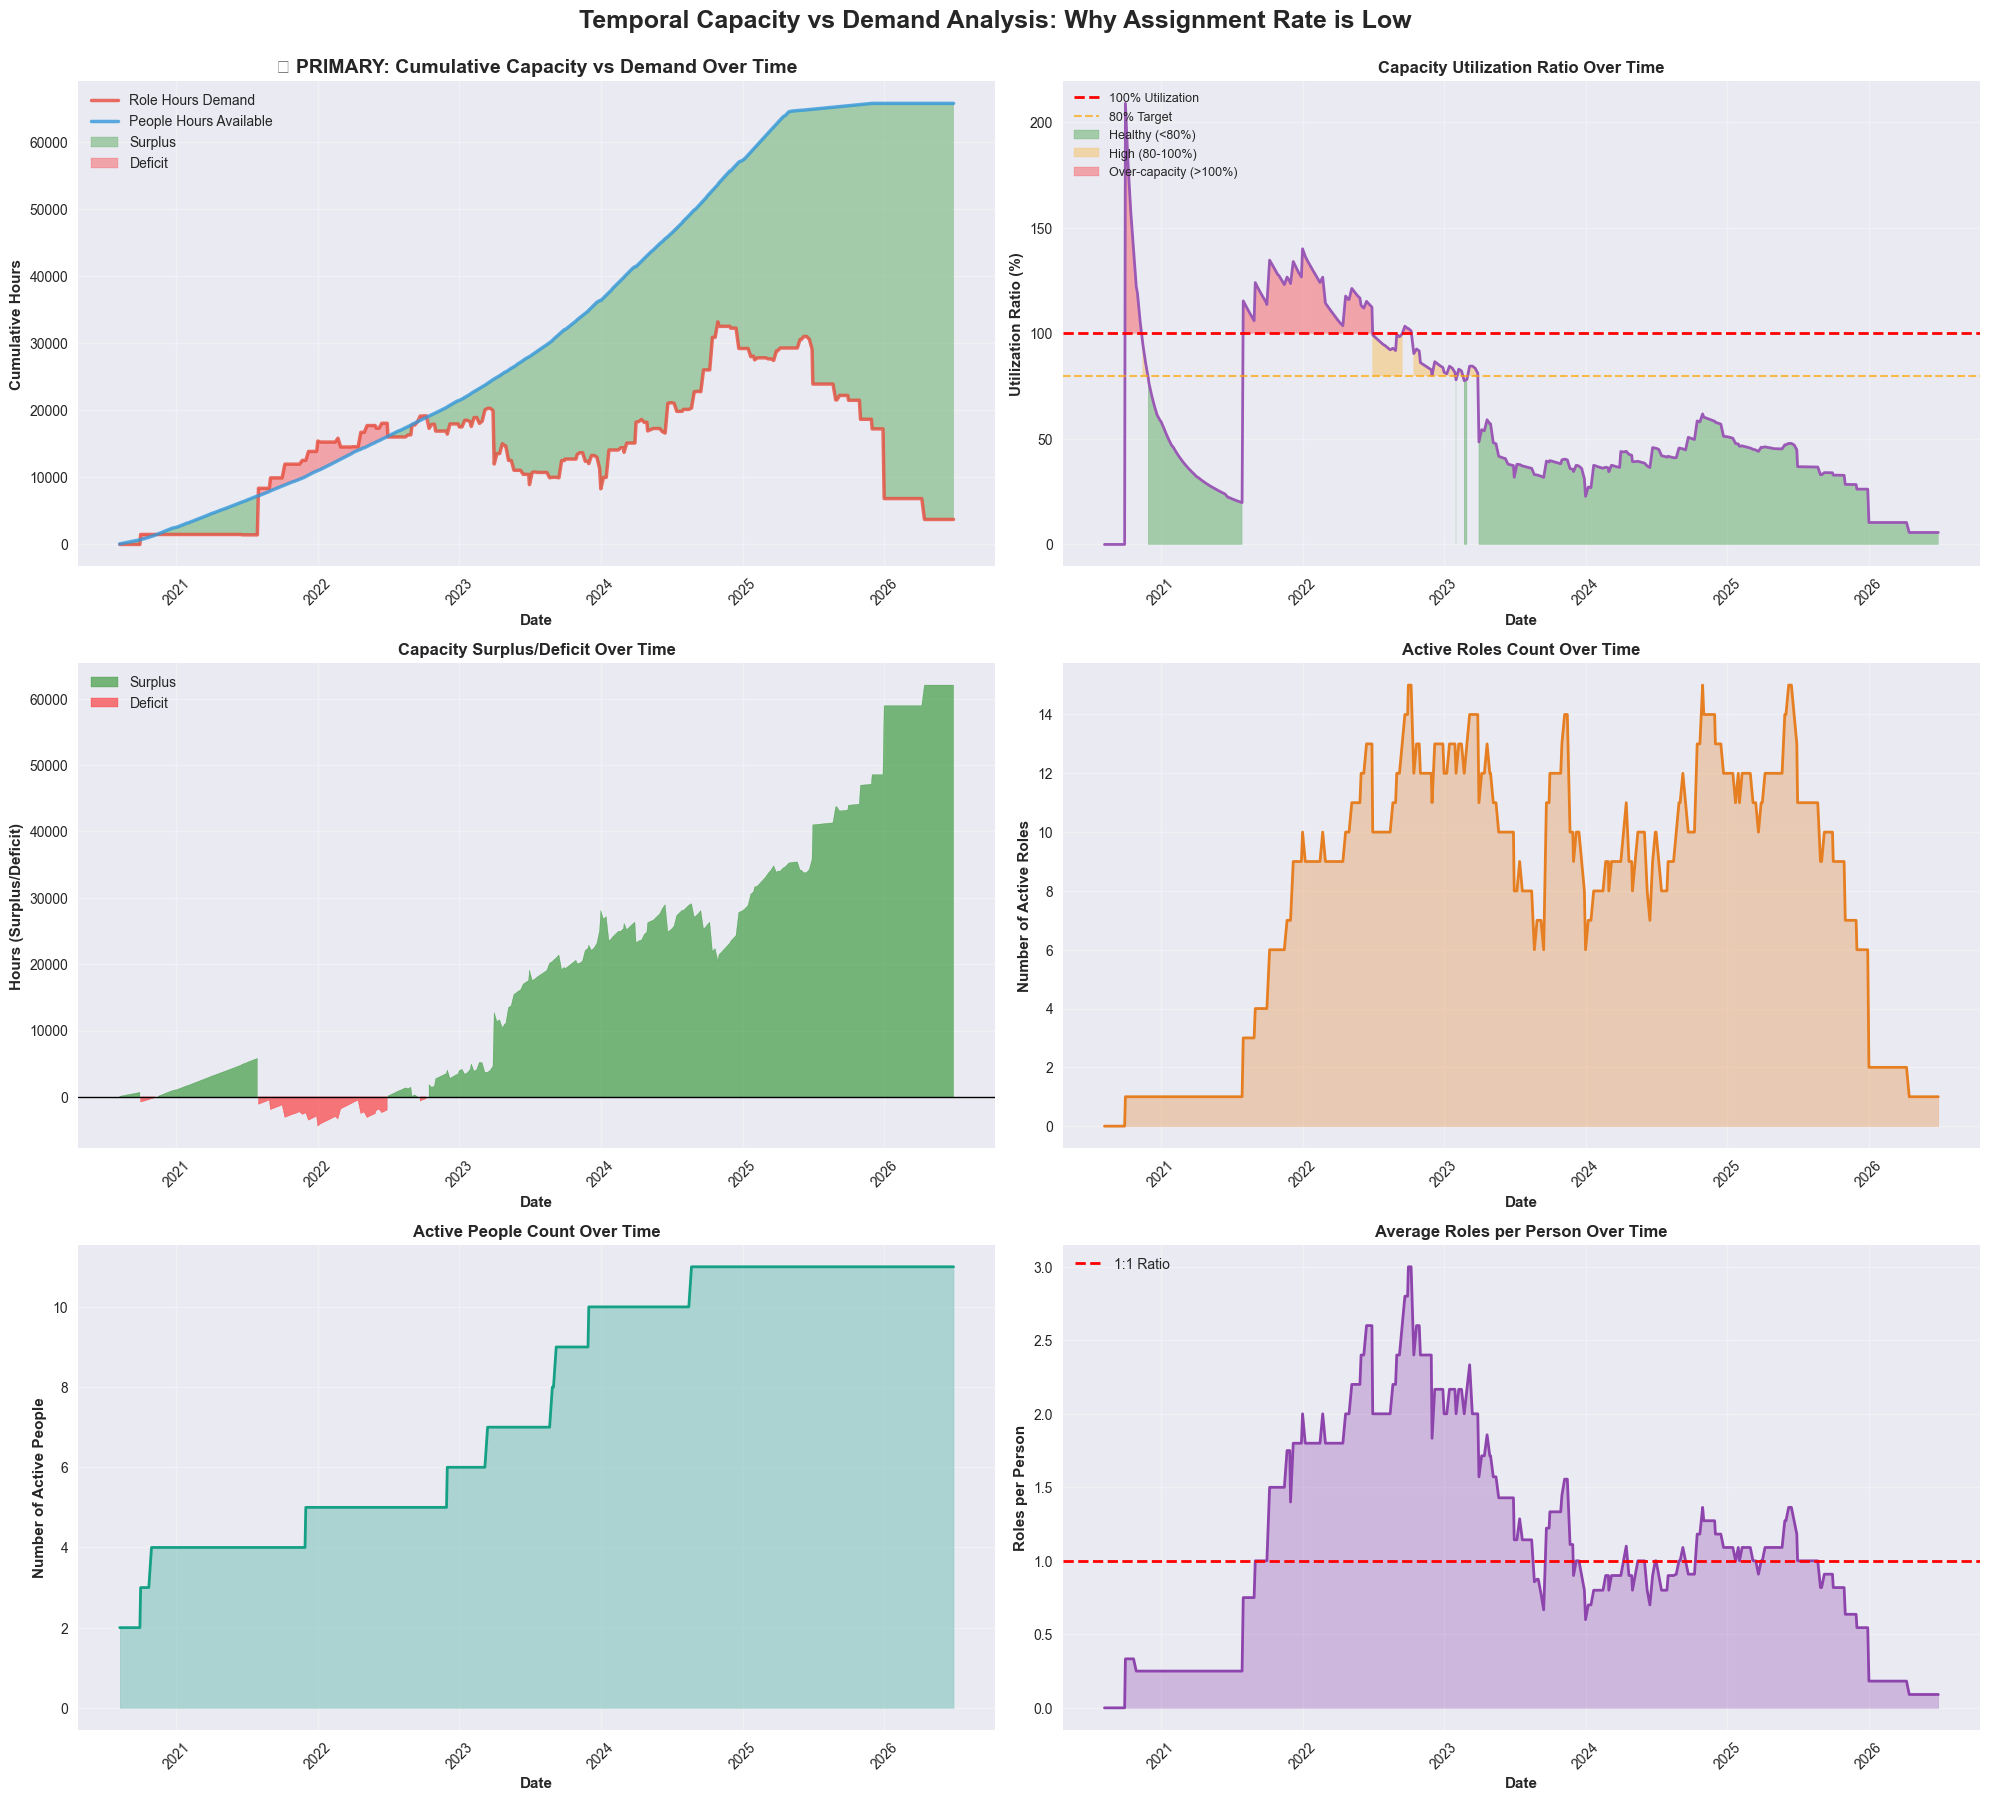


=== STEP 7: ROOT CAUSE ANALYSIS ===

Why is the assignment rate low? Here's what the data tells us:

1. OVERALL CAPACITY MISMATCH:
   • Total role hours needed: 3,728h
   • Total people hours available: 65,796h
   • Demand is 5.7% of available capacity
   ⚠ ISSUE: Demand is much lower than capacity - possible data quality issue

2. TEMPORAL MISMATCH:
   • Average utilization ratio: 57.80%
   • Periods over 100% utilization: 65/349
   ⚠ PROBLEM: 65 periods have more demand than capacity
   → Roles and people availability are misaligned in time

3. ROLE-PERSON RATIO:
   • Final active roles: 1
   • Final active people: 11
   • Ratio: 0.09 roles per person

4. PEAK DEMAND PERIOD:
   • Peak utilization: 208.99% on 2020-10-01
   • Active roles at peak: 1
   • Active people at peak: 3
   ⚠ CRITICAL: Peak demand is 209% - severe capacity shortage

=== STEP 8: RECOMMENDATIONS ===

To improve assignment rate:
  1. ✓ Reduce W_CAPACITY weight to allow over-allocation
  2. ✓ Increase OTHER_WORK_T

In [10]:
# === TEMPORAL CAPACITY VS DEMAND ANALYSIS ===
print("="*80)
print("TEMPORAL CAPACITY VS DEMAND ANALYSIS")
print("="*80)
print("\nAnalyzing role hour demands vs. available people capacity over time...\n")

# --- STEP 1: PREPARE TIME SERIES DATA ---
print("=== STEP 1: PREPARING TIME SERIES DATA ===\n")

# Get all unique dates from both roles and time entries
role_dates = pd.concat([
    df_roles_enriched['startdate'].dropna(),
    df_roles_enriched['enddate'].dropna()
]).unique()

time_entry_dates = df_time_entries_enriched['dt'].dropna().unique()

all_dates = sorted(set(list(role_dates) + list(time_entry_dates)))
print(f"✓ Date range: {min(all_dates)} to {max(all_dates)}")
print(f"✓ Total unique dates: {len(all_dates)}")

# Create a daily timeline
timeline = pd.DataFrame({'date': pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')})
print(f"✓ Created daily timeline with {len(timeline)} days\n")

# --- STEP 2: CALCULATE CUMULATIVE ROLE HOURS DEMAND ---
print("=== STEP 2: CALCULATING CUMULATIVE ROLE HOURS DEMAND ===\n")

# For each date, calculate the total required hours for all active roles
def calculate_role_demand(date):
    """Calculate total required hours for all roles active on a given date"""
    active_roles = df_roles_enriched[
        (df_roles_enriched['startdate'] <= date) & 
        (df_roles_enriched['enddate'] >= date)
    ]
    return active_roles['required_hours'].sum()

# This is computationally intensive, so we'll sample dates (every 7 days)
sample_dates = timeline[timeline['date'].dt.day % 7 == 1]['date'].tolist()
print(f"Sampling every 7 days: {len(sample_dates)} samples")

role_demand_data = []
for i, date in enumerate(sample_dates):
    if i % 50 == 0:
        print(f"Processing date {i+1}/{len(sample_dates)}: {date.date()}")
    
    demand = calculate_role_demand(date)
    role_demand_data.append({
        'date': date,
        'total_role_hours_demand': demand,
        'active_roles_count': len(df_roles_enriched[
            (df_roles_enriched['startdate'] <= date) & 
            (df_roles_enriched['enddate'] >= date)
        ])
    })

df_role_demand = pd.DataFrame(role_demand_data)
print(f"\n✓ Calculated role demand for {len(df_role_demand)} sample dates\n")

# --- STEP 3: CALCULATE CUMULATIVE PEOPLE CAPACITY ---
print("=== STEP 3: CALCULATING CUMULATIVE PEOPLE CAPACITY ===\n")

# For each date, calculate total available capacity from all people who have worked by that date
def calculate_people_capacity(date):
    """Calculate total logged hours from all people who have worked up to this date"""
    # People who started working on or before this date
    active_people = df_time_entries_enriched[
        df_time_entries_enriched['dt'] <= date
    ]
    
    # Total hours logged by these people (cumulative)
    total_hours = active_people['hours'].sum()
    
    # Count of active people
    active_people_count = active_people['master_person_id'].nunique()
    
    return total_hours, active_people_count

people_capacity_data = []
for i, date in enumerate(sample_dates):
    if i % 50 == 0:
        print(f"Processing date {i+1}/{len(sample_dates)}: {date.date()}")
    
    capacity, people_count = calculate_people_capacity(date)
    people_capacity_data.append({
        'date': date,
        'total_people_hours_available': capacity,
        'active_people_count': people_count
    })

df_people_capacity = pd.DataFrame(people_capacity_data)
print(f"\n✓ Calculated people capacity for {len(df_people_capacity)} sample dates\n")

# --- STEP 4: MERGE AND ANALYZE ---
print("=== STEP 4: MERGING CAPACITY & DEMAND DATA ===\n")

df_timeline_analysis = pd.merge(df_role_demand, df_people_capacity, on='date', how='outer').sort_values('date')
df_timeline_analysis.fillna(0, inplace=True)

# Calculate capacity utilization ratio
df_timeline_analysis['capacity_utilization_ratio'] = np.where(
    df_timeline_analysis['total_people_hours_available'] > 0,
    (df_timeline_analysis['total_role_hours_demand'] / df_timeline_analysis['total_people_hours_available']) * 100,
    0
)

# Calculate surplus/deficit
df_timeline_analysis['capacity_surplus_deficit'] = (
    df_timeline_analysis['total_people_hours_available'] - 
    df_timeline_analysis['total_role_hours_demand']
)

print("Sample of timeline analysis:")
display(df_timeline_analysis.head(20))

# --- STEP 5: KEY STATISTICS ---
print("\n=== STEP 5: KEY STATISTICS ===\n")

print("Overall Metrics:")
print(f"  • Total role hours demand (cumulative): {df_role_demand['total_role_hours_demand'].max():,.0f}h")
print(f"  • Total people hours available (cumulative): {df_people_capacity['total_people_hours_available'].max():,.0f}h")
print(f"  • Final capacity surplus/deficit: {df_timeline_analysis['capacity_surplus_deficit'].iloc[-1]:,.0f}h")
print(f"  • Final utilization ratio: {df_timeline_analysis['capacity_utilization_ratio'].iloc[-1]:.2f}%")
print()

# Find critical periods
print("Critical Periods:")
deficit_periods = df_timeline_analysis[df_timeline_analysis['capacity_surplus_deficit'] < 0]
if len(deficit_periods) > 0:
    print(f"  • Periods with capacity deficit: {len(deficit_periods)}")
    print(f"  • Worst deficit: {deficit_periods['capacity_surplus_deficit'].min():,.0f}h on {deficit_periods.loc[deficit_periods['capacity_surplus_deficit'].idxmin(), 'date'].date()}")
else:
    print("  • No capacity deficit periods found!")
print()

over_utilized_periods = df_timeline_analysis[df_timeline_analysis['capacity_utilization_ratio'] > 100]
if len(over_utilized_periods) > 0:
    print(f"  • Periods with over-utilization (>100%): {len(over_utilized_periods)}")
    print(f"  • Peak utilization: {df_timeline_analysis['capacity_utilization_ratio'].max():.2f}%")
else:
    print("  • No over-utilization periods found!")
print()

# --- STEP 6: DETAILED VISUALIZATION ---
print("=== STEP 6: VISUALIZATION ===\n")

fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# 1. PRIMARY: Cumulative Hours Comparison
ax1 = axes[0, 0]
ax1.plot(df_timeline_analysis['date'], df_timeline_analysis['total_role_hours_demand'], 
         label='Role Hours Demand', color='#E74C3C', linewidth=2.5, alpha=0.8)
ax1.plot(df_timeline_analysis['date'], df_timeline_analysis['total_people_hours_available'], 
         label='People Hours Available', color='#3498DB', linewidth=2.5, alpha=0.8)
ax1.fill_between(df_timeline_analysis['date'], 
                  df_timeline_analysis['total_role_hours_demand'],
                  df_timeline_analysis['total_people_hours_available'],
                  where=(df_timeline_analysis['total_people_hours_available'] >= df_timeline_analysis['total_role_hours_demand']),
                  alpha=0.3, color='green', label='Surplus')
ax1.fill_between(df_timeline_analysis['date'], 
                  df_timeline_analysis['total_role_hours_demand'],
                  df_timeline_analysis['total_people_hours_available'],
                  where=(df_timeline_analysis['total_people_hours_available'] < df_timeline_analysis['total_role_hours_demand']),
                  alpha=0.3, color='red', label='Deficit')
ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
ax1.set_ylabel('Cumulative Hours', fontsize=11, fontweight='bold')
ax1.set_title('🎯 PRIMARY: Cumulative Capacity vs Demand Over Time', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Capacity Utilization Ratio
ax2 = axes[0, 1]
ax2.plot(df_timeline_analysis['date'], df_timeline_analysis['capacity_utilization_ratio'], 
         color='#9B59B6', linewidth=2)
ax2.axhline(y=100, color='red', linestyle='--', linewidth=2, label='100% Utilization')
ax2.axhline(y=80, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='80% Target')
ax2.fill_between(df_timeline_analysis['date'], 0, df_timeline_analysis['capacity_utilization_ratio'],
                  where=(df_timeline_analysis['capacity_utilization_ratio'] <= 80),
                  alpha=0.3, color='green', label='Healthy (<80%)')
ax2.fill_between(df_timeline_analysis['date'], 80, df_timeline_analysis['capacity_utilization_ratio'],
                  where=(df_timeline_analysis['capacity_utilization_ratio'] > 80) & (df_timeline_analysis['capacity_utilization_ratio'] <= 100),
                  alpha=0.3, color='orange', label='High (80-100%)')
ax2.fill_between(df_timeline_analysis['date'], 100, df_timeline_analysis['capacity_utilization_ratio'],
                  where=(df_timeline_analysis['capacity_utilization_ratio'] > 100),
                  alpha=0.3, color='red', label='Over-capacity (>100%)')
ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_ylabel('Utilization Ratio (%)', fontsize=11, fontweight='bold')
ax2.set_title('Capacity Utilization Ratio Over Time', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Surplus/Deficit Over Time
ax3 = axes[1, 0]
colors = ['green' if x >= 0 else 'red' for x in df_timeline_analysis['capacity_surplus_deficit']]
ax3.fill_between(df_timeline_analysis['date'], 0, df_timeline_analysis['capacity_surplus_deficit'],
                  where=(df_timeline_analysis['capacity_surplus_deficit'] >= 0),
                  alpha=0.5, color='green', label='Surplus')
ax3.fill_between(df_timeline_analysis['date'], 0, df_timeline_analysis['capacity_surplus_deficit'],
                  where=(df_timeline_analysis['capacity_surplus_deficit'] < 0),
                  alpha=0.5, color='red', label='Deficit')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_ylabel('Hours (Surplus/Deficit)', fontsize=11, fontweight='bold')
ax3.set_title('Capacity Surplus/Deficit Over Time', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Active Roles Count
ax4 = axes[1, 1]
ax4.plot(df_timeline_analysis['date'], df_timeline_analysis['active_roles_count'], 
         color='#E67E22', linewidth=2)
ax4.fill_between(df_timeline_analysis['date'], 0, df_timeline_analysis['active_roles_count'],
                  alpha=0.3, color='#E67E22')
ax4.set_xlabel('Date', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Active Roles', fontsize=11, fontweight='bold')
ax4.set_title('Active Roles Count Over Time', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# 5. Active People Count
ax5 = axes[2, 0]
ax5.plot(df_timeline_analysis['date'], df_timeline_analysis['active_people_count'], 
         color='#16A085', linewidth=2)
ax5.fill_between(df_timeline_analysis['date'], 0, df_timeline_analysis['active_people_count'],
                  alpha=0.3, color='#16A085')
ax5.set_xlabel('Date', fontsize=11, fontweight='bold')
ax5.set_ylabel('Number of Active People', fontsize=11, fontweight='bold')
ax5.set_title('Active People Count Over Time', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# 6. Ratio: Roles per Person
ax6 = axes[2, 1]
df_timeline_analysis['roles_per_person'] = np.where(
    df_timeline_analysis['active_people_count'] > 0,
    df_timeline_analysis['active_roles_count'] / df_timeline_analysis['active_people_count'],
    0
)
ax6.plot(df_timeline_analysis['date'], df_timeline_analysis['roles_per_person'], 
         color='#8E44AD', linewidth=2)
ax6.axhline(y=1, color='red', linestyle='--', linewidth=2, label='1:1 Ratio')
ax6.fill_between(df_timeline_analysis['date'], 0, df_timeline_analysis['roles_per_person'],
                  alpha=0.3, color='#8E44AD')
ax6.set_xlabel('Date', fontsize=11, fontweight='bold')
ax6.set_ylabel('Roles per Person', fontsize=11, fontweight='bold')
ax6.set_title('Average Roles per Person Over Time', fontsize=12, fontweight='bold')
ax6.legend(loc='upper left', fontsize=10)
ax6.grid(True, alpha=0.3)
ax6.tick_params(axis='x', rotation=45)

plt.suptitle('Temporal Capacity vs Demand Analysis: Why Assignment Rate is Low', 
             fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

# --- STEP 7: ROOT CAUSE ANALYSIS ---
print("\n=== STEP 7: ROOT CAUSE ANALYSIS ===\n")

print("Why is the assignment rate low? Here's what the data tells us:\n")

# Calculate key ratios
final_demand = df_timeline_analysis['total_role_hours_demand'].iloc[-1]
final_capacity = df_timeline_analysis['total_people_hours_available'].iloc[-1]
final_ratio = (final_demand / final_capacity * 100) if final_capacity > 0 else 0

print(f"1. OVERALL CAPACITY MISMATCH:")
print(f"   • Total role hours needed: {final_demand:,.0f}h")
print(f"   • Total people hours available: {final_capacity:,.0f}h")
print(f"   • Demand is {final_ratio:.1f}% of available capacity")

if final_ratio > 100:
    print(f"   ⚠ PROBLEM: Demand exceeds capacity by {final_ratio - 100:.1f}%")
elif final_ratio < 50:
    print(f"   ⚠ ISSUE: Demand is much lower than capacity - possible data quality issue")
print()

# Temporal mismatch
avg_utilization = df_timeline_analysis['capacity_utilization_ratio'].mean()
print(f"2. TEMPORAL MISMATCH:")
print(f"   • Average utilization ratio: {avg_utilization:.2f}%")
print(f"   • Periods over 100% utilization: {len(over_utilized_periods)}/{len(df_timeline_analysis)}")

if len(over_utilized_periods) > 0:
    print(f"   ⚠ PROBLEM: {len(over_utilized_periods)} periods have more demand than capacity")
    print(f"   → Roles and people availability are misaligned in time")
print()

# Role-person ratio
final_roles = df_timeline_analysis['active_roles_count'].iloc[-1]
final_people = df_timeline_analysis['active_people_count'].iloc[-1]
role_person_ratio = final_roles / final_people if final_people > 0 else 0

print(f"3. ROLE-PERSON RATIO:")
print(f"   • Final active roles: {final_roles:.0f}")
print(f"   • Final active people: {final_people:.0f}")
print(f"   • Ratio: {role_person_ratio:.2f} roles per person")

if role_person_ratio > 1.5:
    print(f"   ⚠ PROBLEM: Too many roles per person - assignment algorithm can't keep up")
print()

# Peak demand analysis
peak_utilization_idx = df_timeline_analysis['capacity_utilization_ratio'].idxmax()
peak_date = df_timeline_analysis.loc[peak_utilization_idx, 'date']
peak_utilization = df_timeline_analysis.loc[peak_utilization_idx, 'capacity_utilization_ratio']

print(f"4. PEAK DEMAND PERIOD:")
print(f"   • Peak utilization: {peak_utilization:.2f}% on {peak_date.date()}")
print(f"   • Active roles at peak: {df_timeline_analysis.loc[peak_utilization_idx, 'active_roles_count']:.0f}")
print(f"   • Active people at peak: {df_timeline_analysis.loc[peak_utilization_idx, 'active_people_count']:.0f}")

if peak_utilization > 150:
    print(f"   ⚠ CRITICAL: Peak demand is {peak_utilization:.0f}% - severe capacity shortage")
print()

# --- STEP 8: RECOMMENDATIONS ---
print("=== STEP 8: RECOMMENDATIONS ===\n")

print("To improve assignment rate:")
if final_ratio > 100 or len(over_utilized_periods) > 20:
    print("  1. ✓ Reduce W_CAPACITY weight to allow over-allocation")
    print("  2. ✓ Increase OTHER_WORK_TAX to force more project assignments")
    print("  3. ✓ Relax temporal constraints (allow roles to start before people join)")

if role_person_ratio > 1.5:
    print("  4. ✓ Allow people to take multiple concurrent roles")
    print("  5. ✓ Disable schedule conflict checking (currently prevents overlaps)")

print("  6. ✓ Review role duration calculations - they may be overestimated")
print("  7. ✓ Check if role end dates are realistic")
print()

# --- STEP 9: SAVE ANALYSIS ---
print("=== STEP 9: SAVING ANALYSIS ===\n")

timeline_analysis_path = output_dir / f"analysis__capacity_vs_demand_timeline__{timestamp}.csv"
df_timeline_analysis.to_csv(timeline_analysis_path, index=False)
print(f"✓ Saved timeline analysis to: {timeline_analysis_path}")
print(f"  Rows: {len(df_timeline_analysis)}")

print("\n" + "="*80)
print("TEMPORAL ANALYSIS COMPLETE")
print("="*80)
print("\nKey Insight: Check the PRIMARY chart (top-left) to see where demand exceeds capacity")
print("This explains why many roles cannot be assigned - there simply aren't enough hours!")

In [11]:
# One-liner to export all key tables at once
for name, df in [
    ('identity_map', df_master_identity_map),
    ('enriched_matches', df_enriched_matches),
    ('time_entries_enriched', df_time_entries_enriched),
    ('person_capacity', person_capacity_tracker),
    ('roles_enriched', df_roles_enriched),
    ('role_assignments', df_role_assignments),
    
    ('sensitivity_analysis', df_sensitivity_report)
]:
    df.to_csv(output_dir / f"export__{name}__{timestamp}.csv", index=False)
    print(f"✓ Exported {name}")

✓ Exported identity_map
✓ Exported enriched_matches
✓ Exported time_entries_enriched
✓ Exported person_capacity
✓ Exported roles_enriched
✓ Exported role_assignments
✓ Exported sensitivity_analysis


In [51]:
df_role_assignments

role_id  \
0   dcb900a8-73fd-43e3-881a-2464a7cce7c7   
1   ab7d6e04-6007-4b32-b432-384d452ccd5f   
2   d713dfbd-3f99-47be-baa9-394adb5384a2   
3   0ac83e05-c7e4-46f9-9823-cbb12d8225e4   
4   12db42da-30b3-803f-959f-d8b5ac9aa746   
5   185b42da-30b3-801f-b838-e6cb1a78d1e8   
6   8823a310-960b-4c1b-9696-68f681b8b0f2   
7   347c5d6b-8487-437c-8945-612a32c0b866   
8   50a77c0b-3b4f-46d3-b487-644ae72275db   
9   185b42da-30b3-80c5-b9c3-ca3ea65ff40b   
10  85059a4b-7cca-4b04-9e72-6d5a048b07cf   
11  ae0f44fc-8c33-4b4f-b825-716dc23a75e0   
12  99ba6ed3-b247-4ff0-9652-c5d5c889865f   
13  fbebcca2-2f78-4a2c-996b-ca0e9c0b3a5d   
14  185b42da-30b3-80a5-80e2-c0c94e9cf650   
15  0d8057f1-c6ab-4d9e-b4bd-2998eea02d2b   
16  66750286-bdc2-4928-9ae9-29ac1b7a1a77   
17  505b7c80-31f6-4e70-a5fd-4251cb93f566   
18  99c0e7d5-3fb0-4089-be24-b0b5afeefad8   
19  9e4d1362-7d54-496e-9ff7-4c8bdd4d027b   
20  a53e017d-e456-49bd-89b6-fdbeec1b30b4   
21  f97beed2-edbe-43b9-8aea-d5c8f42090b3   
22  bb2cf745-6ae6-4457-abaa-274df6c2b91d   
23  849de986-d3ce-40d4-9b7d-ac24ad54ddcf   
24  6036a216-b3e2-4169-a7e4-103f3eefde91   
25  cec74424-f754-460d-9d8b-b69c92707e31   
26  4dfd5c32-dc97-43ce-bad5-f6e110a7d9ef   
27  53088e57-9ffe-4b50-9ecb-9a63b7fb75d7   
28  2bbe9108-3ff4-489c-8ad2-1614da590b0c   
29  d89381f6-baf2-4022-8df1-7fae7fa7ea79   
30  3de8fb70-add9-477a-b139-1a5176007b26   
31  270f4331-f24e-4a60-bb19-0d336f38cc2f   
32  ae583fee-6439-4238-a15a-fb3390927761   
33  249b42da-30b3-8060-bf1c-fb4307407b2f   
34  d7658812-ee4b-470d-b277-6c2d75fd908c   
35  34a8e377-f7b3-4bed-bcf2-758476187f20   
36  12db42da-30b3-8046-bb1e-c9d95c90336d   
37  14c1d6bc-a9d4-425e-aeb9-4a5cb1eecde2   
38  d822c29f-05d5-4478-82fe-d297274f2315   
39  60b9abb5-6ff3-4bcd-be3c-ec6f396305c3   
40  05fcf1df-1954-4eef-a895-53a2e0224f2d   
41  c1f1595e-40d0-4dd9-8d76-20876fcffd79   
42  04b5ce10-a83a-42fd-bb80-8f57ff861af1   
43  81269ae0-a08b-4539-84ab-cdfa941fc807   
44  857e3709-f044-498d-914c-eef659e989a9   
45  68fb318f-438b-4257-95f2-3893564ebd01   
46  b1dbfce2-eb64-4565-a041-ed9c6e669aa6   
47  38968285-7e0f-4c8b-b473-9cbacd5f0ab4   
48  19851429-9a05-4b4b-a96a-baba85b0f20b   
49  146d8d0f-9b3b-43c9-901b-26d400a5120f   
50  b1a69747-2cd9-4575-a28e-94989bcce981   
51  89b03d88-6ad5-45a9-970d-10e18a3ba8e3   
52  6d926bc9-c908-42b4-8a92-dd641b0dfcbd   
53  264b42da-30b3-8026-b4e1-f6a7c2832cc2   
54  1deb42da-30b3-8067-8f3e-c76fae638308   
55  264b42da-30b3-80cd-8d2f-fefa6ea8c326   
56  249b42da-30b3-8041-8aae-f30f8d6ad592   
57  1ceb42da-30b3-8046-a1e3-c5c96db61c4b   
58  264b42da-30b3-8092-be4b-faf4e1d5bd32   
59  12db42da-30b3-802a-b47f-fd328c28da27   
60  cf2b5070-a906-445c-b801-9c88b097e7f1   
61  12db42da-30b3-8005-869c-d26b239a9e33   
62  0517e8f8-b88c-41fa-ae1a-57458f4571d0   
63  417f57d4-7b08-4abf-84fb-514b39a45284   
64  babc12fb-9b1b-45bc-ab70-649968bb222d   
65  ae0d8aec-82ef-484e-9883-b09229ae5c2c   
66  158e5abd-fc12-445d-890c-64d995ce51be   
67  91a014ae-544b-4e2d-a35b-1bc5363ddc98   
68  8819829c-c1e3-4d2d-aea9-01fb932efa07   
69  c90ee650-07ac-4725-a75d-f0b4d5f6b5e6   
70  1fa8f8c9-8c99-43bb-ab02-122fbda89f2c   
71  d82a3cc7-4e24-4155-bdbc-c57b18313537   
72  ee3fc5d1-363e-43b1-b497-da1c096fd64e   
73  1c8ad62d-877d-47b1-afc2-58a0b76cb35e   
74  b0e13dd3-ee7c-4e4f-83f7-c182f0ec96bf   
75  27f1e8c7-63ee-4d5f-8a65-4a518d784537   
76  47939100-a49c-4db5-9751-92d69e7cd85f   
77  bdda97bc-b810-4a7d-b803-fe1480b92906   
78  64968604-e01c-4a6c-acca-135fb597330e   
79  72a4562c-6320-43de-8511-6bcd6c0eadcd   
80  0b753a69-9038-4db3-a6d4-ea3c31c5d5bf   
81  a258b1f2-6152-4765-bd83-b5fbc8bea442   
82  6fad142b-c2f6-4a68-b3e6-aa309dbb0bc7   
83  8d8ad1d3-263a-4c02-a697-20a111d3fb36   
84  b1514fb5-215a-439a-9390-50485f6f2d03   
85  7e41c80c-e2b0-4666-bd15-81ba62f5363b   
86  11ab42da-30b3-80b5-ac96-eec9c622e60d   
87  10cb42da-30b3-8004-8e0e-d34a949f1934   
88  db6a818f-f08d-489d-a6aa-873e24546ba1   
89  9e5e1c9b-0105-4fbe-be38-22d934ba914e   
90  f8497a42-65c8-4836-ad80-7

# FINAL DATA CONSOLIDATION & EXPORT

This cell serves as the final step in the data processing pipeline. Its purpose is to take the various intermediate DataFrames created in previous stages (identity matching, enrichment, role assignment) and consolidate them into a set of clean, final, and user-friendly tables ready for export and business intelligence (BI) analysis.

---

### Step 1: Create Master Person Profile

-   **Input**: `df_enriched_matches`
-   **Process**: This step creates a definitive, one-row-per-person summary. It selects all the key identity information (`master_person_id`, `consultant_id`, `user_id`) and the comprehensive performance metrics calculated earlier (`utilization_rate`, `billable_percentage`, `total_hours_logged`, `hours_gap`, `years_employed`, etc.).
-   **Output**: `df_master_person_profile`
    -   **Grain**: One row per person.
    -   **Purpose**: A master table for all person-level attributes and KPIs.

---

### Step 2: Create Enriched Role Assignments

-   **Inputs**: `df_role_assignments`, `df_roles_enriched`, `df_master_person_profile`
-   **Process**: The raw output from the assignment algorithm is enriched with contextual data.
    1.  It merges the assignments with role details (like `project_id`, `startdate`, `enddate`, `required_hours`).
    2.  It then merges with the `df_master_person_profile` to add key performance indicators of the assigned person (like their overall `utilization_rate`) to each assignment record.
-   **Output**: `df_role_assignments_enriched`
    -   **Grain**: One row per role assignment.
    -   **Purpose**: Provides a complete picture of each assignment, linking the role's requirements to the assigned person's profile.

---

### Step 3: Create Master Time Entries Table

-   **Inputs**: `df_time_entries_enriched`, `df_master_person_profile`, `df_projects`
-   **Process**: This step creates a fully denormalized table of all time entries. Each time log is enriched with the full profile of the person who logged it, including their `consultant_id` and performance metrics. It also adds the `project_name` for easier analysis.
-   **Output**: `df_time_entries_master`
    -   **Grain**: One row per time entry.
    -   **Purpose**: A detailed, flat table for granular analysis of time logs, ready to be loaded into a BI tool.

---

### Step 4: Create Person-Project Summary

-   **Inputs**: `person_capacity_tracker`, `df_master_person_profile`, `df_role_assignments_enriched`
-   **Process**: This aggregates data at the person-project level. It starts with the total hours each person logged per project and enriches it with the person's overall metrics. It also calculates and adds a count of how many roles were assigned to that specific person on that specific project.
-   **Output**: `df_person_project_summary`
    -   **Grain**: One row per person-project combination.
    -   **Purpose**: Summarizes a person's total contribution and assigned workload for each project they were involved in.

---

### Step 5: Create Ultimate Consolidated Table

-   **Inputs**: `df_role_assignments_enriched`, `df_time_entries_master`
-   **Process**: This creates a "mega-table" by starting with the enriched role assignments and adding even more detail. It summarizes the actual time entries related to each person-project combination and merges it onto the corresponding role assignments.
-   **Output**: `df_ultimate_consolidated`
    -   **Grain**: One row per role assignment (potentially duplicated if merged on multiple keys).
    -   **Purpose**: An all-in-one table that attempts to link planned work (roles) with actual work (time entries) for deep-dive analysis.

---

### Final Step: Save All Tables

-   **Process**: The code iterates through the five newly created DataFrames and saves each one as a separate CSV file in the `output_dir`. The filenames are timestamped for version control.
-   **Purpose**: To persist the final, cleaned, and consolidated datasets for external use in BI tools, further analysis, or reporting.

In [12]:
# --- 1. MASTER PERSON PROFILE (One row per person) ---
print("\n[1] Creating Master Person Profile...")

df_master_person_profile = df_enriched_matches[[
    'master_person_id', 'consultant_id', 'user_id',
    'match_score', 'assignment_pass',
    'hr_join_date', 'first_activity_date', 'days_between',
    'total_hours_logged', 'billable_hours', 'non_billable_hours',
    'billable_percentage', 'utilization_rate', 'billable_utilization_rate',
    'n_projects_worked', 'n_billable_projects',
    'years_employed', 'unique_work_days', 'avg_hours_per_work_day',
    'adjusted_potential_hours_pto', 'hours_gap'
]].copy()

print(f"✓ Master Person Profile: {len(df_master_person_profile)} people")
display(df_master_person_profile.head(10))

# --- 2. ROLE ASSIGNMENTS ENRICHED ---
print("\n[2] Creating Enriched Role Assignments...")

# Merge role assignments with role details
df_role_assignments_enriched = df_role_assignments.merge(
    df_roles_enriched[['role_id',  'startdate', 'enddate', 'required_hours', 'business_days_duration']],
    on='role_id',
    how='left'
)

# Rename 'assigned_to_project' to 'project_id' for clarity and consistency
df_role_assignments_enriched.rename(columns={'assigned_to_project': 'project_id'}, inplace=True)

# Add person details
df_role_assignments_enriched = df_role_assignments_enriched.merge(
    df_master_person_profile[['master_person_id', 'consultant_id', 'billable_percentage', 'utilization_rate']],
    left_on='assigned_to_person',
    right_on='master_person_id',
    how='left'
)

print(f"✓ Enriched Role Assignments: {len(df_role_assignments_enriched)} assignments")
display(df_role_assignments_enriched.head(10))

# --- 3. TIME ENTRIES MASTER (Complete lineage) ---
print("\n[3] Creating Master Time Entries Table...")

df_time_entries_master = df_time_entries_enriched.merge(
    df_master_person_profile[['master_person_id', 'consultant_id', 'billable_percentage', 'utilization_rate']],
    on='master_person_id',
    how='left'
)

# Add project names if available
if 'project_name' in df_projects.columns:
    df_time_entries_master = df_time_entries_master.merge(
        df_projects[['project_id', 'project_name']],
        on='project_id',
        how='left'
    )

print(f"✓ Master Time Entries: {len(df_time_entries_master)} entries")
display(df_time_entries_master.head(10))

# --- 4. PERSON-PROJECT SUMMARY ---
print("\n[4] Creating Person-Project Summary...")

# The project_id is named 'projectID' in person_capacity_tracker. Let's align it.
person_capacity_tracker.rename(columns={'projectID': 'project_id'}, inplace=True, errors='ignore')

df_person_project_summary = person_capacity_tracker.merge(
    df_master_person_profile[['master_person_id', 'consultant_id', 'utilization_rate', 'years_employed']],
    on='master_person_id',
    how='left'
)

# Add count of roles assigned to this person-project combo
role_counts = df_role_assignments_enriched.groupby(['assigned_to_person', 'project_id']).size().reset_index(name='roles_on_project')
df_person_project_summary = df_person_project_summary.merge(
    role_counts,
    left_on=['master_person_id', 'project_id'],
    right_on=['assigned_to_person', 'project_id'],
    how='left'
).fillna({'roles_on_project': 0})

print(f"✓ Person-Project Summary: {len(df_person_project_summary)} combinations")
display(df_person_project_summary.head(10))

# --- 5. ULTIMATE CONSOLIDATED TABLE (Everything) ---
print("\n[5] Creating ULTIMATE CONSOLIDATED TABLE...")

# Start with role assignments as the grain
df_ultimate_consolidated = df_role_assignments_enriched.copy()

# Add time entry summary for each person-project-role combo
time_summary = df_time_entries_master.groupby(['master_person_id', 'project_id']).agg({
    'hours': 'sum',
    'dt': ['min', 'max', 'nunique']
}).reset_index()
time_summary.columns = ['master_person_id', 'project_id', 
                        'actual_hours_on_project', 'first_entry_date', 'last_entry_date', 'days_worked_on_project']

df_ultimate_consolidated = df_ultimate_consolidated.merge(
    time_summary,
    left_on=['assigned_to_person', 'project_id'],
    right_on=['master_person_id', 'project_id'],
    how='left',
    suffixes=('', '_time')
)

print(f"✓ Ultimate Consolidated Table: {len(df_ultimate_consolidated)} rows")
display(df_ultimate_consolidated.head(10))

# --- SAVE ALL TABLES ---
print("\n" + "="*80)
print("SAVING FINAL TABLES")
print("="*80)

tables_to_save = {
    'master_person_profile': df_master_person_profile,
    'role_assignments_enriched': df_role_assignments_enriched,
    'time_entries_master': df_time_entries_master,
    'person_project_summary': df_person_project_summary,
    'ultimate_consolidated': df_ultimate_consolidated
}

for table_name, df_table in tables_to_save.items():
    save_path = output_dir / f"final__{table_name}__{timestamp}.csv"
    df_table.to_csv(save_path, index=False)
    print(f"✓ Saved {table_name}: {save_path}")
    print(f"  Rows: {len(df_table):,} | Columns: {df_table.shape[1]}")

print("\n" + "="*80)
print("✅ ALL FINAL TABLES CREATED AND SAVED")
print("="*80)

# --- QUICK ACCESS SUMMARY ---
print("\n📋 QUICK ACCESS TABLE NAMES:\n")
print("1. df_master_person_profile        → One row per person with all metrics")
print("2. df_role_assignments_enriched    → Role assignments with full context")
print("3. df_time_entries_master          → Time entries with person lineage")
print("4. df_person_project_summary       → Person-project capacity summary")
print("5. df_ultimate_consolidated        → Everything combined (role-centric)")
print()
print("All tables saved to:", output_dir)
print("="*80)


[1] Creating Master Person Profile...
✓ Master Person Profile: 11 people


master_person_id  \
0  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4   
1  PERSON_2a554628-d7f2-475f-8872-5a7057388c36   
2  PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7   
3  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
4  PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368   
5  PERSON_61948bc5-3844-4219-a605-94e22f59571a   
6  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
7  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2   
8  PERSON_afd559ec-90bf-40c9-8e96-57e3d7af66fd   
9  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9   

                          consultant_id                   user_id  \
0  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  64f5e9f270d77d3906fdbcf0   
1  2a554628-d7f2-475f-8872-5a7057388c36  66cf0a91d9fd470646f99eb9   
2  348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  5f68ec6a633ecf60f5e863ce   
3  38eebb46-9733-484c-afd2-543d79eb80b1  64e5f63d97f5910c716406b8   
4  40d8972b-c3ad-450e-a56d-873a8cdc4368  5f437ae67d26442bf5452ecd   
5  61948bc5-3844-4219-a605-94e22f59571a  6569cd007deb44467624660e   
6  85808593-b0e4-4163-b8f1-a5fc90b219ee  61e06b0375015b508b28241b   
7  8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  5f437e3d9decb91192e3784a   
8  afd559ec-90bf-40c9-8e96-57e3d7af66fd  640f2ad98c3e1105ccb78609   
9  d2458d77-5056-43b5-82c4-12543225bcd9  5f7c718cf3fda011462c67c1   

   match_score assignment_pass hr_join_date first_activity_date  days_between  \
0     0.125000         Optimal   2023-09-04          2023-09-04             0   
1     0.125000         Optimal   2024-08-19          2024-08-19             0   
2     0.125000         Optimal   2020-10-01          2020-10-01             0   
3     0.125000         Optimal   2023-08-23          2023-08-23             0   
4     0.003937         Optimal   2019-12-01          2020-08-03           246   
5     0.125000         Optimal   2023-12-01          2023-12-01             0   
6     0.125000         Optimal   2021-12-01          2021-12-01             0   
7     0.002137         Optimal   2019-05-01          2020-08-03           460   
8     0.125000         Optimal   2023-03-13          2023-03-13             0   
9     0.030303         Optimal   2020-10-01          2020-10-26            25   

   total_hours_logged  billable_hours  non_billable_hours  \
0             3360.00     2320.000000         1040.000000   
1             1412.00      928.000000          484.000000   
2             9278.00     5787.000000         3491.000000   
3             4588.00      262.500000         4325.500000   
4             9831.05     6112.050000         3719.000000   
5             2837.00     1060.000000         1777.000000   
6             6536.60     3632.016667         2904.583333   
7             9691.50     4902.750000         4788.750000   
8             4288.00     2837.000000         1451.000000   
9             9087.50     7345.000000         1742.500000   

   billable_percentage  utilization_rate  billable_utilization_rate  \
0                69.05             81.71                      56.42   
1                65.72             63.49                      41.73   
2                62.37             94.06                      58.67   
3                 5.72            109.66                       6.27   
4                62.17             85.40                      53.09   
5                37.36             77.94                      29.12   
6                55.56             86.28                      47.94   
7                50.59             76.53                      38.71   
8                66.16             84.81                      56.11   
9                80.83             92.13                      74.46   

   n_projects_worked  n_billable_projects  years_employed  unique_work_days  \
0                  7                    3        2.091718               418   
1                  6                    2        1.133470               176   
2                 14                   11        5.015743              1151   
3                 12                    6        2.124572


[2] Creating Enriched Role Assignments...
✓ Enriched Role Assignments: 96 assignments


role_id  \
0  dcb900a8-73fd-43e3-881a-2464a7cce7c7   
1  ab7d6e04-6007-4b32-b432-384d452ccd5f   
2  d713dfbd-3f99-47be-baa9-394adb5384a2   
3  0ac83e05-c7e4-46f9-9823-cbb12d8225e4   
4  12db42da-30b3-803f-959f-d8b5ac9aa746   
5  185b42da-30b3-801f-b838-e6cb1a78d1e8   
6  8823a310-960b-4c1b-9696-68f681b8b0f2   
7  347c5d6b-8487-437c-8945-612a32c0b866   
8  50a77c0b-3b4f-46d3-b487-644ae72275db   
9  185b42da-30b3-80c5-b9c3-ca3ea65ff40b   

                            assigned_to_person                project_id  \
0  PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368  60106d6e9ab6ce7c1dacbc9c   
1  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  6179a9ac4d694b7ecbe75ea6   
2  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee  5f437b557d26442bf54530ac   
3  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee  5f437f189decb91192e37bc0   
4  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee  667a7035842d3958e3f89903   
5  PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  66f65d6c76257e3e51f9afc4   
6  PERSON_61948bc5-3844-4219-a605-94e22f59571a  5f437b557d26442bf54530ac   
7  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9  5f437f189decb91192e37bc0   
8  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  60106d6e9ab6ce7c1dacbc9c   
9  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9  65b668d2bd0f4626444bf06e   

  assignment_type  assignment_cost  required_hours_x  \
0         Project              0.0               440   
1         Project              0.0                40   
2         Project              0.0               688   
3         Project              0.0               312   
4         Project              0.0               272   
5         Project              0.0               232   
6         Project              0.0              1208   
7         Project              0.0               456   
8         Project              0.0               920   
9         Project              0.0               160   

   capacity_violation_hours  had_schedule_conflict  startdate    enddate  \
0                       0.0                  False 2022-10-17 2022-12-31   
1                       0.0                  False 2024-09-06 2024-09-13   
2                       0.0                  False 2022-10-01 2023-01-31   
3                       0.0                  False 2024-04-15 2024-06-07   
4                       0.0                  False 2024-10-13 2024-11-29   
5                       0.0                  False 2025-02-05 2025-03-18   
6                       0.0                  False 2023-12-08 2024-07-08   
7                       0.0                  False 2022-09-11 2022-11-30   
8                       0.0                  False 2022-10-01 2023-03-12   
9                       0.0                  False 2025-02-05 2025-03-05   

   required_hours_y  business_days_duration  \
0               440                      55   
1                40                       5   
2               688                      86   
3               312                      39   
4               272                      34   
5               232                      29   
6              1208                     151   
7               456                      57   
8               920                     115   
9               160                      20   

                              master_person_id  \
0  PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368   
1  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2   
2  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
3  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
4  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
5  PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7   
6  PERSON_61948bc5-3844-4219-a605-94e22f59571a   
7  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9   
8  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2   
9  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9   

                          consultant_id  billable_percentage  utilization_rate  
0  40d8972b-c3ad-450e-a56d-873a8cdc4368                62.17             85.40  
1  8b3bf3a7-ae48-4c80-8b37-b3bb0796a


[3] Creating Master Time Entries Table...
✓ Master Time Entries: 9808 entries


dt             time_entry_id                project_id  \
0 2025-11-28  67c592453f4d6b42ba2ee7bb  60106d6e9ab6ce7c1dacbc9c   
1 2025-11-27  67c592453f4d6b42ba2ee7ba  60106d6e9ab6ce7c1dacbc9c   
2 2025-11-26  67c592453f4d6b42ba2ee7b9  60106d6e9ab6ce7c1dacbc9c   
3 2025-11-25  67c592453f4d6b42ba2ee7b8  60106d6e9ab6ce7c1dacbc9c   
4 2025-11-24  67c592453f4d6b42ba2ee7b7  60106d6e9ab6ce7c1dacbc9c   
5 2025-11-21  67c59240f348c9209606ae8f  60106d6e9ab6ce7c1dacbc9c   
6 2025-11-20  67c59240f348c9209606ae8e  60106d6e9ab6ce7c1dacbc9c   
7 2025-11-19  67c59240f348c9209606ae8d  60106d6e9ab6ce7c1dacbc9c   
8 2025-11-18  67c59240f348c9209606ae8c  60106d6e9ab6ce7c1dacbc9c   
9 2025-11-17  67c59240f348c9209606ae8b  60106d6e9ab6ce7c1dacbc9c   

                    user_id  billable  hours  billable_hours  \
0  64e5f63d97f5910c716406b8     False    8.0             NaN   
1  64e5f63d97f5910c716406b8     False    8.0             NaN   
2  64e5f63d97f5910c716406b8     False    8.0             NaN   
3  64e5f63d97f5910c716406b8     False    8.0             NaN   
4  64e5f63d97f5910c716406b8     False    8.0             NaN   
5  64e5f63d97f5910c716406b8     False    8.0             NaN   
6  64e5f63d97f5910c716406b8     False    8.0             NaN   
7  64e5f63d97f5910c716406b8     False    8.0             NaN   
8  64e5f63d97f5910c716406b8     False    8.0             NaN   
9  64e5f63d97f5910c716406b8     False    8.0             NaN   

                              master_person_id  \
0  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
1  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
2  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
3  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
4  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
5  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
6  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
7  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
8  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   
9  PERSON_38eebb46-9733-484c-afd2-543d79eb80b1   

                          consultant_id  billable_percentage  utilization_rate  
0  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
1  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
2  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
3  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
4  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
5  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
6  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
7  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
8  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66  
9  38eebb46-9733-484c-afd2-543d79eb80b1                 5.72            109.66


[4] Creating Person-Project Summary...
✓ Person-Project Summary: 132 combinations


master_person_id                project_id  \
0  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  5f437b557d26442bf54530ac   
1  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  5f437f189decb91192e37bc0   
2  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  5f60a92df2bfed445099122e   
3  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  60d2dc4af7c72268ae9f111a   
4  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  626a5a6334fd3c736767565b   
5  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  65eecc5033c90b16ead59691   
6  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4  66572450ac3f0b629829f9ad   
7  PERSON_2a554628-d7f2-475f-8872-5a7057388c36  5f437b557d26442bf54530ac   
8  PERSON_2a554628-d7f2-475f-8872-5a7057388c36  5f437f189decb91192e37bc0   
9  PERSON_2a554628-d7f2-475f-8872-5a7057388c36  60106d6e9ab6ce7c1dacbc9c   

   total_hours_logged  billable_hours first_day_on_project  \
0               500.0             0.0           2023-09-04   
1               376.0             0.0           2023-09-25   
2                 8.0             0.0           2024-10-16   
3               156.0             0.0           2023-12-04   
4               860.0           860.0           2023-10-02   
5              1372.0          1372.0           2024-06-17   
6                88.0            88.0           2024-05-13   
7               340.0             0.0           2024-08-19   
8                56.0             0.0           2024-12-23   
9                80.0             0.0           2024-09-30   

  last_day_on_project  days_worked  project_duration_business_days  \
0          2024-12-19           67                             338   
1          2025-03-14           48                             384   
2          2024-10-16            1                               0   
3          2025-04-17           20                             358   
4          2024-03-28          108                             128   
5          2025-05-02          174                             229   
6          2024-06-11           14                              21   
7          2024-12-20           56                              89   
8          2025-03-24            7                              65   
9          2024-10-11           10                               9   

   remaining_hours  roles_assigned_count  \
0            500.0                     0   
1            376.0                     0   
2              8.0                     0   
3            156.0                     0   
4            860.0                     0   
5           1372.0                     0   
6             88.0                     0   
7            340.0                     0   
8             56.0                     0   
9             80.0                     0   

                          consultant_id  utilization_rate  years_employed  \
0  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             81.71        2.091718   
1  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             81.71        2.091718   
2  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             81.71        2.091718   
3  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             81.71        2.091718   
4  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             81.71        2.091718   
5  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             81.71        2.091718   
6  086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4             81.71        2.091718   
7  2a554628-d7f2-475f-8872-5a7057388c36             63.49        1.133470   
8  2a554628-d7f2-475f-8872-5a7057388c36             63.49        1.133470   
9  2a554628-d7f2-475f-8872-5a7057388c36             63.49        1.133470   

                            assigned_to_person  roles_on_project  
0  PERSON_086ef6c0-d4f2-45bb-bf64-2cb51ce8fec4               2.0  
1                                          NaN               0.0  
2                                          NaN               0.0  
3                                          NaN               0.0  
4                                          NaN               0.0  
5   


[5] Creating ULTIMATE CONSOLIDATED TABLE...
✓ Ultimate Consolidated Table: 96 rows


role_id  \
0  dcb900a8-73fd-43e3-881a-2464a7cce7c7   
1  ab7d6e04-6007-4b32-b432-384d452ccd5f   
2  d713dfbd-3f99-47be-baa9-394adb5384a2   
3  0ac83e05-c7e4-46f9-9823-cbb12d8225e4   
4  12db42da-30b3-803f-959f-d8b5ac9aa746   
5  185b42da-30b3-801f-b838-e6cb1a78d1e8   
6  8823a310-960b-4c1b-9696-68f681b8b0f2   
7  347c5d6b-8487-437c-8945-612a32c0b866   
8  50a77c0b-3b4f-46d3-b487-644ae72275db   
9  185b42da-30b3-80c5-b9c3-ca3ea65ff40b   

                            assigned_to_person                project_id  \
0  PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368  60106d6e9ab6ce7c1dacbc9c   
1  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  6179a9ac4d694b7ecbe75ea6   
2  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee  5f437b557d26442bf54530ac   
3  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee  5f437f189decb91192e37bc0   
4  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee  667a7035842d3958e3f89903   
5  PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7  66f65d6c76257e3e51f9afc4   
6  PERSON_61948bc5-3844-4219-a605-94e22f59571a  5f437b557d26442bf54530ac   
7  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9  5f437f189decb91192e37bc0   
8  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2  60106d6e9ab6ce7c1dacbc9c   
9  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9  65b668d2bd0f4626444bf06e   

  assignment_type  assignment_cost  required_hours_x  \
0         Project              0.0               440   
1         Project              0.0                40   
2         Project              0.0               688   
3         Project              0.0               312   
4         Project              0.0               272   
5         Project              0.0               232   
6         Project              0.0              1208   
7         Project              0.0               456   
8         Project              0.0               920   
9         Project              0.0               160   

   capacity_violation_hours  had_schedule_conflict  startdate    enddate  \
0                       0.0                  False 2022-10-17 2022-12-31   
1                       0.0                  False 2024-09-06 2024-09-13   
2                       0.0                  False 2022-10-01 2023-01-31   
3                       0.0                  False 2024-04-15 2024-06-07   
4                       0.0                  False 2024-10-13 2024-11-29   
5                       0.0                  False 2025-02-05 2025-03-18   
6                       0.0                  False 2023-12-08 2024-07-08   
7                       0.0                  False 2022-09-11 2022-11-30   
8                       0.0                  False 2022-10-01 2023-03-12   
9                       0.0                  False 2025-02-05 2025-03-05   

   required_hours_y  business_days_duration  \
0               440                      55   
1                40                       5   
2               688                      86   
3               312                      39   
4               272                      34   
5               232                      29   
6              1208                     151   
7               456                      57   
8               920                     115   
9               160                      20   

                              master_person_id  \
0  PERSON_40d8972b-c3ad-450e-a56d-873a8cdc4368   
1  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2   
2  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
3  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
4  PERSON_85808593-b0e4-4163-b8f1-a5fc90b219ee   
5  PERSON_348c564a-f3b1-42f9-95e5-cd6a9ca66aa7   
6  PERSON_61948bc5-3844-4219-a605-94e22f59571a   
7  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9   
8  PERSON_8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2   
9  PERSON_d2458d77-5056-43b5-82c4-12543225bcd9   

                          consultant_id  billable_percentage  \
0  40d8972b-c3ad-450e-a56d-873a8cdc4368                62.17   
1  8b3bf3a7-ae48-4c80-8b37-b3bb0796aea2                50.59   
2  858


SAVING FINAL TABLES
✓ Saved master_person_profile: ..\data\processed\linking_tables\final__master_person_profile__20251007.csv
  Rows: 11 | Columns: 21
✓ Saved role_assignments_enriched: ..\data\processed\linking_tables\final__role_assignments_enriched__20251007.csv
  Rows: 96 | Columns: 16
✓ Saved time_entries_master: ..\data\processed\linking_tables\final__time_entries_master__20251007.csv
  Rows: 9,808 | Columns: 11
✓ Saved person_project_summary: ..\data\processed\linking_tables\final__person_project_summary__20251007.csv
  Rows: 132 | Columns: 15
✓ Saved ultimate_consolidated: ..\data\processed\linking_tables\final__ultimate_consolidated__20251007.csv
  Rows: 96 | Columns: 21

✅ ALL FINAL TABLES CREATED AND SAVED

📋 QUICK ACCESS TABLE NAMES:

1. df_master_person_profile        → One row per person with all metrics
2. df_role_assignments_enriched    → Role assignments with full context
3. df_time_entries_master          → Time entries with person lineage
4. df_person_project_summa

📊 WORKLOAD VS. CAPACITY OVER TIME VISUALIZATION
Comparing defined work (roles), recorded work (time logs), and potential capacity (HR headcount)

Daily work capacity assumption: 8 hours

[1] Calculating historical company capacity based on headcount...
✓ Analysis period: 2019-05-01 to 2026-06-30
✓ Calculated capacity for 86 months
✓ Peak headcount: 13 employees
✓ Final potential hours: 2,184h/month

[2] Aggregating defined work (role hours) over time...
✓ Distributed role hours across 69 months
✓ Total defined role hours: 96,304h
✓ Peak monthly role hours: 2,657h

✓ Aggregated 69 months of role data
✓ Total defined role hours: 96,304h
✓ Peak monthly role hours: 2,657h

[3] Aggregating recorded work (logged hours) over time...
✓ Aggregated 64 months of time entry data
✓ Total logged hours: 65,796h
✓ Total billable hours: 37,478h
✓ Peak monthly logged hours: 2,031h

[4] Combining all timelines...
✓ Combined timeline with 86 months

=== TIMELINE STATISTICS ===

📈 TOTALS ACROSS ALL MONTHS:

c:\Users\guine\Documents\BC#4\Hyper_python\BI project\Data-Edge-BI-analysis\Data-Edge-BI-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


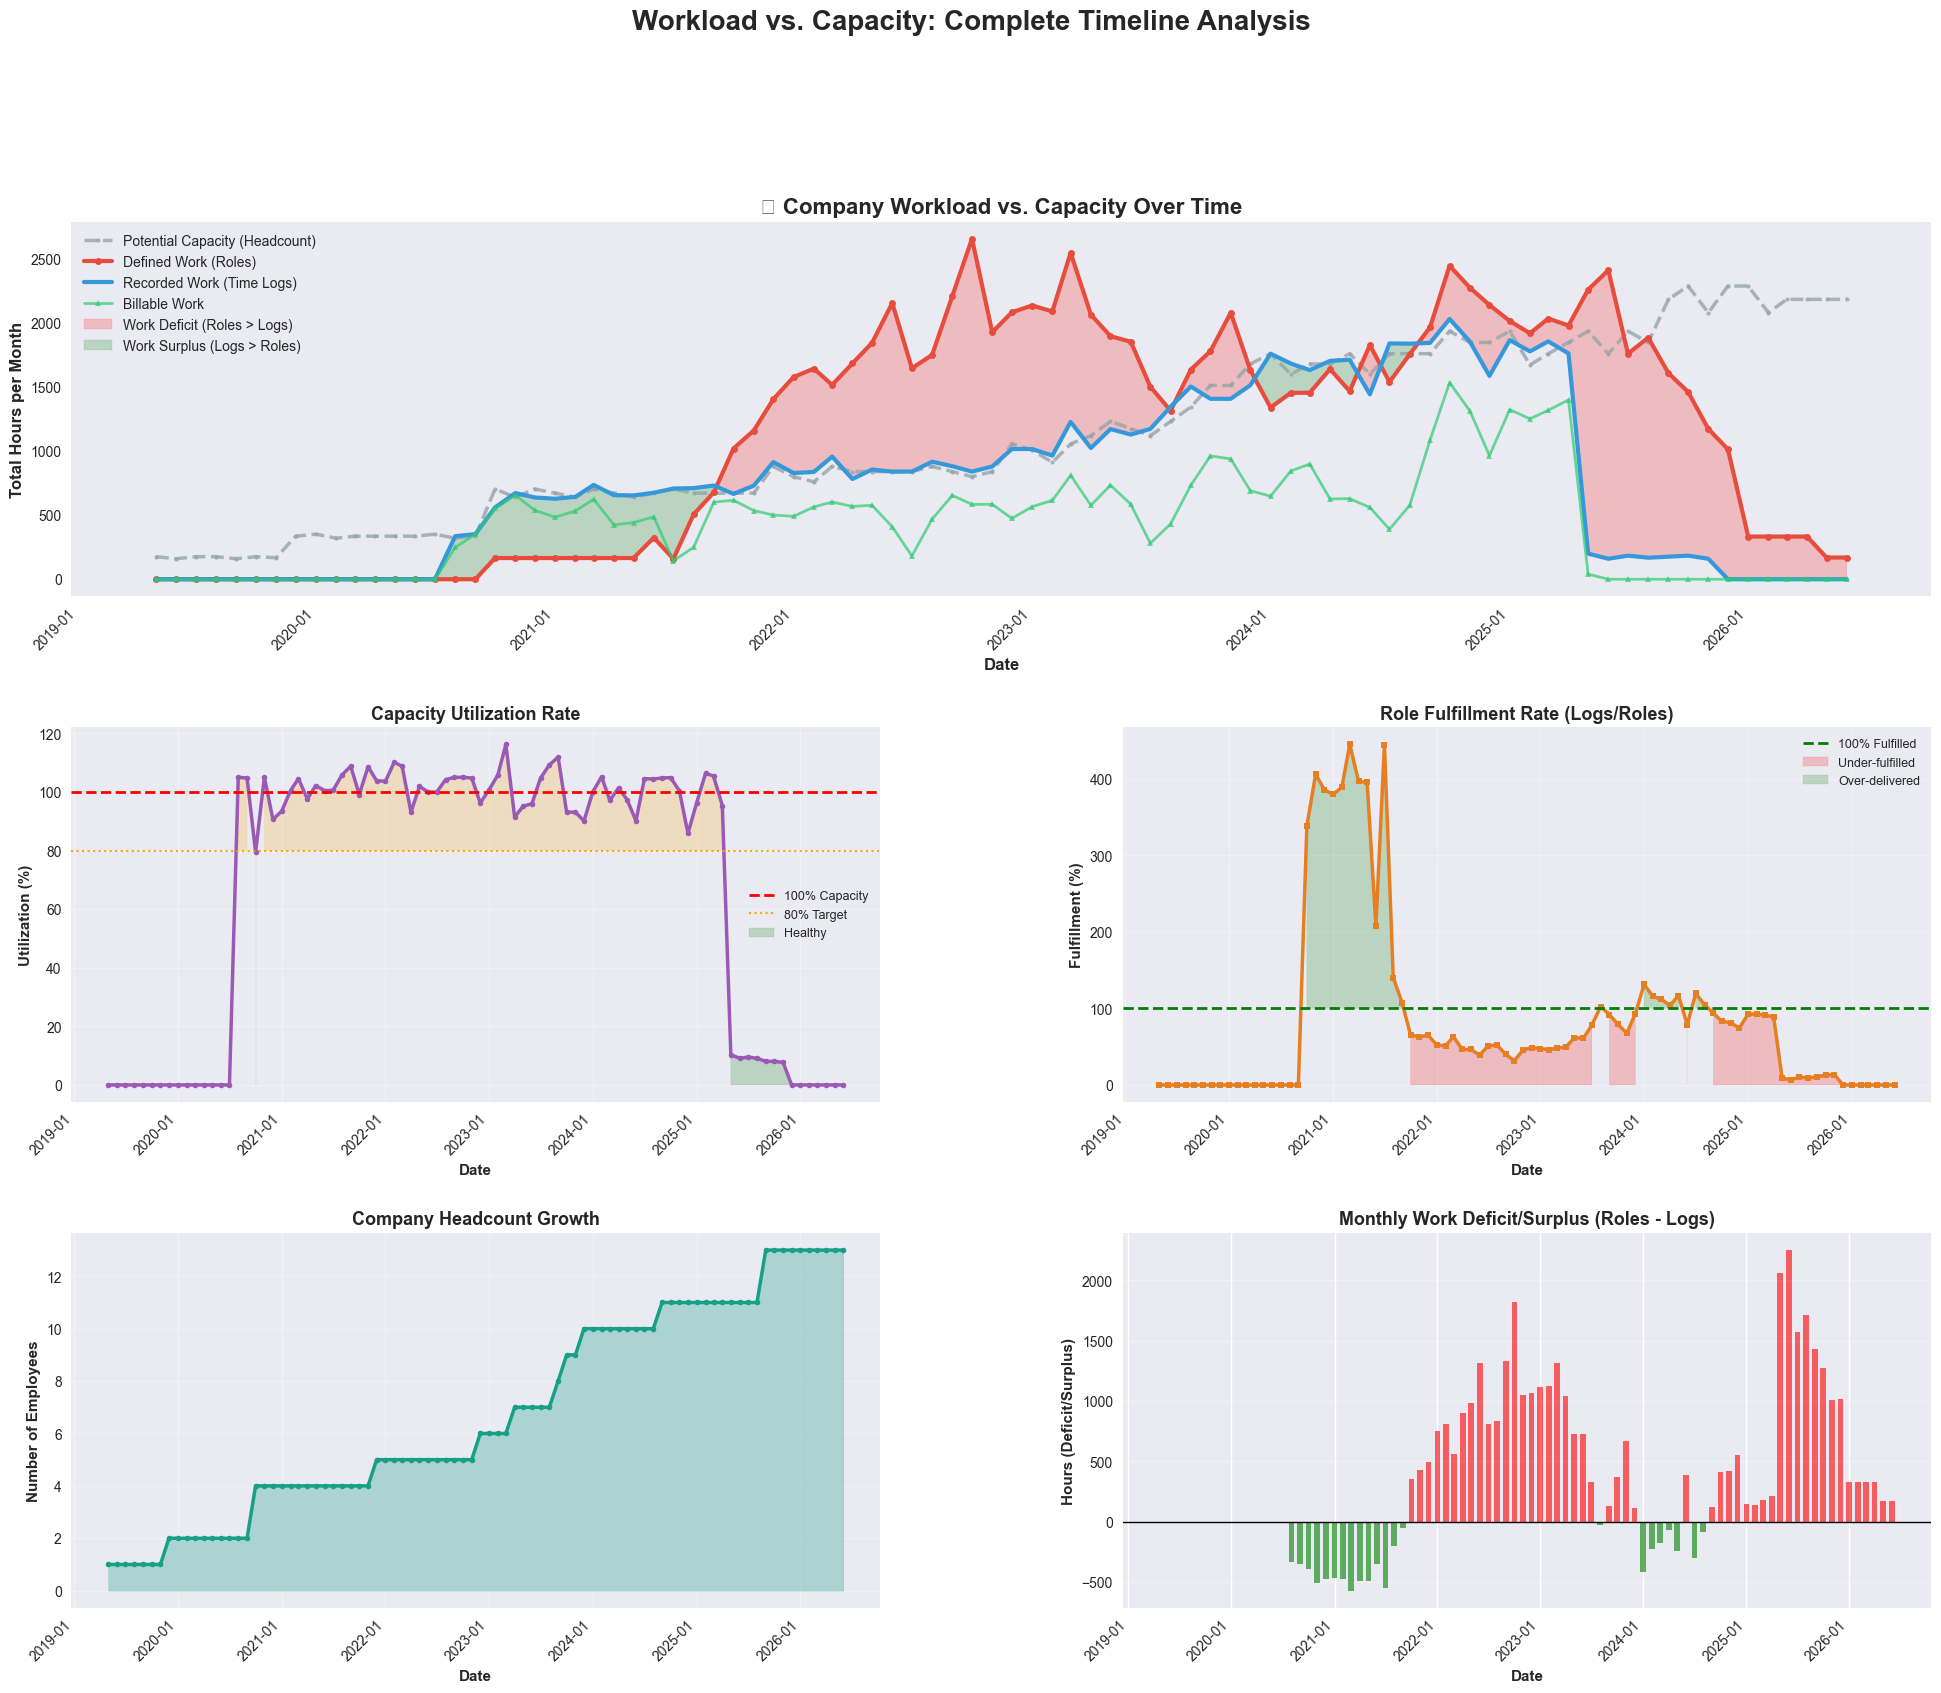


=== SAVING TIMELINE ANALYSIS ===

✓ Saved timeline analysis to: ..\data\processed\linking_tables\analysis__workload_vs_capacity_timeline__20251007.csv
  Rows: 86
  Date range: 2019-05-01 to 2026-06-01

✅ WORKLOAD VS. CAPACITY TIMELINE ANALYSIS COMPLETE

📋 DataFrame created: df_combined (accessible for further analysis)


In [13]:
print("📊 WORKLOAD VS. CAPACITY OVER TIME VISUALIZATION")
print("="*80)
print("Comparing defined work (roles), recorded work (time logs), and potential capacity (HR headcount)\n")
import matplotlib.dates as mdates
# --- Hyperparameters ---
DAILY_WORK_CAPACITY_HOURS = 8
print(f"Daily work capacity assumption: {DAILY_WORK_CAPACITY_HOURS} hours\n")

# --- 1. Calculate Potential Capacity Over Time from HR Data ---
print("[1] Calculating historical company capacity based on headcount...")

# Ensure HR dates are in datetime format
df_hr_timeline = df_hr.copy()
df_hr_timeline['joined_company_date'] = pd.to_datetime(df_hr_timeline['startdate']).dt.tz_localize(None)

# Get timeline boundaries
hr_start_date = df_hr_timeline['joined_company_date'].min()
time_end_date = pd.to_datetime(df_time_entries['dt']).max().tz_localize(None)
roles_end_date = pd.to_datetime(df_roles_enriched['enddate']).max().tz_localize(None)
end_date = max(time_end_date, roles_end_date)

print(f"✓ Analysis period: {hr_start_date.date()} to {end_date.date()}")

# Create monthly timeline
monthly_timeline = pd.date_range(start=hr_start_date, end=end_date, freq='MS')
capacity_data = []

for month_start in monthly_timeline:
    # Count employees who had joined by this month
    active_employees = (df_hr_timeline['joined_company_date'] <= month_start).sum()
    
    # Calculate business days in this month
    month_end = month_start + pd.offsets.MonthEnd(0)
    business_days = np.busday_count(
        month_start.date(),
        month_end.date()
    )
    
    # Calculate potential hours
    potential_hours = active_employees * business_days * DAILY_WORK_CAPACITY_HOURS
    
    capacity_data.append({
        'month': month_start,
        'active_employees': active_employees,
        'business_days': business_days,
        'potential_hours': potential_hours
    })

df_capacity_timeline = pd.DataFrame(capacity_data)
print(f"✓ Calculated capacity for {len(df_capacity_timeline)} months")
print(f"✓ Peak headcount: {df_capacity_timeline['active_employees'].max()} employees")
print(f"✓ Final potential hours: {df_capacity_timeline['potential_hours'].iloc[-1]:,.0f}h/month\n")

# --- 2. Aggregate Role Hours Over Time ---
# --- 2. Aggregate Role Hours Over Time (FIXED) ---
print("[2] Aggregating defined work (role hours) over time...")

# Create a monthly record for EACH role for EACH month it's active
role_monthly_distribution = []

for _, role in df_roles_enriched.iterrows():
    if pd.isna(role['startdate']) or pd.isna(role['enddate']):
        continue
    
    # Get all months the role spans
    role_start = pd.to_datetime(role['startdate']).tz_localize(None)
    role_end = pd.to_datetime(role['enddate']).tz_localize(None)
    
    # Create monthly range
    months_active = pd.date_range(
        start=role_start.to_period('M').to_timestamp(),
        end=role_end.to_period('M').to_timestamp(),
        freq='MS'
    )
    
    # Calculate hours per month (distribute evenly)
    hours_per_month = role['required_hours'] / len(months_active)
    
    # Add entry for each month
    for month in months_active:
        role_monthly_distribution.append({
            'month': month,
            'role_id': role['role_id'],
            'monthly_hours': hours_per_month
        })

df_role_monthly = pd.DataFrame(role_monthly_distribution)

# Now aggregate by month
role_hours_by_month = df_role_monthly.groupby('month').agg({
    'monthly_hours': 'sum',
    'role_id': 'count'
}).reset_index()
role_hours_by_month.rename(columns={
    'monthly_hours': 'defined_role_hours',
    'role_id': 'roles_active'
}, inplace=True)

print(f"✓ Distributed role hours across {len(role_hours_by_month)} months")
print(f"✓ Total defined role hours: {role_hours_by_month['defined_role_hours'].sum():,.0f}h")
print(f"✓ Peak monthly role hours: {role_hours_by_month['defined_role_hours'].max():,.0f}h\n")



print(f"✓ Aggregated {len(role_hours_by_month)} months of role data")
print(f"✓ Total defined role hours: {role_hours_by_month['defined_role_hours'].sum():,.0f}h")
print(f"✓ Peak monthly role hours: {role_hours_by_month['defined_role_hours'].max():,.0f}h\n")

# --- 3. Aggregate Logged Hours Over Time ---
print("[3] Aggregating recorded work (logged hours) over time...")

df_time_timeline = df_time_entries.copy()
df_time_timeline['dt'] = pd.to_datetime(df_time_timeline['dt']).dt.tz_localize(None)
df_time_timeline['month'] = df_time_timeline['dt'].dt.to_period('M').dt.to_timestamp()

logged_hours_by_month = df_time_timeline.groupby('month').agg({
    'hours': 'sum',
    'billable': lambda x: x[x == True].count(),
    'time_entry_id': 'count'
}).reset_index()
logged_hours_by_month.rename(columns={
    'hours': 'recorded_logged_hours',
    'billable': 'billable_entries',
    'time_entry_id': 'total_entries'
}, inplace=True)

# Calculate billable hours
billable_hours_by_month = df_time_timeline[df_time_timeline['billable'] == True].groupby('month')['hours'].sum().reset_index()
billable_hours_by_month.rename(columns={'hours': 'billable_hours'}, inplace=True)
# Calculate non-billable hours - ADD THIS
non_billable_hours_by_month = df_time_timeline[df_time_timeline['billable'] == False].groupby('month')['hours'].sum().reset_index()
non_billable_hours_by_month.rename(columns={'hours': 'non_billable_work_hours'}, inplace=True)

# Merge all together
logged_hours_by_month = logged_hours_by_month.merge(billable_hours_by_month, on='month', how='left').fillna(0)
logged_hours_by_month = logged_hours_by_month.merge(non_billable_hours_by_month, on='month', how='left').fillna(0) 

print(f"✓ Aggregated {len(logged_hours_by_month)} months of time entry data")
print(f"✓ Total logged hours: {logged_hours_by_month['recorded_logged_hours'].sum():,.0f}h")
print(f"✓ Total billable hours: {logged_hours_by_month['billable_hours'].sum():,.0f}h")
print(f"✓ Peak monthly logged hours: {logged_hours_by_month['recorded_logged_hours'].max():,.0f}h\n")

# --- 4. Combine All Data ---
print("[4] Combining all timelines...")

# Merge all dataframes
df_combined = df_capacity_timeline[['month', 'potential_hours', 'active_employees']].copy()
df_combined = df_combined.merge(role_hours_by_month, on='month', how='outer')
df_combined = df_combined.merge(logged_hours_by_month, on='month', how='outer')
df_combined = df_combined.sort_values('month').fillna(0)

# Calculate derived metrics
df_combined['work_deficit'] = df_combined['defined_role_hours'] - df_combined['recorded_logged_hours']
df_combined['capacity_utilization_pct'] = np.where(
    df_combined['potential_hours'] > 0,
    (df_combined['recorded_logged_hours'] / df_combined['potential_hours']) * 100,
    0
)
df_combined['role_fulfillment_pct'] = np.where(
    df_combined['defined_role_hours'] > 0,
    (df_combined['recorded_logged_hours'] / df_combined['defined_role_hours']) * 100,
    0
)

print(f"✓ Combined timeline with {len(df_combined)} months\n")

# --- 5. Statistics Summary ---
print("=== TIMELINE STATISTICS ===\n")

total_capacity = df_combined['potential_hours'].sum()
total_defined = df_combined['defined_role_hours'].sum()
total_logged = df_combined['recorded_logged_hours'].sum()
total_billable = df_combined['billable_hours'].sum()

print(f"📈 TOTALS ACROSS ALL MONTHS:")
print(f"   • Potential Capacity (Headcount): {total_capacity:,.0f}h")
print(f"   • Defined Work (Roles): {total_defined:,.0f}h")
print(f"   • Recorded Work (Logs): {total_logged:,.0f}h")
print(f"   • Billable Work: {total_billable:,.0f}h")
print()

print(f"📊 OVERALL RATES:")
print(f"   • Capacity Utilization: {(total_logged/total_capacity*100) if total_capacity > 0 else 0:.1f}%")
print(f"   • Role Fulfillment: {(total_logged/total_defined*100) if total_defined > 0 else 0:.1f}%")
print(f"   • Billable Rate: {(total_billable/total_logged*100) if total_logged > 0 else 0:.1f}%")
print()

avg_capacity_util = df_combined['capacity_utilization_pct'].mean()
avg_fulfillment = df_combined['role_fulfillment_pct'].mean()

print(f"📆 MONTHLY AVERAGES:")
print(f"   • Avg Potential Hours: {df_combined['potential_hours'].mean():,.0f}h/month")
print(f"   • Avg Role Hours: {df_combined['defined_role_hours'].mean():,.0f}h/month")
print(f"   • Avg Logged Hours: {df_combined['recorded_logged_hours'].mean():,.0f}h/month")
print(f"   • Avg Capacity Utilization: {avg_capacity_util:.1f}%")
print(f"   • Avg Role Fulfillment: {avg_fulfillment:.1f}%")
print()

# --- 6. Create Comprehensive Visualization ---
print("=== STEP 6: CREATING VISUALIZATIONS ===\n")

fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# 1. PRIMARY: Timeline Comparison (Full Width)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_combined['month'], df_combined['potential_hours'], 
         label='Potential Capacity (Headcount)', color='#95A5A6', 
         linestyle='--', linewidth=2.5, marker='.', markersize=6, alpha=0.8)
ax1.plot(df_combined['month'], df_combined['defined_role_hours'], 
         label='Defined Work (Roles)', color='#E74C3C', 
         linewidth=3, marker='o', markersize=5)
ax1.plot(df_combined['month'], df_combined['recorded_logged_hours'], 
         label='Recorded Work (Time Logs)', color='#3498DB', 
         linewidth=3, marker='x', markersize=5)
ax1.plot(df_combined['month'], df_combined['billable_hours'], 
         label='Billable Work', color='#2ECC71', 
         linewidth=2, marker='^', markersize=4, alpha=0.7)

# Fill areas
ax1.fill_between(df_combined['month'], 
                  df_combined['defined_role_hours'], 
                  df_combined['recorded_logged_hours'],
                  where=(df_combined['defined_role_hours'] > df_combined['recorded_logged_hours']),
                  color='red', alpha=0.2, interpolate=True, label='Work Deficit (Roles > Logs)')
ax1.fill_between(df_combined['month'], 
                  df_combined['defined_role_hours'], 
                  df_combined['recorded_logged_hours'],
                  where=(df_combined['defined_role_hours'] <= df_combined['recorded_logged_hours']),
                  color='green', alpha=0.2, interpolate=True, label='Work Surplus (Logs > Roles)')

ax1.set_ylabel('Total Hours per Month', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_title('🎯 Company Workload vs. Capacity Over Time', fontsize=16, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. Capacity Utilization Over Time
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df_combined['month'], df_combined['capacity_utilization_pct'], 
         color='#9B59B6', linewidth=2.5, marker='o', markersize=4)
ax2.axhline(y=100, color='red', linestyle='--', linewidth=2, label='100% Capacity')
ax2.axhline(y=80, color='orange', linestyle=':', linewidth=1.5, label='80% Target')
ax2.fill_between(df_combined['month'], 0, df_combined['capacity_utilization_pct'],
                  where=(df_combined['capacity_utilization_pct'] <= 80),
                  alpha=0.2, color='green', label='Healthy')
ax2.fill_between(df_combined['month'], 80, df_combined['capacity_utilization_pct'],
                  where=(df_combined['capacity_utilization_pct'] > 80),
                  alpha=0.2, color='orange')
ax2.set_ylabel('Utilization (%)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_title('Capacity Utilization Rate', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Role Fulfillment Rate
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(df_combined['month'], df_combined['role_fulfillment_pct'], 
         color='#E67E22', linewidth=2.5, marker='s', markersize=4)
ax3.axhline(y=100, color='green', linestyle='--', linewidth=2, label='100% Fulfilled')
ax3.fill_between(df_combined['month'], 0, df_combined['role_fulfillment_pct'],
                  where=(df_combined['role_fulfillment_pct'] < 100),
                  alpha=0.2, color='red', label='Under-fulfilled')
ax3.fill_between(df_combined['month'], 100, df_combined['role_fulfillment_pct'],
                  where=(df_combined['role_fulfillment_pct'] >= 100),
                  alpha=0.2, color='green', label='Over-delivered')
ax3.set_ylabel('Fulfillment (%)', fontsize=11, fontweight='bold')
ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_title('Role Fulfillment Rate (Logs/Roles)', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# 4. Active Employees Over Time
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(df_combined['month'], df_combined['active_employees'], 
         color='#16A085', linewidth=2.5, marker='o', markersize=4)
ax4.fill_between(df_combined['month'], 0, df_combined['active_employees'],
                  alpha=0.3, color='#16A085')
ax4.set_ylabel('Number of Employees', fontsize=11, fontweight='bold')
ax4.set_xlabel('Date', fontsize=11, fontweight='bold')
ax4.set_title('Company Headcount Growth', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# 5. Work Deficit/Surplus
ax5 = fig.add_subplot(gs[2, 1])
colors_deficit = ['green' if x <= 0 else 'red' for x in df_combined['work_deficit']]
ax5.bar(df_combined['month'], df_combined['work_deficit'], 
        color=colors_deficit, alpha=0.6, width=20)
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax5.set_ylabel('Hours (Deficit/Surplus)', fontsize=11, fontweight='bold')
ax5.set_xlabel('Date', fontsize=11, fontweight='bold')
ax5.set_title('Monthly Work Deficit/Surplus (Roles - Logs)', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Workload vs. Capacity: Complete Timeline Analysis', 
             fontsize=20, fontweight='bold', y=0.998)
plt.show()

# --- 7. Save Timeline Data ---
print("\n=== SAVING TIMELINE ANALYSIS ===\n")

timeline_path = output_dir / f"analysis__workload_vs_capacity_timeline__{timestamp}.csv"
df_combined.to_csv(timeline_path, index=False)
print(f"✓ Saved timeline analysis to: {timeline_path}")
print(f"  Rows: {len(df_combined)}")
print(f"  Date range: {df_combined['month'].min().date()} to {df_combined['month'].max().date()}")

print("\n" + "="*80)
print("✅ WORKLOAD VS. CAPACITY TIMELINE ANALYSIS COMPLETE")
print("="*80)
print("\n📋 DataFrame created: df_combined (accessible for further analysis)")
print("="*80)

Of course. Here is a breakdown of how the key work-related variables are created in the selected cell.

This cell calculates three primary measures of work on a monthly basis:

1.  **Potential Capacity (`potential_hours`)**: This represents the theoretical maximum work hours available based on company headcount.
2.  **Defined Work (`defined_role_hours`)**: This represents the planned work demand based on all defined roles.
3.  **Recorded Work (`recorded_logged_hours`)**: This represents the actual work performed as recorded in time logs.

Here is how each is calculated:

### 1. Potential Capacity (`potential_hours` in `df_capacity_timeline`)

This variable estimates the total available work hours in the company for each month.

*   **Source Data**: `df_hr` (HR records with employee start dates).
*   **Process**:
    1.  A monthly timeline is created for the entire analysis period.
    2.  The code iterates through each month in this timeline.
    3.  For each month, it counts the number of `active_employees` by summing up everyone in `df_hr` whose start date is on or before the first day of that month.
    4.  It calculates the number of `business_days` for that specific month.
    5.  The final `potential_hours` is calculated with the formula:
        `potential_hours = active_employees * business_days * DAILY_WORK_CAPACITY_HOURS` (where `DAILY_WORK_CAPACITY_HOURS` is 8).

### 2. Defined Work (`defined_role_hours` in `role_hours_by_month`)

This variable quantifies the total hours of planned work from the roles table for each month.

*   **Source Data**: `df_roles_enriched` (which contains the `required_hours` for each role, calculated in a previous cell).
*   **Process**:
    1.  The code iterates through every role in `df_roles_enriched`.
    2.  For each role, it identifies all the months it was active based on its start and end dates.
    3.  It then distributes the role's total `required_hours` evenly across each of those active months.
    4.  Finally, it groups all these monthly hour fragments by `month` and sums them up to get the total `defined_role_hours` for each month.

### 3. Recorded Work (`recorded_logged_hours` in `logged_hours_by_month`)

This variable is the most straightforward. It represents the ground truth of hours logged by employees.

*   **Source Data**: `df_time_entries` (the raw time log data).
*   **Process**:
    1.  A `month` column is added to the `df_time_entries` DataFrame based on the date of each entry.
    2.  The DataFrame is then grouped by this `month` column.
    3.  The `hours` for each group are summed to get the `recorded_logged_hours` for each month.
    4.  The same process is repeated after filtering for `billable == True` and `billable == False` to also calculate `billable_hours` and `non_billable_work_hours`.

Finally, these three monthly summaries are merged into a single DataFrame, `df_combined`, which is then used for the visualizations. The variables appear to be created correctly based on the logic in your notebook.

=== STEP 6: CREATING VISUALIZATIONS ===



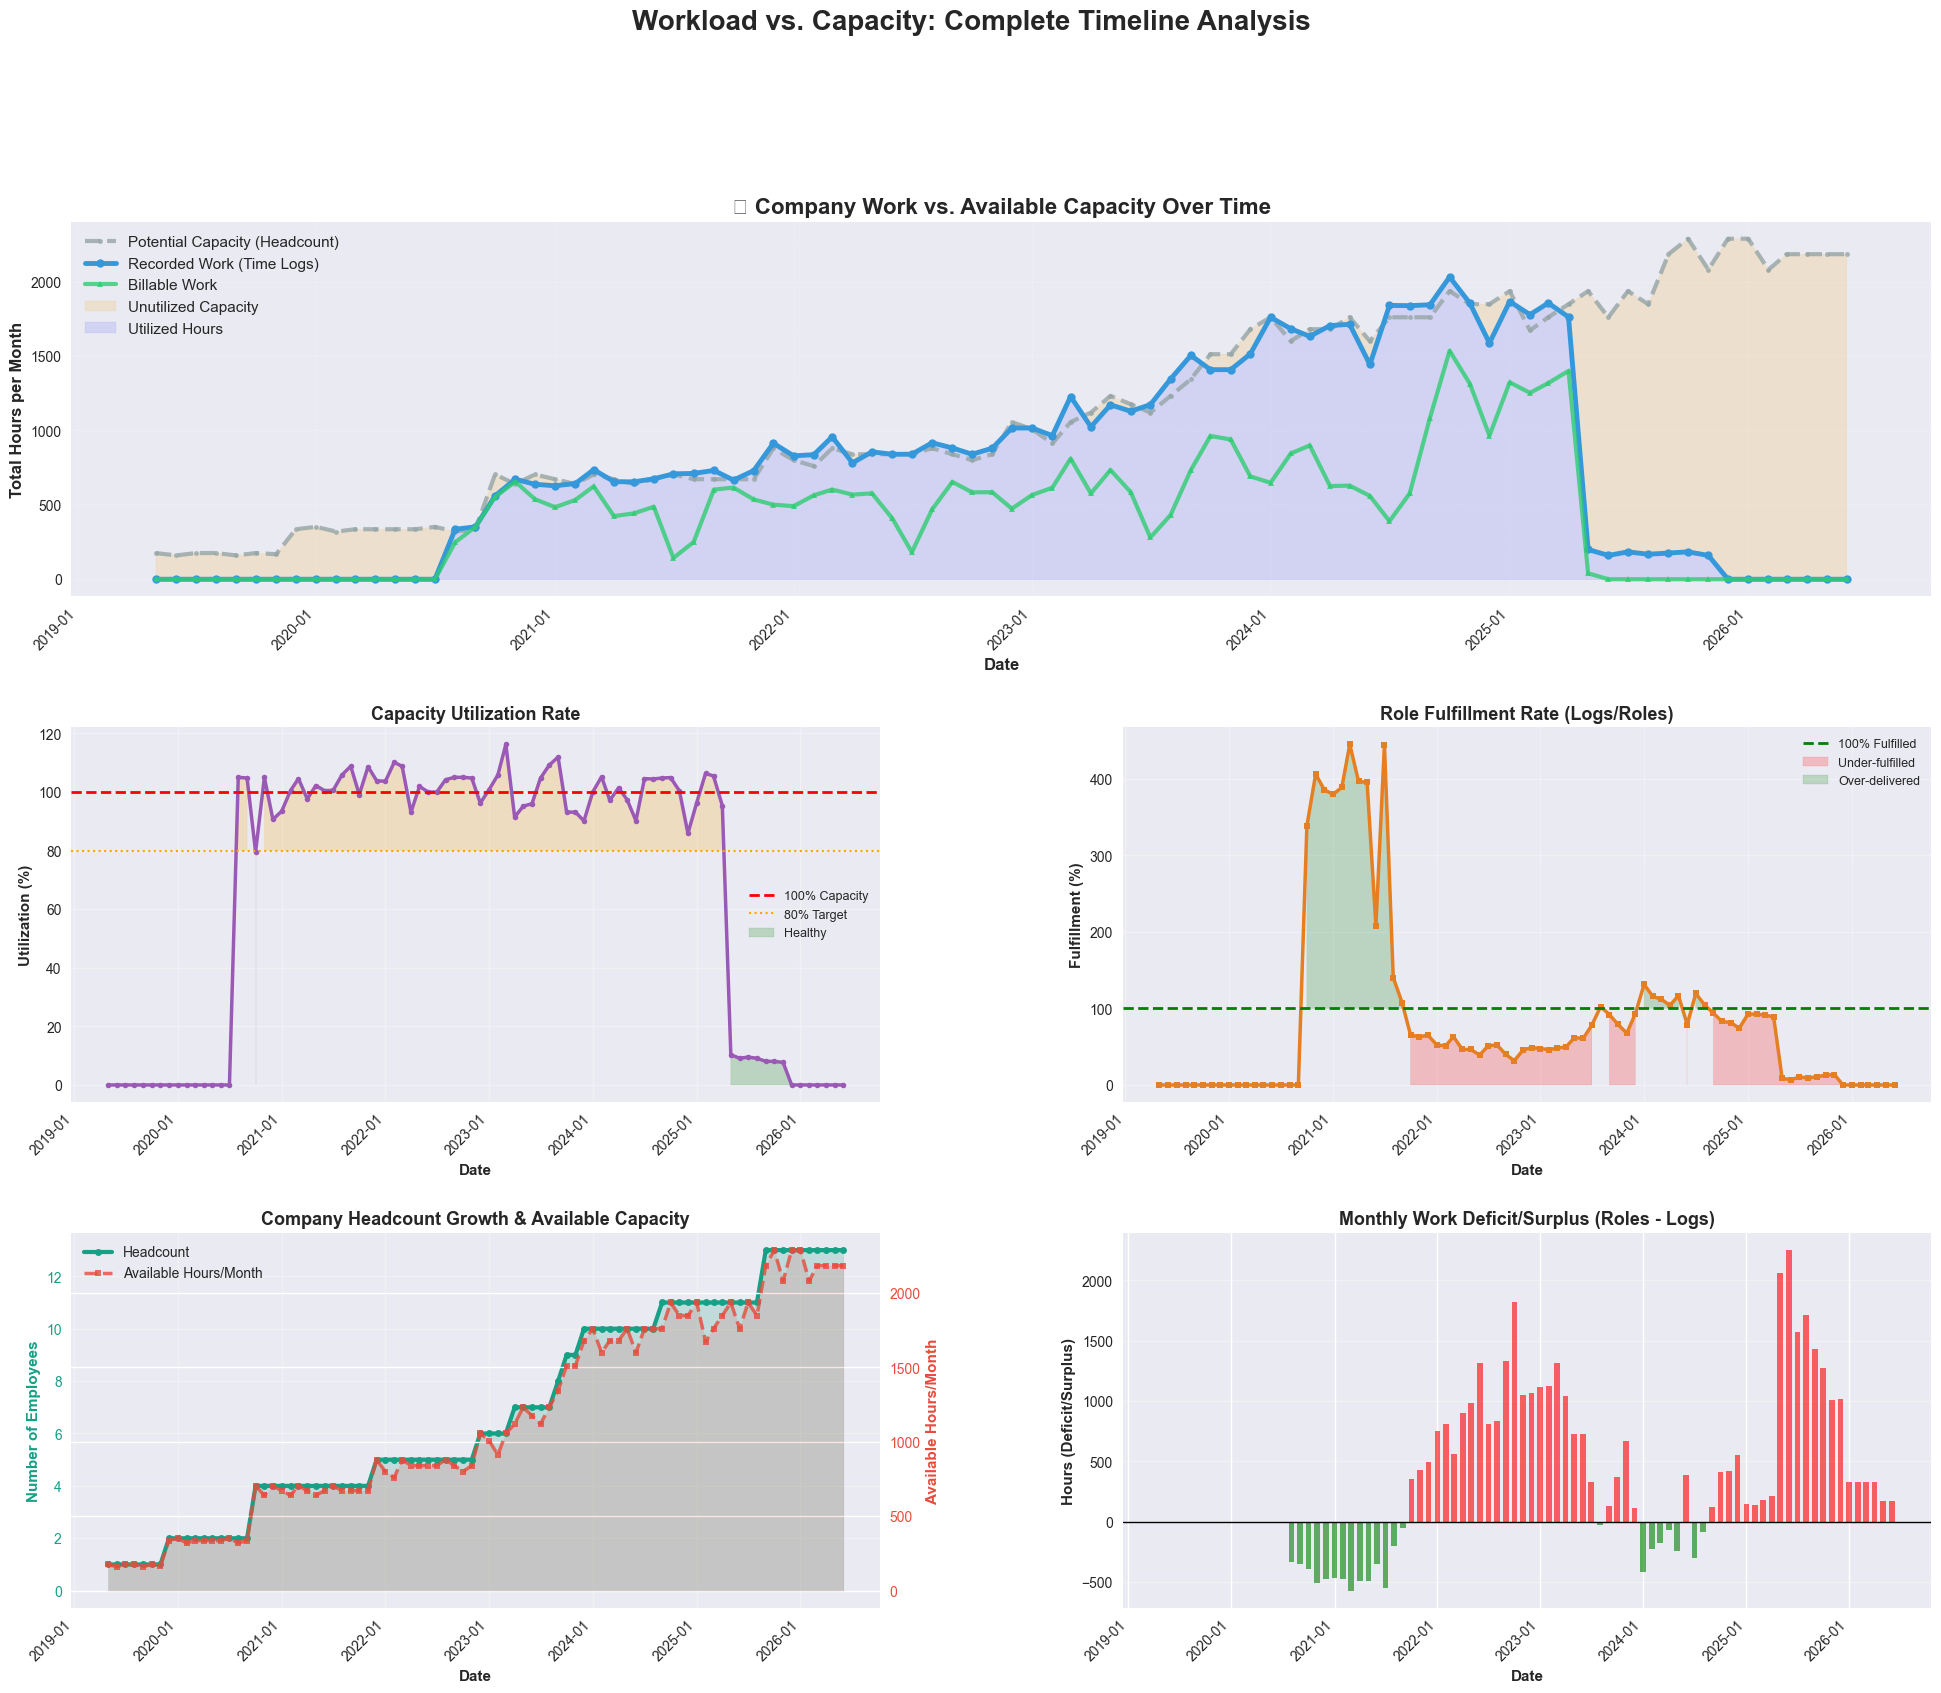


=== SAVING TIMELINE ANALYSIS ===

✓ Saved timeline analysis to: ..\data\processed\linking_tables\analysis__workload_vs_capacity_timeline__20251007.csv
  Rows: 86
  Date range: 2019-05-01 to 2026-06-01

✅ WORKLOAD VS. CAPACITY TIMELINE ANALYSIS COMPLETE

📋 DataFrame created: df_combined (accessible for further analysis)


In [14]:
# --- 6. Create Comprehensive Visualization (UPDATED) ---
print("=== STEP 6: CREATING VISUALIZATIONS ===\n")

fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# 1. PRIMARY: Timeline Comparison - WITHOUT ROLES (Full Width)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_combined['month'], df_combined['potential_hours'], 
         label='Potential Capacity (Headcount)', color='#95A5A6', 
         linestyle='--', linewidth=3, marker='.', markersize=7, alpha=0.8)
ax1.plot(df_combined['month'], df_combined['recorded_logged_hours'], 
         label='Recorded Work (Time Logs)', color='#3498DB', 
         linewidth=3.5, marker='o', markersize=6)
ax1.plot(df_combined['month'], df_combined['billable_hours'], 
         label='Billable Work', color='#2ECC71', 
         linewidth=3, marker='^', markersize=5, alpha=0.8)

# Fill area between capacity and actual work
ax1.fill_between(df_combined['month'], 
                  df_combined['potential_hours'], 
                  df_combined['recorded_logged_hours'],
                  where=(df_combined['recorded_logged_hours'] < df_combined['potential_hours']),
                  color='orange', alpha=0.15, interpolate=True, label='Unutilized Capacity')
ax1.fill_between(df_combined['month'], 
                  0,
                  df_combined['recorded_logged_hours'],
                  color='blue', alpha=0.1, interpolate=True, label='Utilized Hours')

ax1.set_ylabel('Total Hours per Month', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_title('🎯 Company Work vs. Available Capacity Over Time', fontsize=16, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. Capacity Utilization Over Time
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df_combined['month'], df_combined['capacity_utilization_pct'], 
         color='#9B59B6', linewidth=2.5, marker='o', markersize=4)
ax2.axhline(y=100, color='red', linestyle='--', linewidth=2, label='100% Capacity')
ax2.axhline(y=80, color='orange', linestyle=':', linewidth=1.5, label='80% Target')
ax2.fill_between(df_combined['month'], 0, df_combined['capacity_utilization_pct'],
                  where=(df_combined['capacity_utilization_pct'] <= 80),
                  alpha=0.2, color='green', label='Healthy')
ax2.fill_between(df_combined['month'], 80, df_combined['capacity_utilization_pct'],
                  where=(df_combined['capacity_utilization_pct'] > 80),
                  alpha=0.2, color='orange')
ax2.set_ylabel('Utilization (%)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_title('Capacity Utilization Rate', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Role Fulfillment Rate
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(df_combined['month'], df_combined['role_fulfillment_pct'], 
         color='#E67E22', linewidth=2.5, marker='s', markersize=4)
ax3.axhline(y=100, color='green', linestyle='--', linewidth=2, label='100% Fulfilled')
ax3.fill_between(df_combined['month'], 0, df_combined['role_fulfillment_pct'],
                  where=(df_combined['role_fulfillment_pct'] < 100),
                  alpha=0.2, color='red', label='Under-fulfilled')
ax3.fill_between(df_combined['month'], 100, df_combined['role_fulfillment_pct'],
                  where=(df_combined['role_fulfillment_pct'] >= 100),
                  alpha=0.2, color='green', label='Over-delivered')
ax3.set_ylabel('Fulfillment (%)', fontsize=11, fontweight='bold')
ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_title('Role Fulfillment Rate (Logs/Roles)', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# 4. UPDATED: Headcount Growth + Available Hours (Dual Y-Axis)
ax4 = fig.add_subplot(gs[2, 0])
ax4_twin = ax4.twinx()

# Plot headcount on primary y-axis
line1 = ax4.plot(df_combined['month'], df_combined['active_employees'], 
                 color='#16A085', linewidth=3, marker='o', markersize=5, label='Headcount')
ax4.fill_between(df_combined['month'], 0, df_combined['active_employees'],
                  alpha=0.2, color='#16A085')

# Plot available hours on secondary y-axis
line2 = ax4_twin.plot(df_combined['month'], df_combined['potential_hours'], 
                      color='#E74C3C', linewidth=2.5, marker='s', markersize=4, 
                      linestyle='--', alpha=0.8, label='Available Hours/Month')
ax4_twin.fill_between(df_combined['month'], 0, df_combined['potential_hours'],
                       alpha=0.15, color='#E74C3C')

# Formatting
ax4.set_ylabel('Number of Employees', fontsize=11, fontweight='bold', color='#16A085')
ax4_twin.set_ylabel('Available Hours/Month', fontsize=11, fontweight='bold', color='#E74C3C')
ax4.set_xlabel('Date', fontsize=11, fontweight='bold')
ax4.set_title('Company Headcount Growth & Available Capacity', fontsize=13, fontweight='bold')
ax4.tick_params(axis='y', labelcolor='#16A085')
ax4_twin.tick_params(axis='y', labelcolor='#E74C3C')

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, fontsize=10, loc='upper left')

ax4.grid(True, alpha=0.3)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# 5. Work Deficit/Surplus
ax5 = fig.add_subplot(gs[2, 1])
colors_deficit = ['green' if x <= 0 else 'red' for x in df_combined['work_deficit']]
ax5.bar(df_combined['month'], df_combined['work_deficit'], 
        color=colors_deficit, alpha=0.6, width=20)
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax5.set_ylabel('Hours (Deficit/Surplus)', fontsize=11, fontweight='bold')
ax5.set_xlabel('Date', fontsize=11, fontweight='bold')
ax5.set_title('Monthly Work Deficit/Surplus (Roles - Logs)', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Workload vs. Capacity: Complete Timeline Analysis', 
             fontsize=20, fontweight='bold', y=0.998)
plt.show()

# --- 7. Save Timeline Data ---
print("\n=== SAVING TIMELINE ANALYSIS ===\n")

timeline_path = output_dir / f"analysis__workload_vs_capacity_timeline__{timestamp}.csv"
df_combined.to_csv(timeline_path, index=False)
print(f"✓ Saved timeline analysis to: {timeline_path}")
print(f"  Rows: {len(df_combined)}")
print(f"  Date range: {df_combined['month'].min().date()} to {df_combined['month'].max().date()}")

print("\n" + "="*80)
print("✅ WORKLOAD VS. CAPACITY TIMELINE ANALYSIS COMPLETE")
print("="*80)
print("\n📋 DataFrame created: df_combined (accessible for further analysis)")
print("="*80)

📊 CAPACITY UTILIZATION: BILLABLE VS NON-BILLABLE WORK
Visualizing how available capacity is utilized by billable and non-billable work

[1] Calculating billable and non-billable hours breakdown...
✓ Calculated utilization breakdown for 86 months
✓ Total billable hours: 37,478h
✓ Total non-billable hours: 28,317h

[2] Identifying hiring events...
✓ Found 13 hiring events in timeline
✓ First hire: 2019-05-01
✓ Last hire: 2025-09-01

=== CREATING CAPACITY UTILIZATION VISUALIZATION ===



c:\Users\guine\Documents\BC#4\Hyper_python\BI project\Data-Edge-BI-analysis\Data-Edge-BI-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


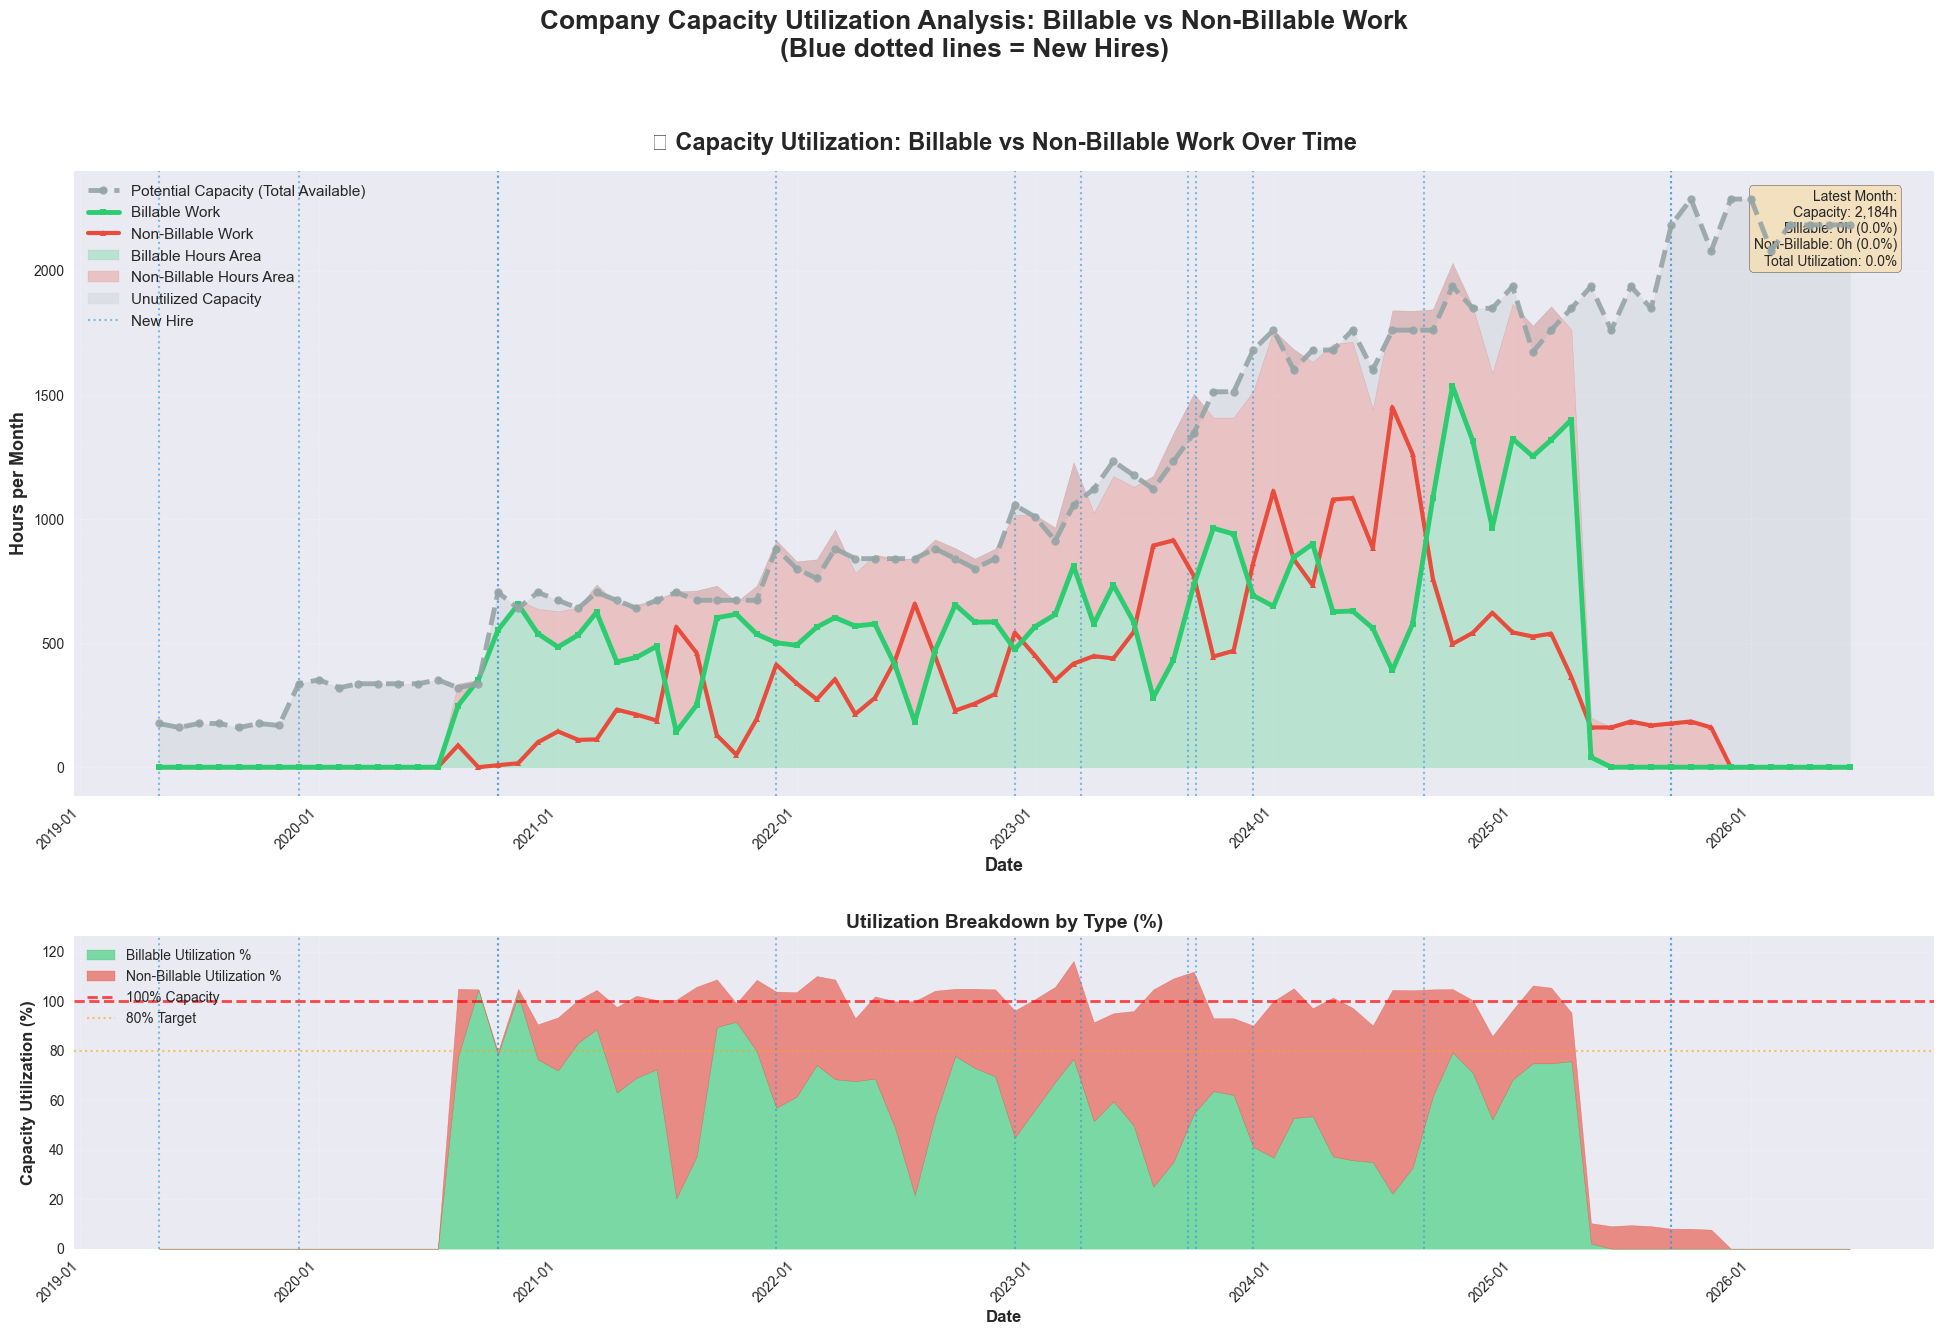


=== KEY STATISTICS: BILLABLE VS NON-BILLABLE ===

📊 OVERALL TOTALS:
   • Total Potential Capacity: 97,624h
   • Total Billable Work: 37,478h (38.4% of capacity)
   • Total Non-Billable Work: 28,317h (29.0% of capacity)
   • Total Work Logged: 65,796h
   • Overall Utilization: 67.4%

💼 WORK COMPOSITION:
   • Billable %: 57.0% of total work
   • Non-Billable %: 43.0% of total work

📈 MONTHLY AVERAGES:
   • Avg Billable Utilization: 40.7%
   • Avg Non-Billable Utilization: 26.9%
   • Avg Total Utilization: 67.6%

👥 HIRING EVENTS:
   • Total hires in period: 13
   • Hiring rate: 1.8 hires/year

=== SAVING ENHANCED CAPACITY DATA ===

✓ Saved billable/non-billable breakdown to: ..\data\processed\linking_tables\analysis__capacity_utilization_billable_split__20251006.csv
  Rows: 86

✅ CAPACITY UTILIZATION ANALYSIS COMPLETE

📋 DataFrame created: df_capacity_split (accessible for further analysis)


In [ ]:
print("="*80)
print("📊 CAPACITY UTILIZATION: BILLABLE VS NON-BILLABLE WORK")
print("="*80)
print("Visualizing how available capacity is utilized by billable and non-billable work\n")

# --- Calculate billable and non-billable hours by month ---
print("[1] Calculating billable and non-billable hours breakdown...")

df_time_billable_split = df_time_entries.copy()
df_time_billable_split['dt'] = pd.to_datetime(df_time_billable_split['dt']).dt.tz_localize(None)
df_time_billable_split['month'] = df_time_billable_split['dt'].dt.to_period('M').dt.to_timestamp()

# Aggregate billable and non-billable separately
billable_monthly = df_time_billable_split[df_time_billable_split['billable'] == True].groupby('month')['hours'].sum().reset_index()
billable_monthly.rename(columns={'hours': 'billable_work_hours'}, inplace=True)

non_billable_monthly = df_time_billable_split[df_time_billable_split['billable'] == False].groupby('month')['hours'].sum().reset_index()
non_billable_monthly.rename(columns={'hours': 'non_billable_work_hours'}, inplace=True)

# Merge with capacity timeline
df_capacity_split = df_combined[['month', 'potential_hours', 'active_employees']].copy()
df_capacity_split = df_capacity_split.merge(billable_monthly, on='month', how='left')
df_capacity_split = df_capacity_split.merge(non_billable_monthly, on='month', how='left')
df_capacity_split.fillna(0, inplace=True)

# Calculate utilization rates
df_capacity_split['billable_utilization_pct'] = np.where(
    df_capacity_split['potential_hours'] > 0,
    (df_capacity_split['billable_work_hours'] / df_capacity_split['potential_hours']) * 100,
    0
)
df_capacity_split['non_billable_utilization_pct'] = np.where(
    df_capacity_split['potential_hours'] > 0,
    (df_capacity_split['non_billable_work_hours'] / df_capacity_split['potential_hours']) * 100,
    0
)
df_capacity_split['total_utilization_pct'] = df_capacity_split['billable_utilization_pct'] + df_capacity_split['non_billable_utilization_pct']

print(f"✓ Calculated utilization breakdown for {len(df_capacity_split)} months")
print(f"✓ Total billable hours: {df_capacity_split['billable_work_hours'].sum():,.0f}h")
print(f"✓ Total non-billable hours: {df_capacity_split['non_billable_work_hours'].sum():,.0f}h\n")

# --- Get hiring events ---
print("[2] Identifying hiring events...")

df_hr_hiring = df_hr.copy()
df_hr_hiring['hire_date'] = pd.to_datetime(df_hr_hiring['startdate']).dt.tz_localize(None)
df_hr_hiring = df_hr_hiring.sort_values('hire_date')

# Filter to timeline range
timeline_start = df_capacity_split['month'].min()
timeline_end = df_capacity_split['month'].max()
hiring_events = df_hr_hiring[
    (df_hr_hiring['hire_date'] >= timeline_start) & 
    (df_hr_hiring['hire_date'] <= timeline_end)
]['hire_date'].tolist()

print(f"✓ Found {len(hiring_events)} hiring events in timeline")
print(f"✓ First hire: {min(hiring_events).date() if hiring_events else 'N/A'}")
print(f"✓ Last hire: {max(hiring_events).date() if hiring_events else 'N/A'}\n")

# --- Create Enhanced Visualization ---
print("=== CREATING CAPACITY UTILIZATION VISUALIZATION ===\n")

fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(2, 1, hspace=0.3, height_ratios=[2, 1])

# --- MAIN CHART: Capacity vs Billable/Non-Billable Work ---
ax1 = fig.add_subplot(gs[0])

# Plot potential capacity
ax1.plot(df_capacity_split['month'], df_capacity_split['potential_hours'], 
         label='Potential Capacity (Total Available)', color='#95A5A6', 
         linestyle='--', linewidth=3.5, marker='o', markersize=6, alpha=0.9, zorder=5)

# Plot billable work
ax1.plot(df_capacity_split['month'], df_capacity_split['billable_work_hours'], 
         label='Billable Work', color='#2ECC71', 
         linewidth=3.5, marker='s', markersize=5, zorder=4)

# Plot non-billable work
ax1.plot(df_capacity_split['month'], df_capacity_split['non_billable_work_hours'], 
         label='Non-Billable Work', color='#E74C3C', 
         linewidth=3, marker='^', markersize=5, zorder=3)

# Fill areas
ax1.fill_between(df_capacity_split['month'], 0, 
                  df_capacity_split['billable_work_hours'],
                  alpha=0.25, color='#2ECC71', label='Billable Hours Area')
ax1.fill_between(df_capacity_split['month'], 
                  df_capacity_split['billable_work_hours'],
                  df_capacity_split['billable_work_hours'] + df_capacity_split['non_billable_work_hours'],
                  alpha=0.25, color='#E74C3C', label='Non-Billable Hours Area')
ax1.fill_between(df_capacity_split['month'], 
                  df_capacity_split['billable_work_hours'] + df_capacity_split['non_billable_work_hours'],
                  df_capacity_split['potential_hours'],
                  alpha=0.15, color='#95A5A6', label='Unutilized Capacity')

# Add vertical lines for hiring events
for i, hire_date in enumerate(hiring_events):
    label = 'New Hire' if i == 0 else None  # Only label first line for legend
    ax1.axvline(x=hire_date, color='#3498DB', linestyle=':', linewidth=1.5, 
                alpha=0.6, zorder=2, label=label)

# Formatting
ax1.set_ylabel('Hours per Month', fontsize=13, fontweight='bold')
ax1.set_xlabel('Date', fontsize=13, fontweight='bold')
ax1.set_title('🎯 Capacity Utilization: Billable vs Non-Billable Work Over Time', 
              fontsize=17, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='upper left', framealpha=0.95)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Add annotations for key metrics
total_capacity_final = df_capacity_split['potential_hours'].iloc[-1]
total_billable_final = df_capacity_split['billable_work_hours'].iloc[-1]
total_non_billable_final = df_capacity_split['non_billable_work_hours'].iloc[-1]
utilization_final = df_capacity_split['total_utilization_pct'].iloc[-1]

annotation_text = f"Latest Month:\nCapacity: {total_capacity_final:,.0f}h\nBillable: {total_billable_final:,.0f}h ({df_capacity_split['billable_utilization_pct'].iloc[-1]:.1f}%)\nNon-Billable: {total_non_billable_final:,.0f}h ({df_capacity_split['non_billable_utilization_pct'].iloc[-1]:.1f}%)\nTotal Utilization: {utilization_final:.1f}%"
ax1.text(0.98, 0.97, annotation_text, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# --- BOTTOM CHART: Utilization Percentages Stacked ---
ax2 = fig.add_subplot(gs[1])

# Stacked area chart for utilization percentages
ax2.fill_between(df_capacity_split['month'], 0, 
                  df_capacity_split['billable_utilization_pct'],
                  alpha=0.6, color='#2ECC71', label='Billable Utilization %')
ax2.fill_between(df_capacity_split['month'], 
                  df_capacity_split['billable_utilization_pct'],
                  df_capacity_split['total_utilization_pct'],
                  alpha=0.6, color='#E74C3C', label='Non-Billable Utilization %')

# Reference lines
ax2.axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.7, label='100% Capacity')
ax2.axhline(y=80, color='orange', linestyle=':', linewidth=1.5, alpha=0.6, label='80% Target')

# Add hiring event markers
for hire_date in hiring_events:
    ax2.axvline(x=hire_date, color='#3498DB', linestyle=':', linewidth=1.5, alpha=0.6, zorder=2)

# Formatting
ax2.set_ylabel('Capacity Utilization (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_title('Utilization Breakdown by Type (%)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left', framealpha=0.95)
ax2.set_ylim(0, max(110, df_capacity_split['total_utilization_pct'].max() + 10))
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Company Capacity Utilization Analysis: Billable vs Non-Billable Work\n(Blue dotted lines = New Hires)', 
             fontsize=19, fontweight='bold', y=0.995)
plt.show()

# --- Statistics Summary ---
print("\n=== KEY STATISTICS: BILLABLE VS NON-BILLABLE ===\n")

total_capacity_all = df_capacity_split['potential_hours'].sum()
total_billable_all = df_capacity_split['billable_work_hours'].sum()
total_non_billable_all = df_capacity_split['non_billable_work_hours'].sum()
total_work_all = total_billable_all + total_non_billable_all

print(f"📊 OVERALL TOTALS:")
print(f"   • Total Potential Capacity: {total_capacity_all:,.0f}h")
print(f"   • Total Billable Work: {total_billable_all:,.0f}h ({total_billable_all/total_capacity_all*100:.1f}% of capacity)")
print(f"   • Total Non-Billable Work: {total_non_billable_all:,.0f}h ({total_non_billable_all/total_capacity_all*100:.1f}% of capacity)")
print(f"   • Total Work Logged: {total_work_all:,.0f}h")
print(f"   • Overall Utilization: {total_work_all/total_capacity_all*100:.1f}%")
print()

print(f"💼 WORK COMPOSITION:")
print(f"   • Billable %: {total_billable_all/total_work_all*100:.1f}% of total work")
print(f"   • Non-Billable %: {total_non_billable_all/total_work_all*100:.1f}% of total work")
print()

avg_billable_util = df_capacity_split['billable_utilization_pct'].mean()
avg_non_billable_util = df_capacity_split['non_billable_utilization_pct'].mean()

print(f"📈 MONTHLY AVERAGES:")
print(f"   • Avg Billable Utilization: {avg_billable_util:.1f}%")
print(f"   • Avg Non-Billable Utilization: {avg_non_billable_util:.1f}%")
print(f"   • Avg Total Utilization: {df_capacity_split['total_utilization_pct'].mean():.1f}%")
print()

print(f"👥 HIRING EVENTS:")
print(f"   • Total hires in period: {len(hiring_events)}")
if hiring_events:
    print(f"   • Hiring rate: {len(hiring_events)/(len(df_capacity_split)/12):.1f} hires/year")
print()

# --- Save Enhanced Data ---
print("=== SAVING ENHANCED CAPACITY DATA ===\n")

capacity_split_path = output_dir / f"analysis__capacity_utilization_billable_split__{timestamp}.csv"
df_capacity_split.to_csv(capacity_split_path, index=False)
print(f"✓ Saved billable/non-billable breakdown to: {capacity_split_path}")
print(f"  Rows: {len(df_capacity_split)}")

print("\n" + "="*80)
print("✅ CAPACITY UTILIZATION ANALYSIS COMPLETE")
print("="*80)
print("\n📋 DataFrame created: df_capacity_split (accessible for further analysis)")
print("="*80)

📊 KEY PERFORMANCE INDICATORS (KPIs) ANALYSIS - BILLABLE CAPACITY BASED
Analyzing critical business metrics using BILLABLE HOURS as capacity measure

=== STEP 1: CALCULATING MONTHLY KPIs (BILLABLE-BASED) ===

✓ Calculated KPIs for 86 months

=== STEP 2: OVERALL KPI STATISTICS (BILLABLE-BASED) ===

📈 CUMULATIVE METRICS:
   • Total Potential Hours: 97,624h
   • Total Defined Role Hours: 96,304h
   • Total Billable Hours: 37,478h ⭐ (PRIMARY CAPACITY)
   • Total Non-Billable Hours: 28,317h
   • Total Logged Hours: 65,796h

🎯 KPI 1: BILLABLE CAPACITY UTILIZATION RATE
   Formula: (Billable Hours / Potential Hours) × 100
   • Overall Rate: 38.4%
   • Monthly Average: 40.7%
   • Median: 49.2%
   • Industry Target: 65-80% (consultancy best practice)
   ⚠️  ALERT: Under-utilized (38.4%) - Significant capacity waste

📋 NON-BILLABLE OVERHEAD:
   • Total: 29.0% of potential capacity
   • Typical range: 15-25%
   ✅ HEALTHY overhead level

📐 KPI 2: SCOPING ACCURACY (BILLABLE REALIZATION RATE)
   Formu

c:\Users\guine\Documents\BC#4\Hyper_python\BI project\Data-Edge-BI-analysis\Data-Edge-BI-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\guine\Documents\BC#4\Hyper_python\BI project\Data-Edge-BI-analysis\Data-Edge-BI-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\guine\Documents\BC#4\Hyper_python\BI project\Data-Edge-BI-analysis\Data-Edge-BI-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\guine\Documents\BC#4\Hyper_python\BI project\Data-Edge-BI-analysis\Data-Edge-BI-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELE

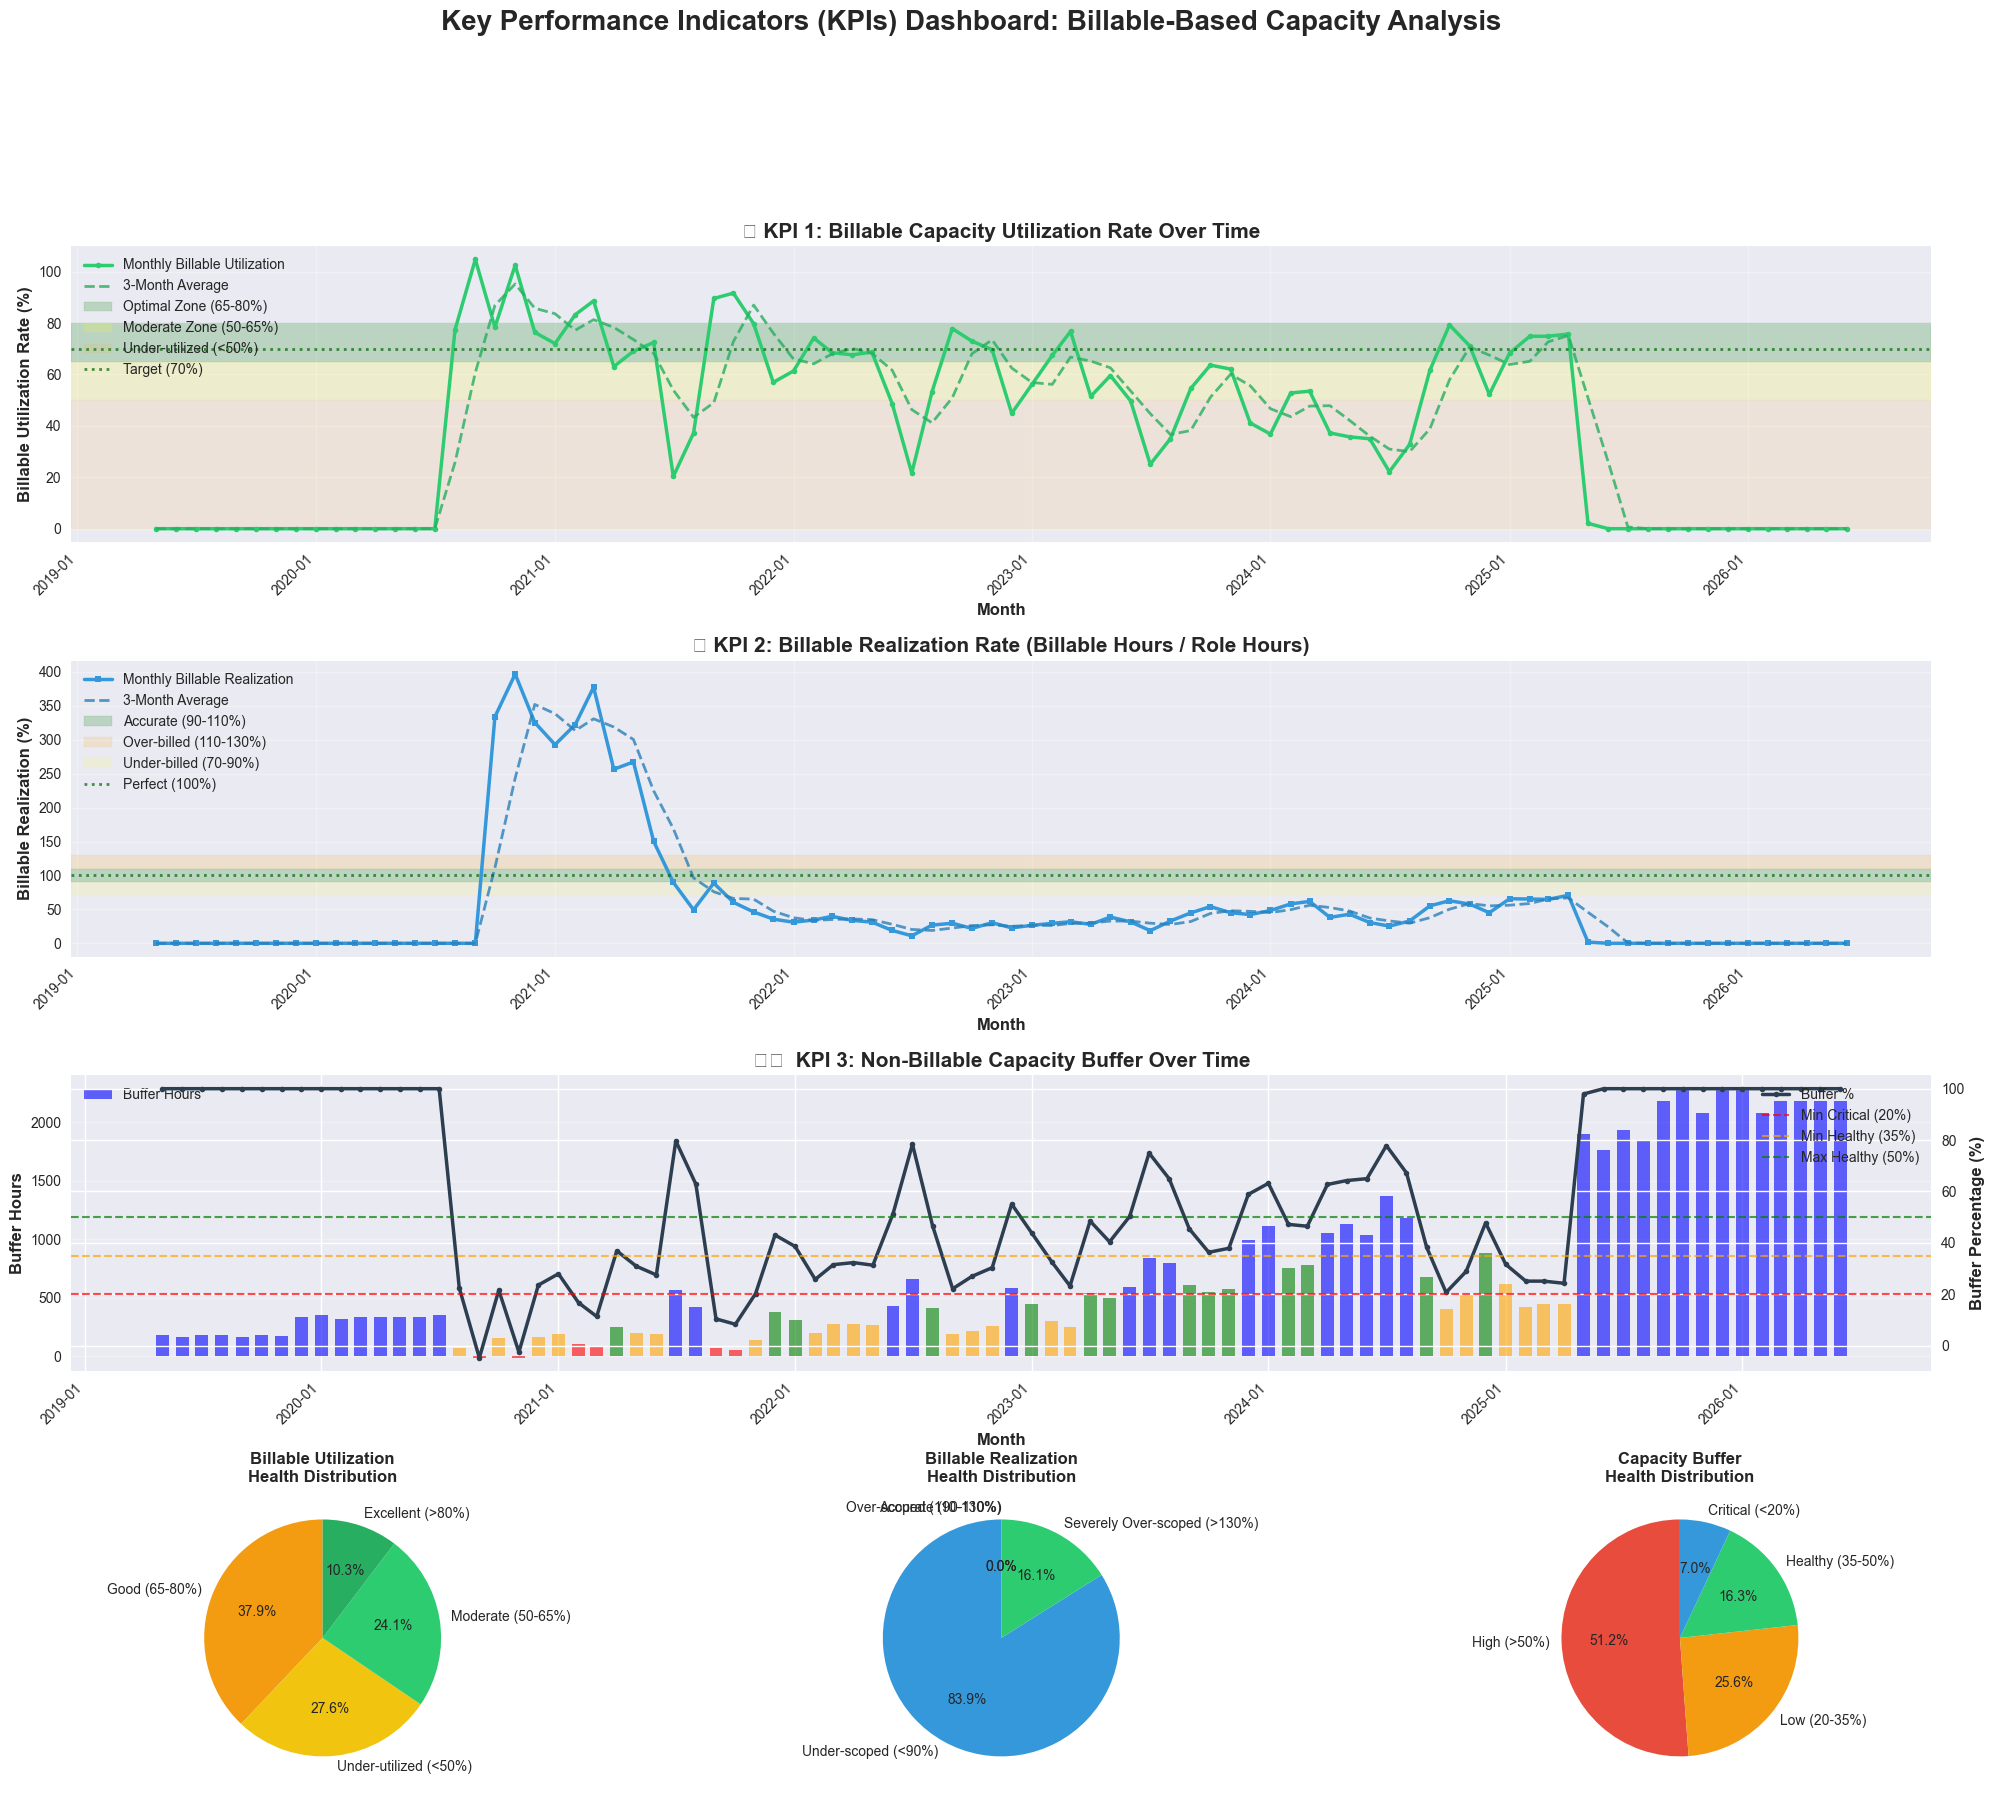


💡 ACTIONABLE INSIGHTS & RECOMMENDATIONS (BILLABLE-BASED)

🎯 BILLABLE CAPACITY UTILIZATION:
   📌 Action: CRITICAL - Less than 50% billable utilization
   💡 Recommendations:
      → Aggressive sales/marketing push
      → Review pricing model (are projects profitable?)
      → Reduce headcount or pivot to new markets

📐 BILLABLE REALIZATION:
   📌 Action: CRITICAL - Major billable gap vs planned roles
   💡 Only 38.9% of planned work is billed
      → Investigate: Is work non-billable, or not tracked?
      → Review: Client contracts, change orders, scope creep

🛡️  NON-BILLABLE CAPACITY:
   📊 Status: High buffer - opportunity or waste?
   💡 Either: Ramp up sales, or team is oversized

=== SAVING BILLABLE-BASED KPI ANALYSIS ===

✓ Saved KPI analysis to: ..\data\processed\linking_tables\analysis__kpi_metrics_billable_based__20251006.csv
  Rows: 86
  KPIs tracked: Billable Utilization, Billable Realization, Non-Billable Buffer

✅ BILLABLE-BASED KPI ANALYSIS COMPLETE

📋 DataFrame created: df

In [ ]:
print("="*80)
print("📊 KEY PERFORMANCE INDICATORS (KPIs) ANALYSIS - BILLABLE CAPACITY BASED")
print("="*80)
print("Analyzing critical business metrics using BILLABLE HOURS as capacity measure\n")

# --- STEP 1: CALCULATE KPIs PER MONTH ---
print("=== STEP 1: CALCULATING MONTHLY KPIs (BILLABLE-BASED) ===\n")

df_kpis = df_combined.copy()

# KPI 1: Capacity Utilization Rate (BILLABLE HOURS / POTENTIAL HOURS)
df_kpis['capacity_utilization_rate'] = np.where(
    df_kpis['potential_hours'] > 0,
    (df_kpis['billable_hours'] / df_kpis['potential_hours']) * 100,
    0
)

# KPI 2: Scoping Accuracy (Realization Rate) - BILLABLE HOURS / ROLE HOURS
df_kpis['scoping_accuracy_rate'] = np.where(
    df_kpis['defined_role_hours'] > 0,
    (df_kpis['billable_hours'] / df_kpis['defined_role_hours']) * 100,
    0
)

# KPI 3: Capacity Buffer (POTENTIAL - BILLABLE, not POTENTIAL - ROLES)
df_kpis['capacity_buffer_hours'] = df_kpis['potential_hours'] - df_kpis['billable_hours']

# Additional: Buffer as percentage of potential
df_kpis['capacity_buffer_pct'] = np.where(
    df_kpis['potential_hours'] > 0,
    (df_kpis['capacity_buffer_hours'] / df_kpis['potential_hours']) * 100,
    0
)

# NEW: Non-billable overhead percentage
df_kpis['non_billable_overhead_pct'] = np.where(
    df_kpis['potential_hours'] > 0,
    (df_kpis['non_billable_work_hours'] / df_kpis['potential_hours']) * 100,
    0
)

# Health indicators (adjusted thresholds for billable-based)
df_kpis['utilization_health'] = pd.cut(
    df_kpis['capacity_utilization_rate'],
    bins=[0, 50, 65, 80, float('inf')],
    labels=['Under-utilized (<50%)', 'Moderate (50-65%)', 'Good (65-80%)', 'Excellent (>80%)']
)

df_kpis['scoping_health'] = pd.cut(
    df_kpis['scoping_accuracy_rate'],
    bins=[0, 90, 110, 130, float('inf')],
    labels=['Under-scoped (<90%)', 'Accurate (90-110%)', 'Over-scoped (110-130%)', 'Severely Over-scoped (>130%)']
)

df_kpis['buffer_health'] = pd.cut(
    df_kpis['capacity_buffer_pct'],
    bins=[-float('inf'), 20, 35, 50, float('inf')],
    labels=['Critical (<20%)', 'Low (20-35%)', 'Healthy (35-50%)', 'High (>50%)']
)

print(f"✓ Calculated KPIs for {len(df_kpis)} months\n")

# --- STEP 2: OVERALL STATISTICS ---
print("=== STEP 2: OVERALL KPI STATISTICS (BILLABLE-BASED) ===\n")

# Total values
total_potential = df_kpis['potential_hours'].sum()
total_defined = df_kpis['defined_role_hours'].sum()
total_billable = df_kpis['billable_hours'].sum()
total_non_billable = df_kpis['non_billable_work_hours'].sum()
total_logged = total_billable + total_non_billable

print("📈 CUMULATIVE METRICS:")
print(f"   • Total Potential Hours: {total_potential:,.0f}h")
print(f"   • Total Defined Role Hours: {total_defined:,.0f}h")
print(f"   • Total Billable Hours: {total_billable:,.0f}h ⭐ (PRIMARY CAPACITY)")
print(f"   • Total Non-Billable Hours: {total_non_billable:,.0f}h")
print(f"   • Total Logged Hours: {total_logged:,.0f}h")
print()

# KPI 1: Capacity Utilization (BILLABLE)
overall_capacity_util = (total_billable / total_potential * 100) if total_potential > 0 else 0
avg_monthly_util = df_kpis['capacity_utilization_rate'].mean()
median_util = df_kpis['capacity_utilization_rate'].median()

print("🎯 KPI 1: BILLABLE CAPACITY UTILIZATION RATE")
print(f"   Formula: (Billable Hours / Potential Hours) × 100")
print(f"   • Overall Rate: {overall_capacity_util:.1f}%")
print(f"   • Monthly Average: {avg_monthly_util:.1f}%")
print(f"   • Median: {median_util:.1f}%")
print(f"   • Industry Target: 65-80% (consultancy best practice)")

if overall_capacity_util < 50:
    print(f"   ⚠️  ALERT: Under-utilized ({overall_capacity_util:.1f}%) - Significant capacity waste")
elif 50 <= overall_capacity_util < 65:
    print(f"   📊 MODERATE: {overall_capacity_util:.1f}% - Room for improvement")
elif 65 <= overall_capacity_util <= 80:
    print(f"   ✅ HEALTHY: {overall_capacity_util:.1f}% - Within optimal range")
else:
    print(f"   ⚡ EXCELLENT: {overall_capacity_util:.1f}% - High billable utilization")
print()

# Non-billable overhead
overall_overhead = (total_non_billable / total_potential * 100) if total_potential > 0 else 0
print(f"📋 NON-BILLABLE OVERHEAD:")
print(f"   • Total: {overall_overhead:.1f}% of potential capacity")
print(f"   • Typical range: 15-25%")
if overall_overhead > 30:
    print(f"   ⚠️  HIGH overhead - Review non-billable activities")
elif overall_overhead < 10:
    print(f"   ⚠️  LOW overhead - May indicate under-investment in growth/ops")
else:
    print(f"   ✅ HEALTHY overhead level")
print()

# KPI 2: Scoping Accuracy (BILLABLE vs ROLES)
overall_scoping = (total_billable / total_defined * 100) if total_defined > 0 else 0
avg_scoping = df_kpis['scoping_accuracy_rate'].mean()
median_scoping = df_kpis['scoping_accuracy_rate'].median()

print("📐 KPI 2: SCOPING ACCURACY (BILLABLE REALIZATION RATE)")
print(f"   Formula: (Billable Hours / Defined Role Hours) × 100")
print(f"   • Overall Rate: {overall_scoping:.1f}%")
print(f"   • Monthly Average: {avg_scoping:.1f}%")
print(f"   • Median: {median_scoping:.1f}%")
print(f"   • Target Range: 90-110% (±10% variance)")

if overall_scoping < 90:
    print(f"   📉 Under-delivery: Only {overall_scoping:.1f}% of planned roles are billed")
    print(f"      → {100 - overall_scoping:.1f}% gap suggests scope creep or non-billable work")
elif 90 <= overall_scoping <= 110:
    print(f"   ✅ ACCURATE: Billable work aligns with role estimates")
elif 110 < overall_scoping <= 130:
    print(f"   📈 Over-billing: {overall_scoping - 100:.1f}% more billable than planned")
    print(f"      → Could indicate role underestimation or scope expansion")
else:
    print(f"   🔴 CRITICAL: {overall_scoping - 100:.1f}% over planned billable hours")

scoping_variance = overall_scoping - 100
print(f"   • Planning Variance: {scoping_variance:+.1f}%")
print()

# KPI 3: Capacity Buffer (POTENTIAL - BILLABLE)
total_buffer = df_kpis['capacity_buffer_hours'].sum()
avg_buffer_hours = df_kpis['capacity_buffer_hours'].mean()
avg_buffer_pct = df_kpis['capacity_buffer_pct'].mean()

print("🛡️  KPI 3: CAPACITY BUFFER (NON-BILLABLE CAPACITY)")
print(f"   Formula: Potential Hours - Billable Hours")
print(f"   • Total Buffer: {total_buffer:,.0f}h")
print(f"   • Avg Monthly Buffer: {avg_buffer_hours:,.0f}h ({avg_buffer_pct:.1f}%)")
print(f"   • Target: 20-35% for sales, admin, training, R&D")

if avg_buffer_pct < 20:
    print(f"   🔴 CRITICAL: Only {avg_buffer_pct:.1f}% buffer - No room for growth activities")
elif avg_buffer_pct < 35:
    print(f"   ⚠️  LOW BUFFER: {avg_buffer_pct:.1f}% - Limited capacity for non-billable work")
elif 35 <= avg_buffer_pct <= 50:
    print(f"   ✅ HEALTHY: {avg_buffer_pct:.1f}% buffer - Good balance")
else:
    print(f"   📊 HIGH BUFFER: {avg_buffer_pct:.1f}% - Significant spare capacity")
print()

# Monthly distribution
print("📅 MONTHLY HEALTH DISTRIBUTION:")
print("\nBillable Capacity Utilization:")
print(df_kpis['utilization_health'].value_counts().sort_index())
print("\nScoping Accuracy:")
print(df_kpis['scoping_health'].value_counts().sort_index())
print("\nCapacity Buffer:")
print(df_kpis['buffer_health'].value_counts().sort_index())
print()

# --- STEP 3: TREND ANALYSIS ---
print("=== STEP 3: TREND ANALYSIS ===\n")

# Calculate rolling averages
df_kpis['capacity_util_3mo_avg'] = df_kpis['capacity_utilization_rate'].rolling(window=3, min_periods=1).mean()
df_kpis['scoping_accuracy_3mo_avg'] = df_kpis['scoping_accuracy_rate'].rolling(window=3, min_periods=1).mean()
df_kpis['buffer_pct_3mo_avg'] = df_kpis['capacity_buffer_pct'].rolling(window=3, min_periods=1).mean()

# Identify trends (last 6 months vs previous 6 months)
if len(df_kpis) >= 12:
    recent_util = df_kpis['capacity_utilization_rate'].tail(6).mean()
    previous_util = df_kpis['capacity_utilization_rate'].iloc[-12:-6].mean()
    util_trend = recent_util - previous_util
    
    recent_scoping = df_kpis['scoping_accuracy_rate'].tail(6).mean()
    previous_scoping = df_kpis['scoping_accuracy_rate'].iloc[-12:-6].mean()
    scoping_trend = recent_scoping - previous_scoping
    
    recent_buffer = df_kpis['capacity_buffer_pct'].tail(6).mean()
    previous_buffer = df_kpis['capacity_buffer_pct'].iloc[-12:-6].mean()
    buffer_trend = recent_buffer - previous_buffer
    
    print("📊 RECENT TRENDS (Last 6 months vs Previous 6 months):")
    print(f"   • Billable Utilization: {recent_util:.1f}% (trend: {util_trend:+.1f}%)")
    print(f"   • Scoping Accuracy: {recent_scoping:.1f}% (trend: {scoping_trend:+.1f}%)")
    print(f"   • Capacity Buffer: {recent_buffer:.1f}% (trend: {buffer_trend:+.1f}%)")
    print()

# --- STEP 4: VISUALIZATION DASHBOARD ---
print("=== STEP 4: CREATING KPI DASHBOARD (BILLABLE-BASED) ===\n")

fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35)

# 1. Billable Capacity Utilization Over Time
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_kpis['month'], df_kpis['capacity_utilization_rate'], 
         label='Monthly Billable Utilization', color='#2ECC71', linewidth=2.5, marker='o', markersize=4)
ax1.plot(df_kpis['month'], df_kpis['capacity_util_3mo_avg'], 
         label='3-Month Average', color='#27AE60', linewidth=2, linestyle='--', alpha=0.8)

# Target zones (adjusted for billable)
ax1.axhspan(65, 80, alpha=0.2, color='green', label='Optimal Zone (65-80%)')
ax1.axhspan(50, 65, alpha=0.15, color='yellow', label='Moderate Zone (50-65%)')
ax1.axhspan(0, 50, alpha=0.1, color='orange', label='Under-utilized (<50%)')
ax1.axhline(y=70, color='darkgreen', linestyle=':', linewidth=2, alpha=0.7, label='Target (70%)')

ax1.set_ylabel('Billable Utilization Rate (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_title('🎯 KPI 1: Billable Capacity Utilization Rate Over Time', fontsize=15, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. Scoping Accuracy Over Time (Billable vs Roles)
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(df_kpis['month'], df_kpis['scoping_accuracy_rate'], 
         label='Monthly Billable Realization', color='#3498DB', linewidth=2.5, marker='s', markersize=4)
ax2.plot(df_kpis['month'], df_kpis['scoping_accuracy_3mo_avg'], 
         label='3-Month Average', color='#2980B9', linewidth=2, linestyle='--', alpha=0.8)

# Target zones
ax2.axhspan(90, 110, alpha=0.2, color='green', label='Accurate (90-110%)')
ax2.axhspan(110, 130, alpha=0.15, color='orange', label='Over-billed (110-130%)')
ax2.axhspan(70, 90, alpha=0.1, color='yellow', label='Under-billed (70-90%)')
ax2.axhline(y=100, color='darkgreen', linestyle=':', linewidth=2, alpha=0.7, label='Perfect (100%)')

ax2.set_ylabel('Billable Realization (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
ax2.set_title('📐 KPI 2: Billable Realization Rate (Billable Hours / Role Hours)', fontsize=15, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Capacity Buffer Over Time
ax3 = fig.add_subplot(gs[2, :])
ax3_twin = ax3.twinx()

# Plot buffer hours (bars)
colors_buffer = ['red' if x < df_kpis['potential_hours'].iloc[i] * 0.20 
                 else 'orange' if df_kpis['potential_hours'].iloc[i] * 0.20 <= x < df_kpis['potential_hours'].iloc[i] * 0.35
                 else 'green' if df_kpis['potential_hours'].iloc[i] * 0.35 <= x < df_kpis['potential_hours'].iloc[i] * 0.50
                 else 'blue' for i, x in enumerate(df_kpis['capacity_buffer_hours'])]
ax3.bar(df_kpis['month'], df_kpis['capacity_buffer_hours'], 
        color=colors_buffer, alpha=0.6, width=20, label='Buffer Hours')

# Plot buffer percentage (line)
ax3_twin.plot(df_kpis['month'], df_kpis['capacity_buffer_pct'], 
              color='#2C3E50', linewidth=2.5, marker='o', markersize=4, label='Buffer %')
ax3_twin.axhline(y=20, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Min Critical (20%)')
ax3_twin.axhline(y=35, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Min Healthy (35%)')
ax3_twin.axhline(y=50, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Max Healthy (50%)')

ax3.set_ylabel('Buffer Hours', fontsize=12, fontweight='bold')
ax3_twin.set_ylabel('Buffer Percentage (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Month', fontsize=12, fontweight='bold')
ax3.set_title('🛡️  KPI 3: Non-Billable Capacity Buffer Over Time', fontsize=15, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3_twin.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# 4. Utilization Health Distribution
ax4 = fig.add_subplot(gs[3, 0])
util_counts = df_kpis['utilization_health'].value_counts()
ax4.pie(util_counts.values, labels=util_counts.index, autopct='%1.1f%%',
        colors=['#F39C12', '#F1C40F', '#2ECC71', '#27AE60'], startangle=90)
ax4.set_title('Billable Utilization\nHealth Distribution', fontsize=12, fontweight='bold')

# 5. Scoping Health Distribution
ax5 = fig.add_subplot(gs[3, 1])
scoping_counts = df_kpis['scoping_health'].value_counts()
ax5.pie(scoping_counts.values, labels=scoping_counts.index, autopct='%1.1f%%',
        colors=['#3498DB', '#2ECC71', '#E67E22', '#E74C3C'], startangle=90)
ax5.set_title('Billable Realization\nHealth Distribution', fontsize=12, fontweight='bold')

# 6. Buffer Health Distribution
ax6 = fig.add_subplot(gs[3, 2])
buffer_counts = df_kpis['buffer_health'].value_counts()
ax6.pie(buffer_counts.values, labels=buffer_counts.index, autopct='%1.1f%%',
        colors=['#E74C3C', '#F39C12', '#2ECC71', '#3498DB'], startangle=90)
ax6.set_title('Capacity Buffer\nHealth Distribution', fontsize=12, fontweight='bold')

plt.suptitle('Key Performance Indicators (KPIs) Dashboard: Billable-Based Capacity Analysis', 
             fontsize=20, fontweight='bold', y=0.998)
plt.show()

# --- STEP 5: ACTIONABLE INSIGHTS ---
print("\n" + "="*80)
print("💡 ACTIONABLE INSIGHTS & RECOMMENDATIONS (BILLABLE-BASED)")
print("="*80 + "\n")

print("🎯 BILLABLE CAPACITY UTILIZATION:")
if overall_capacity_util < 50:
    print("   📌 Action: CRITICAL - Less than 50% billable utilization")
    print("   💡 Recommendations:")
    print("      → Aggressive sales/marketing push")
    print("      → Review pricing model (are projects profitable?)")
    print("      → Reduce headcount or pivot to new markets")
elif overall_capacity_util < 65:
    print("   📌 Action: Moderate utilization - Room for growth")
    print("   💡 Recommendations:")
    print("      → Focus on client acquisition")
    print("      → Convert non-billable activities to billable where possible")
elif overall_capacity_util <= 80:
    print("   ✅ Status: Healthy billable utilization - Maintain momentum")
    print("   💡 Continue current strategies and monitor for overwork")
else:
    print("   ⚡ Status: Excellent billable utilization!")
    print("   💡 Consider: Hiring to support growth, premium pricing")
print()

print("📐 BILLABLE REALIZATION:")
if overall_scoping < 80:
    print("   📌 Action: CRITICAL - Major billable gap vs planned roles")
    print(f"   💡 Only {overall_scoping:.1f}% of planned work is billed")
    print("      → Investigate: Is work non-billable, or not tracked?")
    print("      → Review: Client contracts, change orders, scope creep")
elif overall_scoping < 90:
    print("   📌 Action: Monitor billable realization closely")
    print("   💡 Consider: Better time tracking, contract terms review")
elif 90 <= overall_scoping <= 110:
    print("   ✅ Status: Excellent alignment between plans and billable work")
else:
    print("   ⚠️  Status: Billing more than planned")
    print("   💡 This could be good (upsells) or bad (underestimating)")
    print("      → Review: Are estimates too conservative?")
print()

print("🛡️  NON-BILLABLE CAPACITY:")
if avg_buffer_pct < 20:
    print("   🚨 URGENT: Critical - Less than 20% buffer")
    print("   📌 Action: No capacity for sales, training, or admin")
    print("      → Hire immediately or reduce billable commitments")
elif avg_buffer_pct < 35:
    print("   ⚠️  WARNING: Low buffer - Limited growth capacity")
    print("   📌 Action: Plan hiring before taking new projects")
elif avg_buffer_pct <= 50:
    print("   ✅ Status: Healthy buffer for sustainable operations")
else:
    print("   📊 Status: High buffer - opportunity or waste?")
    print("   💡 Either: Ramp up sales, or team is oversized")
print()

# --- STEP 6: SAVE KPI DATA ---
print("=== SAVING BILLABLE-BASED KPI ANALYSIS ===\n")

kpi_path = output_dir / f"analysis__kpi_metrics_billable_based__{timestamp}.csv"
df_kpis.to_csv(kpi_path, index=False)
print(f"✓ Saved KPI analysis to: {kpi_path}")
print(f"  Rows: {len(df_kpis)}")
print(f"  KPIs tracked: Billable Utilization, Billable Realization, Non-Billable Buffer")

print("\n" + "="*80)
print("✅ BILLABLE-BASED KPI ANALYSIS COMPLETE")
print("="*80)
print("\n📋 DataFrame created: df_kpis (accessible for further analysis)")
print("\n📊 Key Metrics Summary:")
print(f"   • Billable Capacity Utilization: {overall_capacity_util:.1f}% (Target: 65-80%)")
print(f"   • Billable Realization Rate: {overall_scoping:.1f}% (Target: 90-110%)")
print(f"   • Non-Billable Buffer: {avg_buffer_pct:.1f}% (Target: 20-35%)")
print(f"   • Non-Billable Overhead: {overall_overhead:.1f}%")
print("="*80)

📈 WORKLOAD FORECASTING: Expected Future Demand
Using time series forecasting to predict future capacity needs

=== STEP 1: PREPARING TIME SERIES DATA ===

✓ Historical data points: 86
✓ Date range: 2019-05-01 to 2026-06-01
✓ Total historical role hours: 96,304h

Forecast horizon: 6 months

=== STEP 2: RUNNING MULTIPLE FORECASTING MODELS ===

[1] Simple Moving Average (3-month baseline)...
    ✓ Forecast: 224h/month (constant)
[2] Exponential Weighted Moving Average...
    ✓ Forecast: 399h/month (constant)
[3] Linear Trend Projection...
    ✓ Trend: 20.5h/month slope (R²=0.338)
    ✓ Last forecast: 2,112h
[4] ARIMA Model...
    ✓ ARIMA(1,1,1) forecast: 169h (final month)
[5] Exponential Smoothing (Holt-Winters)...
    ✓ Holt-Winters forecast: -576h (final month)

=== STEP 3: CONSOLIDATING FORECAST RESULTS ===

✓ Created forecast for 6 future months
✓ Forecast range: 2026-07-01 to 2026-12-01



month  forecast_moving_avg_3mo  forecast_ema_6mo  \
0 2026-07-01               224.051037        398.965141   
1 2026-08-01               224.051037        398.965141   
2 2026-09-01               224.051037        398.965141   
3 2026-10-01               224.051037        398.965141   
4 2026-11-01               224.051037        398.965141   
5 2026-12-01               224.051037        398.965141   

   forecast_linear_trend  forecast_arima  forecast_holt_winters  \
0            2009.731327      124.318089            -235.506431   
1            2030.189198      169.450592            -271.645326   
2            2050.647068      124.322043            -268.064198   
3            2071.104939      169.446638            -183.235573   
4            2091.562810      124.325996            -409.930689   
5            2112.020680      169.442686            -575.696889   

   forecast_ensemble  forecast_lower_bound  forecast_upper_bound  
0         504.311833            403.449466            605.174199  
1         510.202128            408.161703            612.242554  
2         505.984218            404.787375            607.181062  
3         536.066436            428.853149            643.279724  
4         485.794859            388.635887            582.953831  
5         465.756531            372.605225            558.907837


=== FORECAST SUMMARY ===

📊 FORECASTED WORKLOAD (Next 6 months):
   • Ensemble Average: 501h/month
   • Total Expected: 3,008h (6 months)
   • Historical Average: 1,120h/month
   • Expected Change: -55.2%

📈 MODEL COMPARISON (Final Month Forecast):
   • Moving_Avg_3mo: 224h
   • EMA_6mo: 399h
   • Linear_Trend: 2,112h
   • ARIMA: 169h
   • Holt_Winters: -576h
   • 📍 Ensemble (Recommended): 466h

🎯 CONFIDENCE RANGE (Final Month):
   • Lower Bound (80%): 373h
   • Best Estimate: 466h
   • Upper Bound (120%): 559h

=== STAFFING RECOMMENDATIONS ===

💼 CAPACITY PLANNING:
   • Current Headcount: 13 people
   • Forecasted Need: 4.1 people (at 70% billable)
   • Headcount Gap: -8.9 people

   ⚠️  ALERT: Potential over-staffing by 8.9 people
   💡 Consider: Increased sales efforts or role optimization

=== STEP 4: CREATING FORECAST VISUALIZATION ===



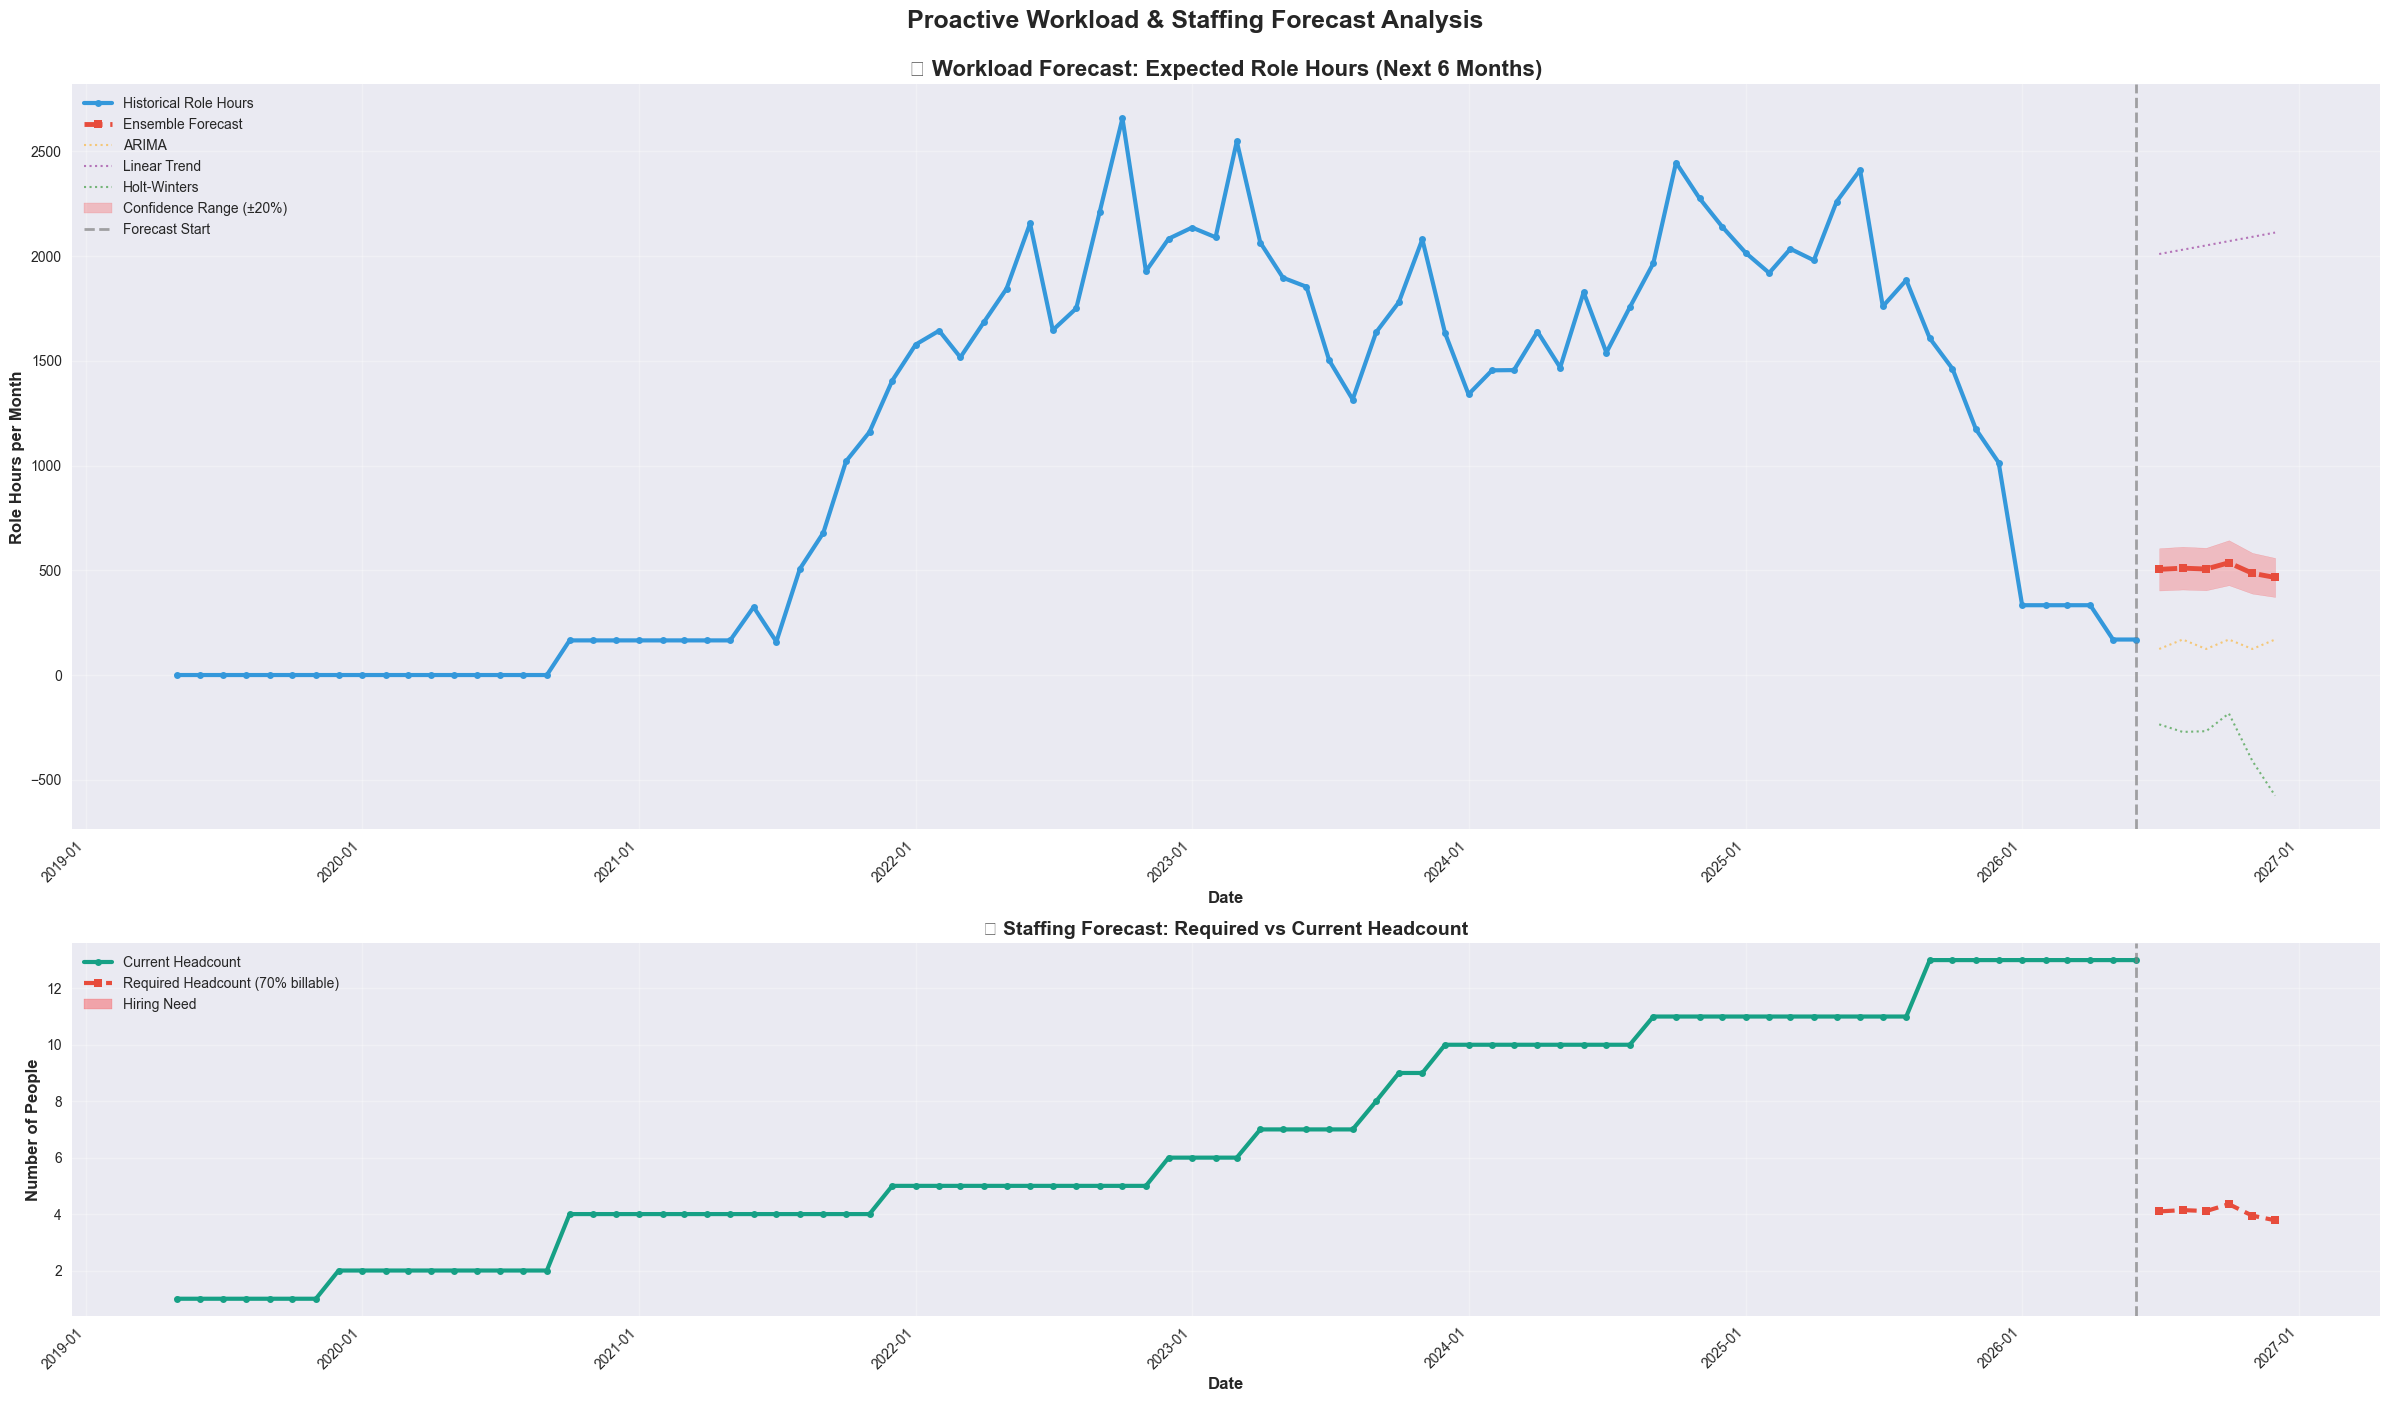


=== SAVING FORECAST RESULTS ===

✓ Saved forecast to: ..\data\processed\linking_tables\forecast__workload_6month__20251006.csv
  Forecast periods: 6
  Models used: 5 (Moving Avg, EMA, Linear, ARIMA, Holt-Winters)

✅ WORKLOAD FORECASTING COMPLETE

📋 Key Outputs:
   • Expected workload (next 6 months): 3,008h
   • Recommended headcount: 4.1 people
   • Hiring need: 0 people

📊 DataFrame created: df_forecast_output
   Use this for capacity planning and hiring decisions


In [ ]:
print("="*80)
print("📈 WORKLOAD FORECASTING: Expected Future Demand")
print("="*80)
print("Using time series forecasting to predict future capacity needs\n")

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# --- STEP 1: PREPARE TIME SERIES DATA ---
print("=== STEP 1: PREPARING TIME SERIES DATA ===\n")

# Use df_combined which has monthly aggregated data
df_forecast = df_combined[['month', 'defined_role_hours', 'recorded_logged_hours', 'billable_hours']].copy()
df_forecast = df_forecast.sort_values('month').reset_index(drop=True)

# Set month as index for time series
df_forecast.set_index('month', inplace=True)

print(f"✓ Historical data points: {len(df_forecast)}")
print(f"✓ Date range: {df_forecast.index.min().date()} to {df_forecast.index.max().date()}")
print(f"✓ Total historical role hours: {df_forecast['defined_role_hours'].sum():,.0f}h\n")

# --- STEP 2: FORECAST PARAMETERS ---
FORECAST_PERIODS = 6  # Forecast next 6 months
print(f"Forecast horizon: {FORECAST_PERIODS} months\n")

# --- STEP 3: MULTIPLE FORECASTING MODELS ---
print("=== STEP 2: RUNNING MULTIPLE FORECASTING MODELS ===\n")

forecast_results = {}

# MODEL 1: Simple Moving Average (3-month)
print("[1] Simple Moving Average (3-month baseline)...")
ma_3 = df_forecast['defined_role_hours'].rolling(window=3).mean().iloc[-1]
forecast_results['Moving_Avg_3mo'] = [ma_3] * FORECAST_PERIODS
print(f"    ✓ Forecast: {ma_3:,.0f}h/month (constant)")

# MODEL 2: Exponential Moving Average
print("[2] Exponential Weighted Moving Average...")
ema_span = 6
ema_value = df_forecast['defined_role_hours'].ewm(span=ema_span).mean().iloc[-1]
forecast_results['EMA_6mo'] = [ema_value] * FORECAST_PERIODS
print(f"    ✓ Forecast: {ema_value:,.0f}h/month (constant)")

# MODEL 3: Linear Trend
print("[3] Linear Trend Projection...")
from scipy import stats
x = np.arange(len(df_forecast))
y = df_forecast['defined_role_hours'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

future_x = np.arange(len(df_forecast), len(df_forecast) + FORECAST_PERIODS)
linear_forecast = slope * future_x + intercept
forecast_results['Linear_Trend'] = linear_forecast.tolist()
print(f"    ✓ Trend: {slope:,.1f}h/month slope (R²={r_value**2:.3f})")
print(f"    ✓ Last forecast: {linear_forecast[-1]:,.0f}h")

# MODEL 4: ARIMA (Auto-regressive Integrated Moving Average)
print("[4] ARIMA Model...")
try:
    # Use simple (1,1,1) parameters - can be optimized with auto_arima
    arima_model = ARIMA(df_forecast['defined_role_hours'], order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=FORECAST_PERIODS)
    forecast_results['ARIMA'] = arima_forecast.tolist()
    print(f"    ✓ ARIMA(1,1,1) forecast: {arima_forecast.iloc[-1]:,.0f}h (final month)")
except Exception as e:
    print(f"    ✗ ARIMA failed: {str(e)}")
    forecast_results['ARIMA'] = [ma_3] * FORECAST_PERIODS  # Fallback

# MODEL 5: Exponential Smoothing (Holt-Winters)
print("[5] Exponential Smoothing (Holt-Winters)...")
try:
    # Use additive model (no seasonality if data is short)
    seasonal_periods = min(12, len(df_forecast) // 2) if len(df_forecast) >= 24 else None
    
    if seasonal_periods:
        hw_model = ExponentialSmoothing(
            df_forecast['defined_role_hours'], 
            seasonal_periods=seasonal_periods,
            trend='add',
            seasonal='add'
        )
    else:
        hw_model = ExponentialSmoothing(
            df_forecast['defined_role_hours'], 
            trend='add'
        )
    
    hw_fit = hw_model.fit()
    hw_forecast = hw_fit.forecast(steps=FORECAST_PERIODS)
    forecast_results['Holt_Winters'] = hw_forecast.tolist()
    print(f"    ✓ Holt-Winters forecast: {hw_forecast.iloc[-1]:,.0f}h (final month)")
except Exception as e:
    print(f"    ✗ Holt-Winters failed: {str(e)}")
    forecast_results['Holt_Winters'] = [ema_value] * FORECAST_PERIODS  # Fallback

print()

# --- STEP 4: CREATE FORECAST DATAFRAME ---
print("=== STEP 3: CONSOLIDATING FORECAST RESULTS ===\n")

# Generate future dates
last_date = df_forecast.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=FORECAST_PERIODS, freq='MS')

# Create forecast dataframe
df_forecast_output = pd.DataFrame({
    'month': future_dates,
    'forecast_moving_avg_3mo': forecast_results['Moving_Avg_3mo'],
    'forecast_ema_6mo': forecast_results['EMA_6mo'],
    'forecast_linear_trend': forecast_results['Linear_Trend'],
    'forecast_arima': forecast_results['ARIMA'],
    'forecast_holt_winters': forecast_results['Holt_Winters']
})

# Calculate ensemble forecast (average of all models)
df_forecast_output['forecast_ensemble'] = df_forecast_output[[
    'forecast_moving_avg_3mo', 'forecast_ema_6mo', 'forecast_linear_trend', 
    'forecast_arima', 'forecast_holt_winters'
]].mean(axis=1)

# Calculate confidence intervals (±20% around ensemble)
df_forecast_output['forecast_lower_bound'] = df_forecast_output['forecast_ensemble'] * 0.8
df_forecast_output['forecast_upper_bound'] = df_forecast_output['forecast_ensemble'] * 1.2

print(f"✓ Created forecast for {len(df_forecast_output)} future months")
print(f"✓ Forecast range: {future_dates[0].date()} to {future_dates[-1].date()}\n")

display(df_forecast_output)

# --- STEP 5: SUMMARY STATISTICS ---
print("\n=== FORECAST SUMMARY ===\n")

ensemble_avg = df_forecast_output['forecast_ensemble'].mean()
ensemble_total = df_forecast_output['forecast_ensemble'].sum()
historical_avg = df_forecast['defined_role_hours'].mean()

print(f"📊 FORECASTED WORKLOAD (Next {FORECAST_PERIODS} months):")
print(f"   • Ensemble Average: {ensemble_avg:,.0f}h/month")
print(f"   • Total Expected: {ensemble_total:,.0f}h ({FORECAST_PERIODS} months)")
print(f"   • Historical Average: {historical_avg:,.0f}h/month")
print(f"   • Expected Change: {(ensemble_avg - historical_avg) / historical_avg * 100:+.1f}%")
print()

print(f"📈 MODEL COMPARISON (Final Month Forecast):")
for model_name, values in forecast_results.items():
    print(f"   • {model_name}: {values[-1]:,.0f}h")
print(f"   • 📍 Ensemble (Recommended): {df_forecast_output['forecast_ensemble'].iloc[-1]:,.0f}h")
print()

print(f"🎯 CONFIDENCE RANGE (Final Month):")
final_lower = df_forecast_output['forecast_lower_bound'].iloc[-1]
final_upper = df_forecast_output['forecast_upper_bound'].iloc[-1]
final_ensemble = df_forecast_output['forecast_ensemble'].iloc[-1]
print(f"   • Lower Bound (80%): {final_lower:,.0f}h")
print(f"   • Best Estimate: {final_ensemble:,.0f}h")
print(f"   • Upper Bound (120%): {final_upper:,.0f}h")
print()

# --- STEP 6: STAFFING RECOMMENDATIONS ---
print("=== STAFFING RECOMMENDATIONS ===\n")

# Calculate required headcount based on forecast
MONTHLY_CAPACITY_PER_PERSON = DAILY_WORK_CAPACITY_HOURS * 22  # ~22 working days/month
BILLABLE_TARGET = 0.70  # 70% target billable utilization

required_capacity_avg = ensemble_avg
required_headcount_avg = required_capacity_avg / (MONTHLY_CAPACITY_PER_PERSON * BILLABLE_TARGET)

current_headcount = df_combined['active_employees'].iloc[-1]
headcount_gap = required_headcount_avg - current_headcount

print(f"💼 CAPACITY PLANNING:")
print(f"   • Current Headcount: {current_headcount:.0f} people")
print(f"   • Forecasted Need: {required_headcount_avg:.1f} people (at 70% billable)")
print(f"   • Headcount Gap: {headcount_gap:+.1f} people")
print()

if headcount_gap > 0:
    print(f"   📌 ACTION: HIRE {np.ceil(headcount_gap):.0f} people to meet demand")
    print(f"   💡 Timeline: Start recruiting now for {FORECAST_PERIODS}-month horizon")
elif headcount_gap < -2:
    print(f"   ⚠️  ALERT: Potential over-staffing by {abs(headcount_gap):.1f} people")
    print(f"   💡 Consider: Increased sales efforts or role optimization")
else:
    print(f"   ✅ STATUS: Current headcount adequate for forecasted demand")
print()

# --- STEP 7: VISUALIZATION ---
print("=== STEP 4: CREATING FORECAST VISUALIZATION ===\n")

fig, axes = plt.subplots(2, 1, figsize=(24, 14), gridspec_kw={'height_ratios': [2, 1]})

# TOP CHART: Historical + Forecast
ax1 = axes[0]

# Historical data
ax1.plot(df_forecast.index, df_forecast['defined_role_hours'], 
         label='Historical Role Hours', color='#3498DB', linewidth=3, marker='o', markersize=5)

# Forecast lines
ax1.plot(df_forecast_output['month'], df_forecast_output['forecast_ensemble'], 
         label='Ensemble Forecast', color='#E74C3C', linewidth=3.5, marker='s', markersize=6, linestyle='--')

# Individual model forecasts (lighter)
ax1.plot(df_forecast_output['month'], df_forecast_output['forecast_arima'], 
         label='ARIMA', color='orange', linewidth=1.5, alpha=0.5, linestyle=':')
ax1.plot(df_forecast_output['month'], df_forecast_output['forecast_linear_trend'], 
         label='Linear Trend', color='purple', linewidth=1.5, alpha=0.5, linestyle=':')
ax1.plot(df_forecast_output['month'], df_forecast_output['forecast_holt_winters'], 
         label='Holt-Winters', color='green', linewidth=1.5, alpha=0.5, linestyle=':')

# Confidence interval
ax1.fill_between(df_forecast_output['month'], 
                  df_forecast_output['forecast_lower_bound'],
                  df_forecast_output['forecast_upper_bound'],
                  alpha=0.2, color='red', label='Confidence Range (±20%)')

# Vertical line at forecast start
ax1.axvline(x=last_date, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Forecast Start')

# Formatting
ax1.set_ylabel('Role Hours per Month', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_title('🔮 Workload Forecast: Expected Role Hours (Next 6 Months)', fontsize=16, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# BOTTOM CHART: Required vs Current Headcount
ax2 = axes[1]

# Historical headcount
df_historical_headcount = df_combined[['month', 'active_employees']].set_index('month')
ax2.plot(df_historical_headcount.index, df_historical_headcount['active_employees'], 
         label='Current Headcount', color='#16A085', linewidth=3, marker='o', markersize=5)


#  Required headcount forecast
required_headcount_forecast = df_forecast_output['forecast_ensemble'] / (MONTHLY_CAPACITY_PER_PERSON * BILLABLE_TARGET)
ax2.plot(df_forecast_output['month'], required_headcount_forecast, 
         label='Required Headcount (70% billable)', color='#E74C3C', linewidth=3, marker='s', markersize=6, linestyle='--')

# Gap area
ax2.fill_between(df_forecast_output['month'], 
                  current_headcount,
                  required_headcount_forecast,
                  where=(required_headcount_forecast > current_headcount),
                  alpha=0.3, color='red', label='Hiring Need', interpolate=True)

# Vertical line
ax2.axvline(x=last_date, color='gray', linestyle='--', linewidth=2, alpha=0.7)

# Formatting
ax2.set_ylabel('Number of People', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_title('👥 Staffing Forecast: Required vs Current Headcount', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Proactive Workload & Staffing Forecast Analysis', fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

# --- STEP 8: SAVE FORECAST DATA ---
print("\n=== SAVING FORECAST RESULTS ===\n")

forecast_path = output_dir / f"forecast__workload_6month__{timestamp}.csv"
df_forecast_output.to_csv(forecast_path, index=False)
print(f"✓ Saved forecast to: {forecast_path}")
print(f"  Forecast periods: {len(df_forecast_output)}")
print(f"  Models used: 5 (Moving Avg, EMA, Linear, ARIMA, Holt-Winters)")

print("\n" + "="*80)
print("✅ WORKLOAD FORECASTING COMPLETE")
print("="*80)
print("\n📋 Key Outputs:")
print(f"   • Expected workload (next {FORECAST_PERIODS} months): {ensemble_total:,.0f}h")
print(f"   • Recommended headcount: {required_headcount_avg:.1f} people")
print(f"   • Hiring need: {max(0, np.ceil(headcount_gap)):.0f} people")
print()
print("📊 DataFrame created: df_forecast_output")
print("   Use this for capacity planning and hiring decisions")
print("="*80)

In [ ]:
df_roles

role_id                 industry_name  \
0    68fb318f-438b-4257-95f2-3893564ebd01                           NaN   
1    b5a1a16b-99d7-4895-b927-0d0afa074c35                           NaN   
2    264b42da-30b3-8026-b4e1-f6a7c2832cc2                           NaN   
3    0517e8f8-b88c-41fa-ae1a-57458f4571d0                           NaN   
4    347c5d6b-8487-437c-8945-612a32c0b866                           NaN   
..                                    ...                           ...   
96   c90ee650-07ac-4725-a75d-f0b4d5f6b5e6                          Tech   
97   a53e017d-e456-49bd-89b6-fdbeec1b30b4                          Tech   
98   60b9abb5-6ff3-4bcd-be3c-ec6f396305c3                          Tech   
99   38968285-7e0f-4c8b-b473-9cbacd5f0ab4                          Tech   
100  a80d6f1c-0863-48a9-a49c-fc8c7a24896b  Transportation and Logistics   

     role_category_name  hourly_rate                   billing_type seniority  \
0                   NaN          NaN                            NaN        K2   
1                   NaN          NaN                            NaN       NaN   
2          Data Analyst        900.0                         Direct       NaN   
3         Data Engineer       1100.0  Invoicing(Right people Group)       NaN   
4                   NaN       1100.0                            NaN       NaN   
..                  ...          ...                            ...       ...   
96       Data Scientist       1000.0          Self-billing(Tingent)       NaN   
97   Business Developer       1350.0                            NaN        K4   
98   Business Developer       1000.0                 Direct billing       NaN   
99                  NaN       1700.0                 Direct billing        K4   
100       Data Engineer       1200.0                      Self bill       NaN   

      startdate                    name_anon  
0    2023-10-01                          NaN  
1           NaN                          NaN  
2    2025-09-04               Terry and Sons  
3    2022-12-05                 Payne-Nelson  
4    2022-09-11                 Payne-Nelson  
..          ...                          ...  
96   2022-09-01  Richards, Acosta and Mccall  
97   2021-06-21  Richards, Acosta and Mccall  
98   2023-02-07               Price and Sons  
99   2023-02-07               Price and Sons  
100  2023-07-04    Morris, Juarez and Chavez  

[101 rows x 8 columns]

TEMPORAL CAPACITY VS DEMAND ANALYSIS
This script compares role hour demands, recorded work, and the total available
capacity from HR headcount on a monthly basis.

[1] Generating timeline comparison plot from 'df_combined' DataFrame...


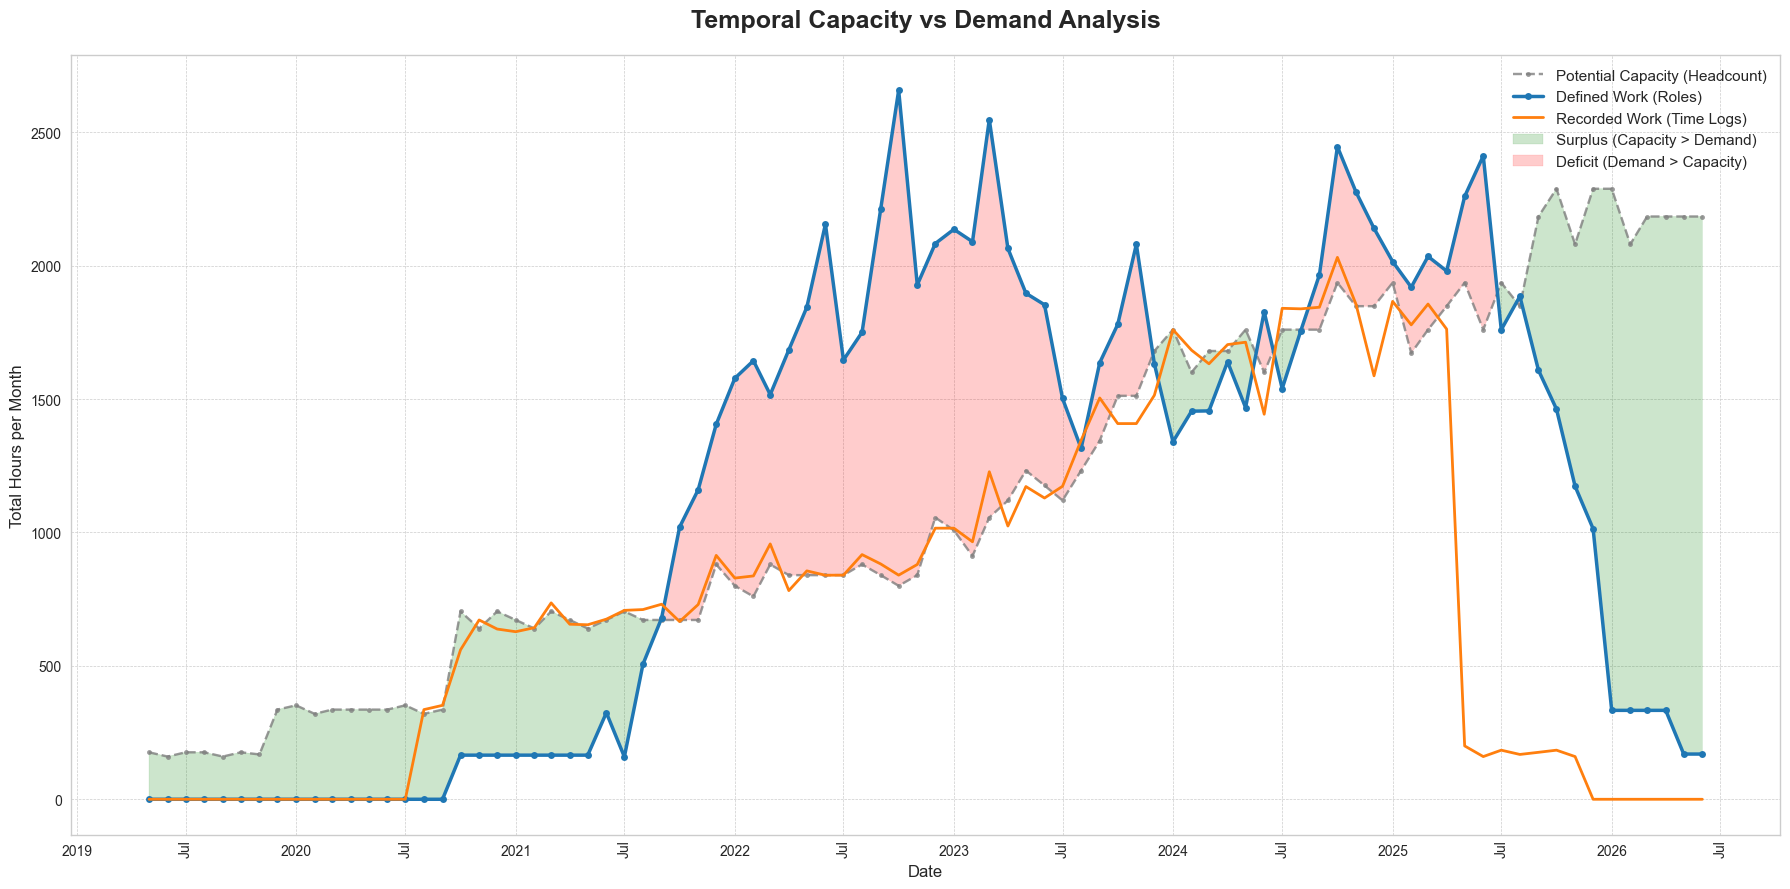


✓ Analysis complete. The plot correctly uses the 'df_combined' DataFrame.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# NOTE: This script has been updated to use the pre-calculated monthly 
# summary DataFrame 'df_combined' from the previous cell. This ensures
# consistency with all prior data processing and enrichment steps.

print("="*80)
print("TEMPORAL CAPACITY VS DEMAND ANALYSIS")
print("="*80)
print("This script compares role hour demands, recorded work, and the total available\n"
      "capacity from HR headcount on a monthly basis.\n")

# --- All necessary data is already aggregated in 'df_combined' ---
# We will use it directly for visualization.

# --- Analyze and Visualize ---
print("[1] Generating timeline comparison plot from 'df_combined' DataFrame...")

# Ensure the DataFrame is sorted by month
df_comparison = df_combined.sort_values('month').copy()

# Rename columns for clarity in the plot, if they are not already named this way
# These names match the output of your 'WORKLOAD VS. CAPACITY' cell.
df_comparison = df_comparison.rename(columns={
    'potential_hours': 'total_people_hours_available',
    'defined_role_hours': 'total_role_hours_demand',
    'recorded_logged_hours': 'recorded_logged_hours'
})


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 9))

# Plotting the data from the pre-calculated df_comparison
ax.plot(df_comparison['month'], df_comparison['total_people_hours_available'], label='Potential Capacity (Headcount)', color='gray', linestyle='--', marker='.', alpha=0.8)
ax.plot(df_comparison['month'], df_comparison['total_role_hours_demand'], label='Defined Work (Roles)', color='#1f77b4', linewidth=2.5, marker='o', markersize=5)
ax.plot(df_comparison['month'], df_comparison['recorded_logged_hours'], label='Recorded Work (Time Logs)', color='#ff7f0e', linewidth=2, marker='x', markersize=5)

# Fill the area between demand and capacity to highlight surplus/deficit
ax.fill_between(df_comparison['month'], df_comparison['total_role_hours_demand'], df_comparison['total_people_hours_available'],
                where=(df_comparison['total_people_hours_available'] >= df_comparison['total_role_hours_demand']),
                color='green', alpha=0.2, interpolate=True, label='Surplus (Capacity > Demand)')
ax.fill_between(df_comparison['month'], df_comparison['total_role_hours_demand'], df_comparison['total_people_hours_available'],
                where=(df_comparison['total_people_hours_available'] < df_comparison['total_role_hours_demand']),
                color='red', alpha=0.2, interpolate=True, label='Deficit (Demand > Capacity)')


# Formatting the plot
ax.set_title('Temporal Capacity vs Demand Analysis', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Total Hours per Month', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7])) # Ticks for Jan and Jul
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
plt.setp(ax.get_xticklabels(which='major'), rotation=0, ha='center')
plt.setp(ax.get_xticklabels(which='minor'), rotation=90, ha='center')

fig.tight_layout()
plt.show()

print("\n✓ Analysis complete. The plot correctly uses the 'df_combined' DataFrame.")

UTILIZATION ANALYSIS BY SENIORITY
This analysis compares billable hours against two different totals, aggregated by seniority:
1. Total hours from assigned roles (Planned Work Utilization)
2. Total hours from logged time entries (Recorded Work Utilization)

[1] Preparing data for utilization analysis...
✓ Data preparation and aggregation by seniority complete.

[2] Calculating utilization metrics by seniority...
Utilization calculations by seniority:


seniority  total_hours_logged  total_billable_hours_logged  \
0        K1             3360.00                  2320.000000   
1        K2            21710.60                  9951.516667   
2        K3            31447.05                 19419.800000   
3        K4             9278.00                  5787.000000   

   total_role_hours_assigned  role_based_utilization  logged_based_utilization  
0                       6424               36.114570                 69.047619  
1                      51648               19.267961                 45.837133  
2                      25184               77.111658                 61.753964  
3                      13048               44.351625                 62.373356


[3] Generating comparison charts by seniority...


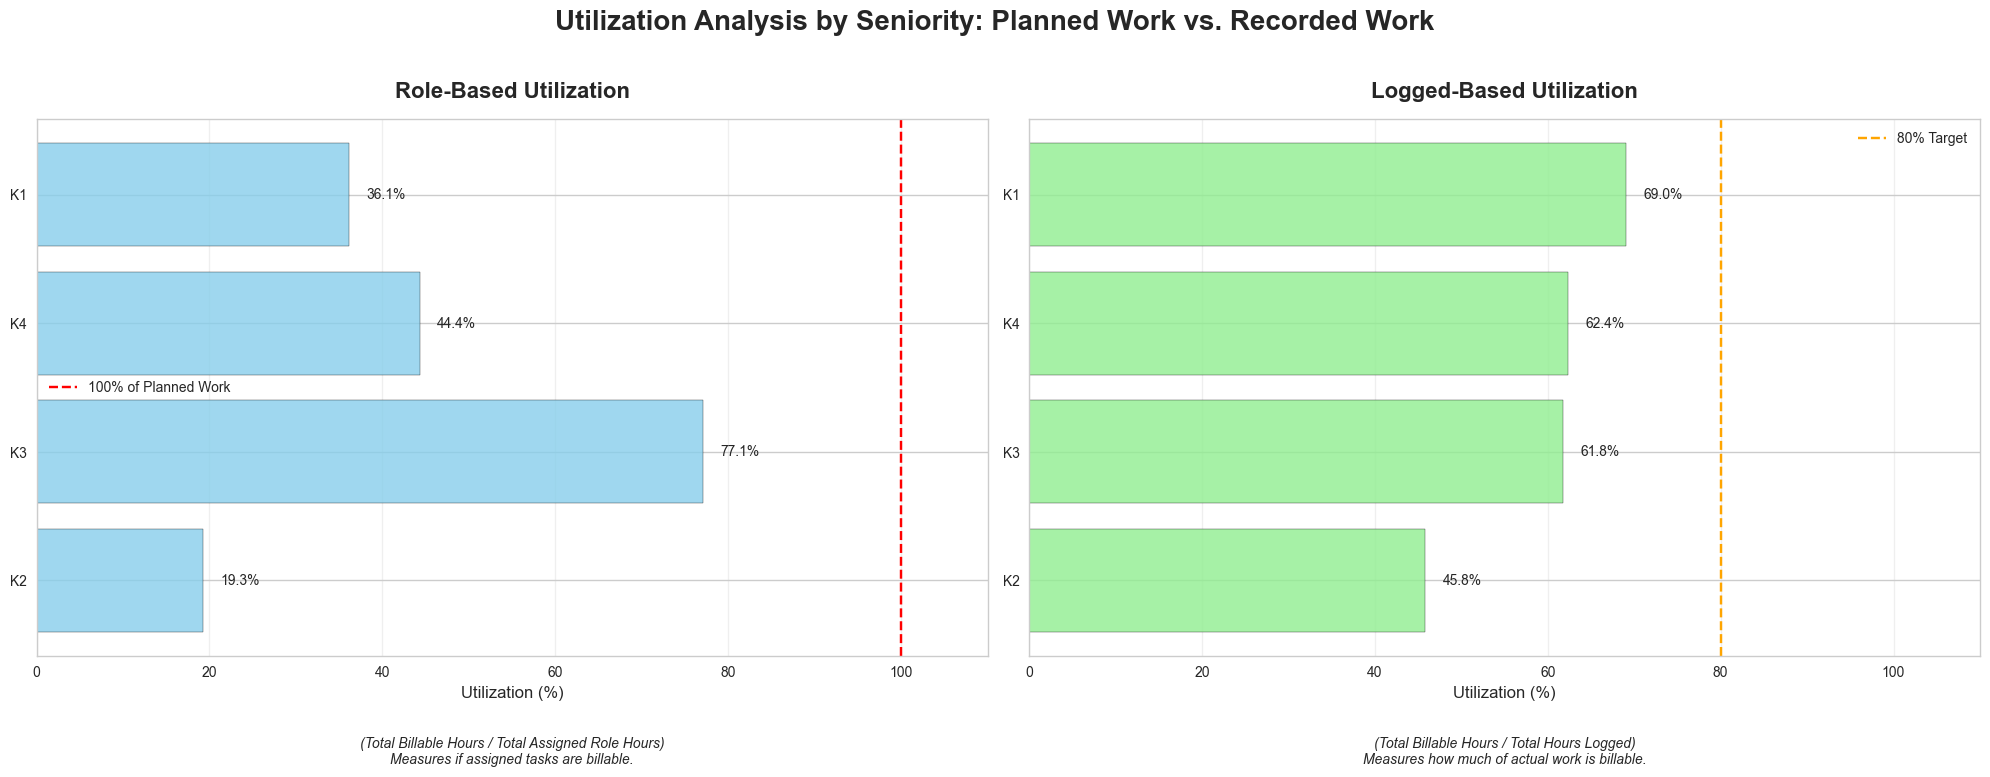

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This script assumes you have already run the previous stages and have the following DataFrames available:
# df_role_assignments, df_roles_enriched, df_time_entries_enriched, and df_master_identity_map (now with 'seniority')

print("="*80)
print("UTILIZATION ANALYSIS BY SENIORITY")
print("="*80)
print("This analysis compares billable hours against two different totals, aggregated by seniority:\n"
      "1. Total hours from assigned roles (Planned Work Utilization)\n"
      "2. Total hours from logged time entries (Recorded Work Utilization)\n")

# --- 1. Data Preparation ---
print("[1] Preparing data for utilization analysis...")

# Get seniority for each person from the master map
person_seniority = df_master_identity_map[['master_person_id', 'seniority']].copy()

# Calculate total billable hours per person from the ground truth time entries
billable_hours_per_person = df_time_entries_enriched[
    df_time_entries_enriched['billable'] == True
].groupby('master_person_id')['hours'].sum().reset_index()
billable_hours_per_person.rename(columns={'hours': 'total_billable_hours_logged'}, inplace=True)

# Calculate total logged hours per person
total_hours_per_person = df_time_entries_enriched.groupby('master_person_id')['hours'].sum().reset_index()
total_hours_per_person.rename(columns={'hours': 'total_hours_logged'}, inplace=True)

# Calculate total assigned role hours per person
df_assignments_with_hours = pd.merge(
    df_role_assignments,
    df_roles_enriched[['role_id', 'required_hours']],
    on='role_id',
    how='left'
)
role_hours_per_person = df_assignments_with_hours.groupby('assigned_to_person')['required_hours_x'].sum().reset_index()
role_hours_per_person.rename(columns={'required_hours_x': 'total_role_hours_assigned', 'assigned_to_person': 'master_person_id'}, inplace=True)

# --- Create a unified analysis DataFrame ---
df_utilization_person = pd.merge(total_hours_per_person, billable_hours_per_person, on='master_person_id', how='left')
df_utilization_person = pd.merge(df_utilization_person, role_hours_per_person, on='master_person_id', how='left')
df_utilization_person = pd.merge(df_utilization_person, person_seniority, on='master_person_id', how='left') # Add seniority
df_utilization_person.fillna(0, inplace=True)

# --- Aggregate by Seniority ---
df_utilization_seniority = df_utilization_person.groupby('seniority').agg({
    'total_hours_logged': 'sum',
    'total_billable_hours_logged': 'sum',
    'total_role_hours_assigned': 'sum'
}).reset_index()

print("✓ Data preparation and aggregation by seniority complete.\n")


# --- 2. Calculate Utilization Metrics by Seniority ---
print("[2] Calculating utilization metrics by seniority...")

# Metric 1: Role-Based Utilization
df_utilization_seniority['role_based_utilization'] = np.where(
    df_utilization_seniority['total_role_hours_assigned'] > 0,
    (df_utilization_seniority['total_billable_hours_logged'] / df_utilization_seniority['total_role_hours_assigned']) * 100,
    0
)

# Metric 2: Logged-Based Utilization
df_utilization_seniority['logged_based_utilization'] = np.where(
    df_utilization_seniority['total_hours_logged'] > 0,
    (df_utilization_seniority['total_billable_hours_logged'] / df_utilization_seniority['total_hours_logged']) * 100,
    0
)

print("Utilization calculations by seniority:")
display(df_utilization_seniority)


# --- 3. Visualization ---
print("\n[3] Generating comparison charts by seniority...")

# Sort data for clearer visualization
df_utilization_sorted = df_utilization_seniority.sort_values('logged_based_utilization', ascending=True)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Utilization Analysis by Seniority: Planned Work vs. Recorded Work', fontsize=20, fontweight='bold')

# --- Chart 1: Role-Based Utilization by Seniority ---
ax1 = axes[0]
bars1 = ax1.barh(
    df_utilization_sorted['seniority'],
    df_utilization_sorted['role_based_utilization'],
    color='skyblue',
    edgecolor='black',
    alpha=0.8
)
ax1.set_xlabel('Utilization (%)', fontsize=12)
ax1.set_title('Role-Based Utilization', fontsize=16, fontweight='bold', pad=15)
ax1.axvline(100, color='red', linestyle='--', label='100% of Planned Work')
ax1.grid(True, alpha=0.3, axis='x')
ax1.legend()
ax1.set_xlim(0, max(110, df_utilization_sorted['role_based_utilization'].max() * 1.05))

for bar in bars1:
    width = bar.get_width()
    ax1.text(width + 2, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', ha='left')

ax1.text(0.5, -0.15, "(Total Billable Hours / Total Assigned Role Hours)\nMeasures if assigned tasks are billable.",
         ha='center', va='top', transform=ax1.transAxes, fontsize=10, style='italic')


# --- Chart 2: Logged-Based Utilization by Seniority ---
ax2 = axes[1]
bars2 = ax2.barh(
    df_utilization_sorted['seniority'],
    df_utilization_sorted['logged_based_utilization'],
    color='lightgreen',
    edgecolor='black',
    alpha=0.8
)
ax2.set_xlabel('Utilization (%)', fontsize=12)
ax2.set_title('Logged-Based Utilization', fontsize=16, fontweight='bold', pad=15)
ax2.axvline(80, color='orange', linestyle='--', label='80% Target')
ax2.grid(True, alpha=0.3, axis='x')
ax2.legend()
ax2.set_xlim(0, 110)

for bar in bars2:
    width = bar.get_width()
    ax2.text(width + 2, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', ha='left')

ax2.text(0.5, -0.15, "(Total Billable Hours / Total Hours Logged)\nMeasures how much of actual work is billable.",
         ha='center', va='top', transform=ax2.transAxes, fontsize=10, style='italic')


fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

📈 UTILIZATION EVOLUTION BY SENIORITY TIMELINE
This analysis shows the evolution of utilization metrics over time, broken down by seniority.

[1] Preparing monthly data for timeline analysis...
✓ Added 'seniority' to time entries.
[2] Calculating monthly 'Recorded Work Utilization' by seniority...
✓ 'Recorded Work Utilization' calculated.

[3] Calculating monthly 'Planned Work Utilization' by seniority...
✓ Added 'seniority' to role assignments.
✓ 'Planned Work Utilization' calculated.

[4] Generating timeline visualizations...


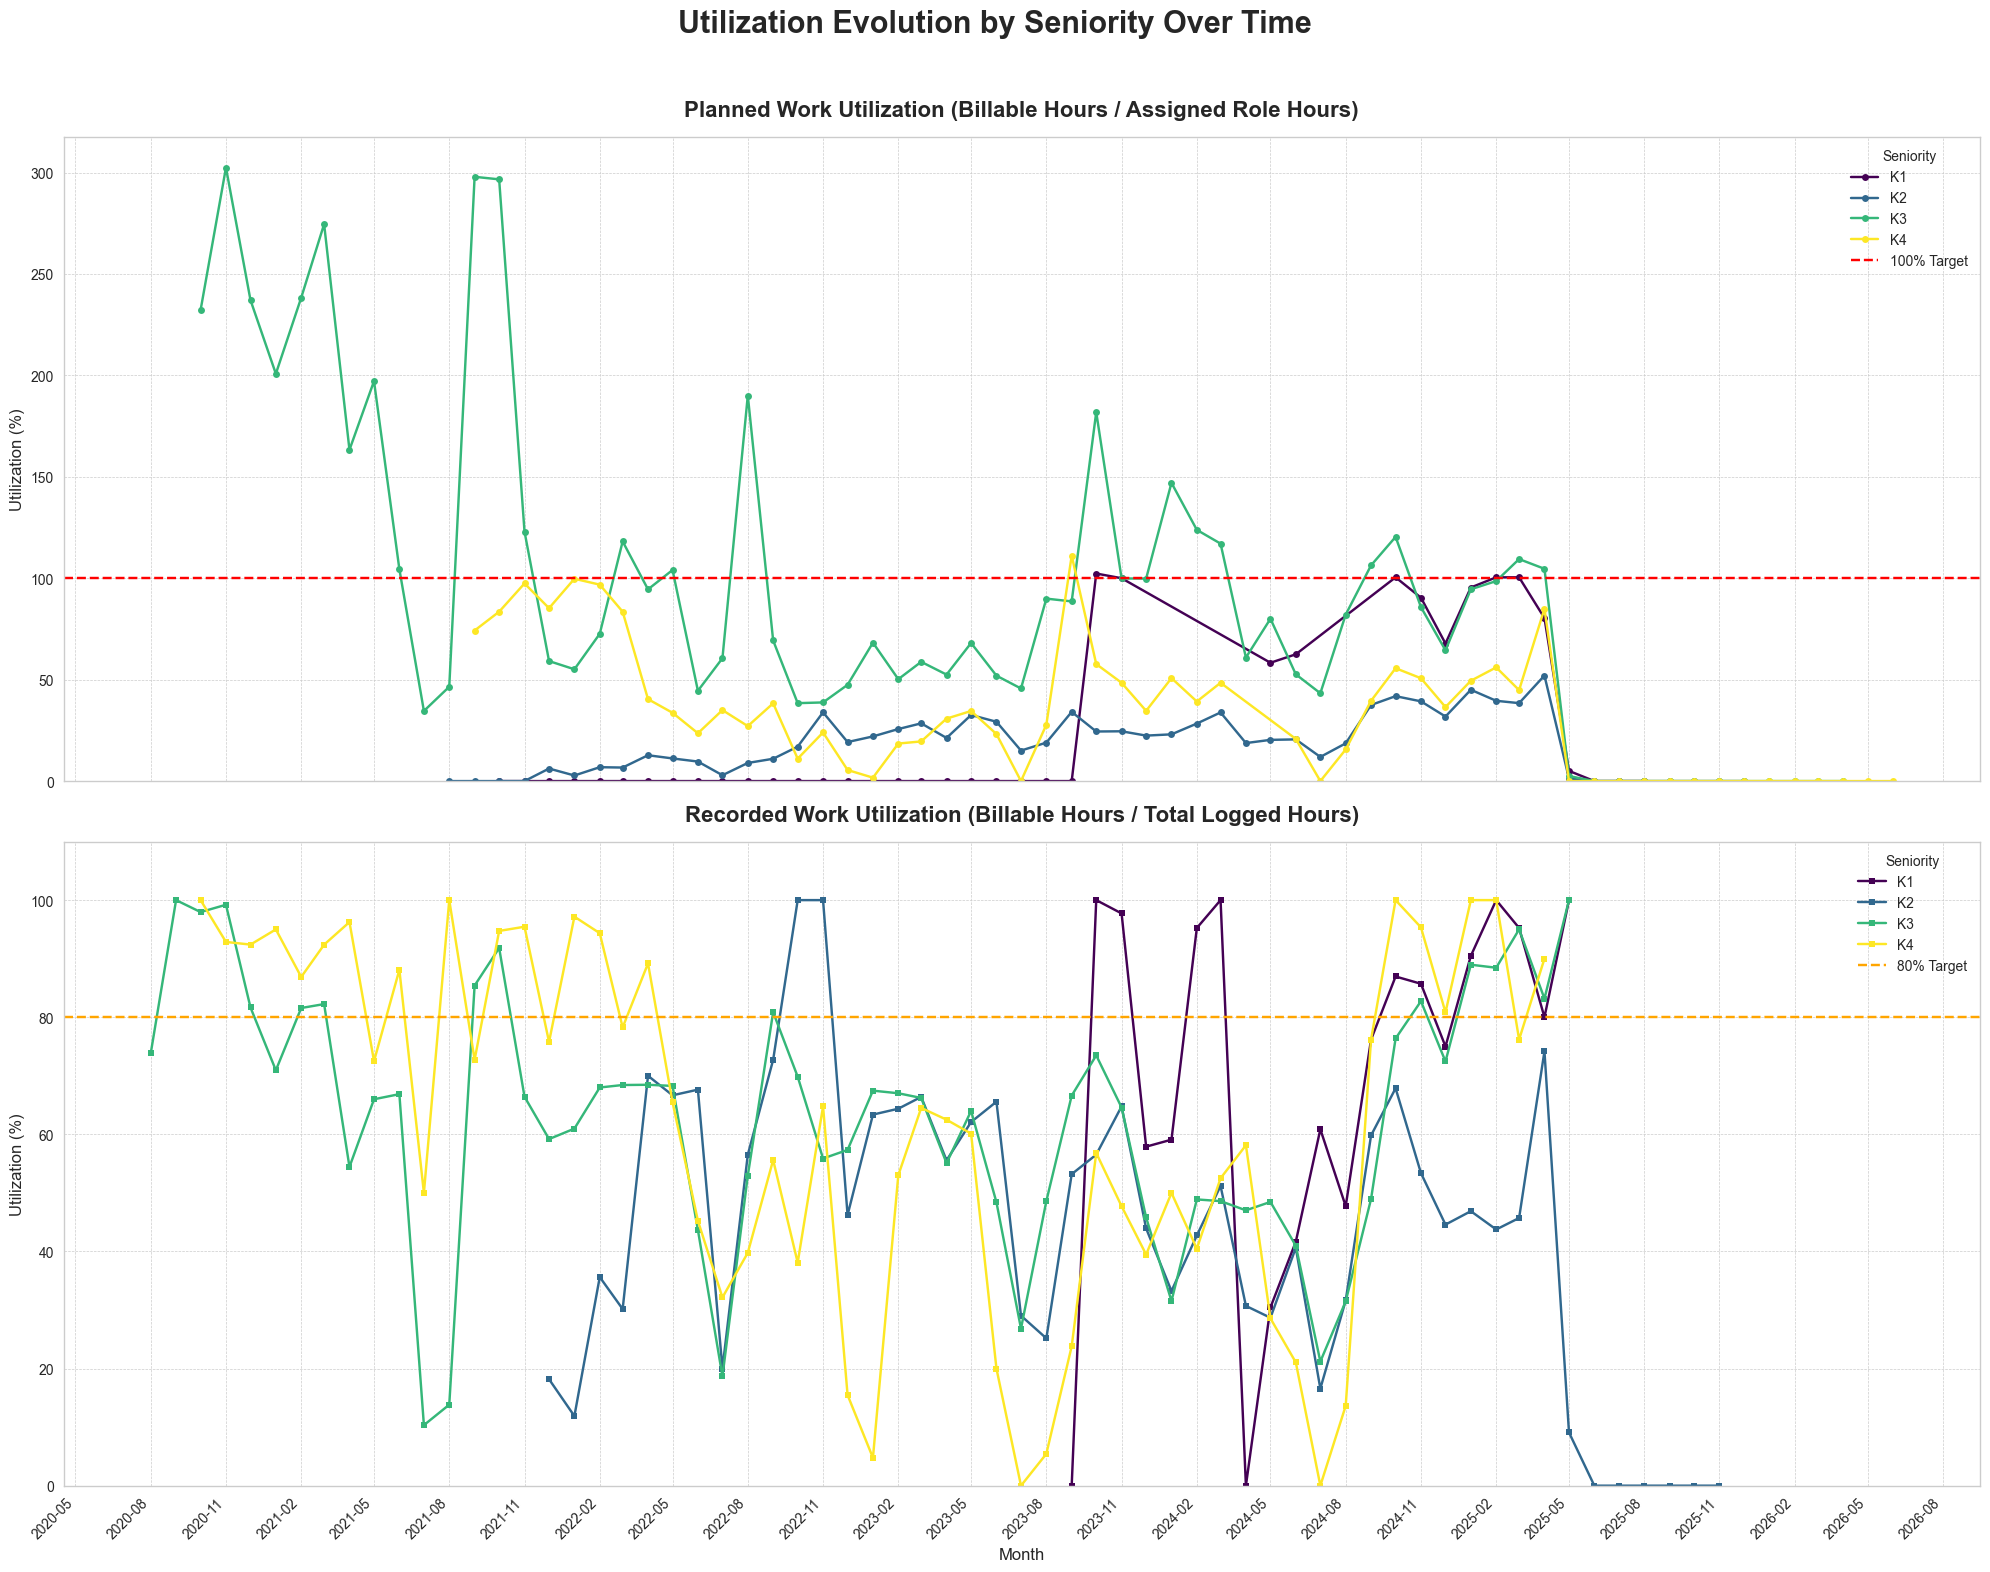

In [16]:
print("📈 UTILIZATION EVOLUTION BY SENIORITY TIMELINE")
# NOTE: This script assumes the previous cells have been run and the following
# DataFrames are available: df_time_entries_enriched, df_role_assignments_enriched, df_master_identity_map

print("="*80)

print("="*80)
print("This analysis shows the evolution of utilization metrics over time, broken down by seniority.\n")

# --- 1. Data Preparation for Timeline ---
print("[1] Preparing monthly data for timeline analysis...")

# Ensure 'seniority' is in df_time_entries_enriched
if 'seniority' not in df_time_entries_enriched.columns:
    df_time_entries_enriched = pd.merge(
        df_time_entries_enriched.drop(columns=['seniority'], errors='ignore'),
        df_master_identity_map[['master_person_id', 'seniority']],
        on='master_person_id',
        how='left'
    )
    print("✓ Added 'seniority' to time entries.")

# Create a 'month' column for time entries
df_time_entries_enriched['month'] = pd.to_datetime(df_time_entries_enriched['dt']).dt.to_period('M').dt.to_timestamp()

# --- 2. Calculate Monthly Recorded Work Utilization ---
print("[2] Calculating monthly 'Recorded Work Utilization' by seniority...")

# Aggregate billable and total hours by month and seniority
monthly_logged_hours = df_time_entries_enriched.groupby(['month', 'seniority']).agg(
    total_billable_hours_logged=('hours', lambda x: x[df_time_entries_enriched.loc[x.index, 'billable']].sum()),
    total_hours_logged=('hours', 'sum')
).reset_index()

# Calculate the utilization metric
monthly_logged_hours['logged_based_utilization'] = np.where(
    monthly_logged_hours['total_hours_logged'] > 0,
    (monthly_logged_hours['total_billable_hours_logged'] / monthly_logged_hours['total_hours_logged']) * 100,
    0
)
print("✓ 'Recorded Work Utilization' calculated.\n")


# --- 3. Calculate Monthly Planned Work Utilization ---
print("[3] Calculating monthly 'Planned Work Utilization' by seniority...")

# Ensure 'seniority' is in df_role_assignments_enriched
if 'seniority' not in df_role_assignments_enriched.columns:
    df_role_assignments_enriched = pd.merge(
        df_role_assignments_enriched,
        df_master_identity_map[['master_person_id', 'seniority']],
        left_on='assigned_to_person',
        right_on='master_person_id',
        how='left'
    )
    print("✓ Added 'seniority' to role assignments.")

# Distribute role hours across the months they are active
role_monthly_dist = []
for _, role in df_role_assignments_enriched.iterrows():
    if pd.isna(role['startdate']) or pd.isna(role['enddate']) or role['startdate'] > role['enddate']:
        continue
    
    months_active = pd.date_range(
        start=role['startdate'].to_period('M').to_timestamp(),
        end=role['enddate'].to_period('M').to_timestamp(),
        freq='MS'
    )
    
    if len(months_active) > 0:
        hours_per_month = role['required_hours_x'] / len(months_active)
        for month in months_active:
            role_monthly_dist.append({
                'month': month,
                'seniority': role['seniority'],
                'monthly_role_hours': hours_per_month
            })

df_role_monthly = pd.DataFrame(role_monthly_dist)
monthly_role_hours = df_role_monthly.groupby(['month', 'seniority'])['monthly_role_hours'].sum().reset_index()

# Merge with billable hours to calculate utilization
monthly_planned_util = pd.merge(
    monthly_role_hours,
    monthly_logged_hours[['month', 'seniority', 'total_billable_hours_logged']],
    on=['month', 'seniority'],
    how='left'
).fillna(0)

monthly_planned_util['role_based_utilization'] = np.where(
    monthly_planned_util['monthly_role_hours'] > 0,
    (monthly_planned_util['total_billable_hours_logged'] / monthly_planned_util['monthly_role_hours']) * 100,
    0
)
print("✓ 'Planned Work Utilization' calculated.\n")


# --- 4. Visualization ---
print("[4] Generating timeline visualizations...")

seniority_levels = sorted(df_master_identity_map['seniority'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(seniority_levels)))
seniority_colors = dict(zip(seniority_levels, colors))

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(20, 16), sharex=True)
fig.suptitle('Utilization Evolution by Seniority Over Time', fontsize=22, fontweight='bold')

# --- Chart 1: Planned Work Utilization Timeline ---
ax1 = axes[0]
for seniority_level in seniority_levels:
    subset = monthly_planned_util[monthly_planned_util['seniority'] == seniority_level].sort_values('month')
    if not subset.empty:
        ax1.plot(subset['month'], subset['role_based_utilization'], 
                 label=seniority_level, color=seniority_colors[seniority_level], 
                 marker='o', linestyle='-', markersize=5)

ax1.set_title('Planned Work Utilization (Billable Hours / Assigned Role Hours)', fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('Utilization (%)', fontsize=12)
ax1.axhline(100, color='red', linestyle='--', label='100% Target')
ax1.legend(title='Seniority', fontsize=10)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_ylim(bottom=0)

# --- Chart 2: Recorded Work Utilization Timeline ---
ax2 = axes[1]
for seniority_level in seniority_levels:
    subset = monthly_logged_hours[monthly_logged_hours['seniority'] == seniority_level].sort_values('month')
    if not subset.empty:
        ax2.plot(subset['month'], subset['logged_based_utilization'], 
                 label=seniority_level, color=seniority_colors[seniority_level], 
                 marker='s', linestyle='-', markersize=5)

ax2.set_title('Recorded Work Utilization (Billable Hours / Total Logged Hours)', fontsize=16, fontweight='bold', pad=15)
ax2.set_ylabel('Utilization (%)', fontsize=12)
ax2.set_xlabel('Month', fontsize=12)
ax2.axhline(80, color='orange', linestyle='--', label='80% Target')
ax2.legend(title='Seniority', fontsize=10)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.set_ylim(0, 110)

# Formatting x-axis
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

📈 ANALYSIS: ROLE SENIORITY DEMAND vs. PERSON SENIORITY SUPPLY
This analysis compares the seniority level required by roles against the seniority
of the people who actually logged the hours, on a monthly basis.

[1] Preparing monthly data...
✓ Calculated monthly planned work demand by ROLE seniority.
✓ Calculated monthly recorded work supply by PERSON seniority.

[2] Generating comparison charts...


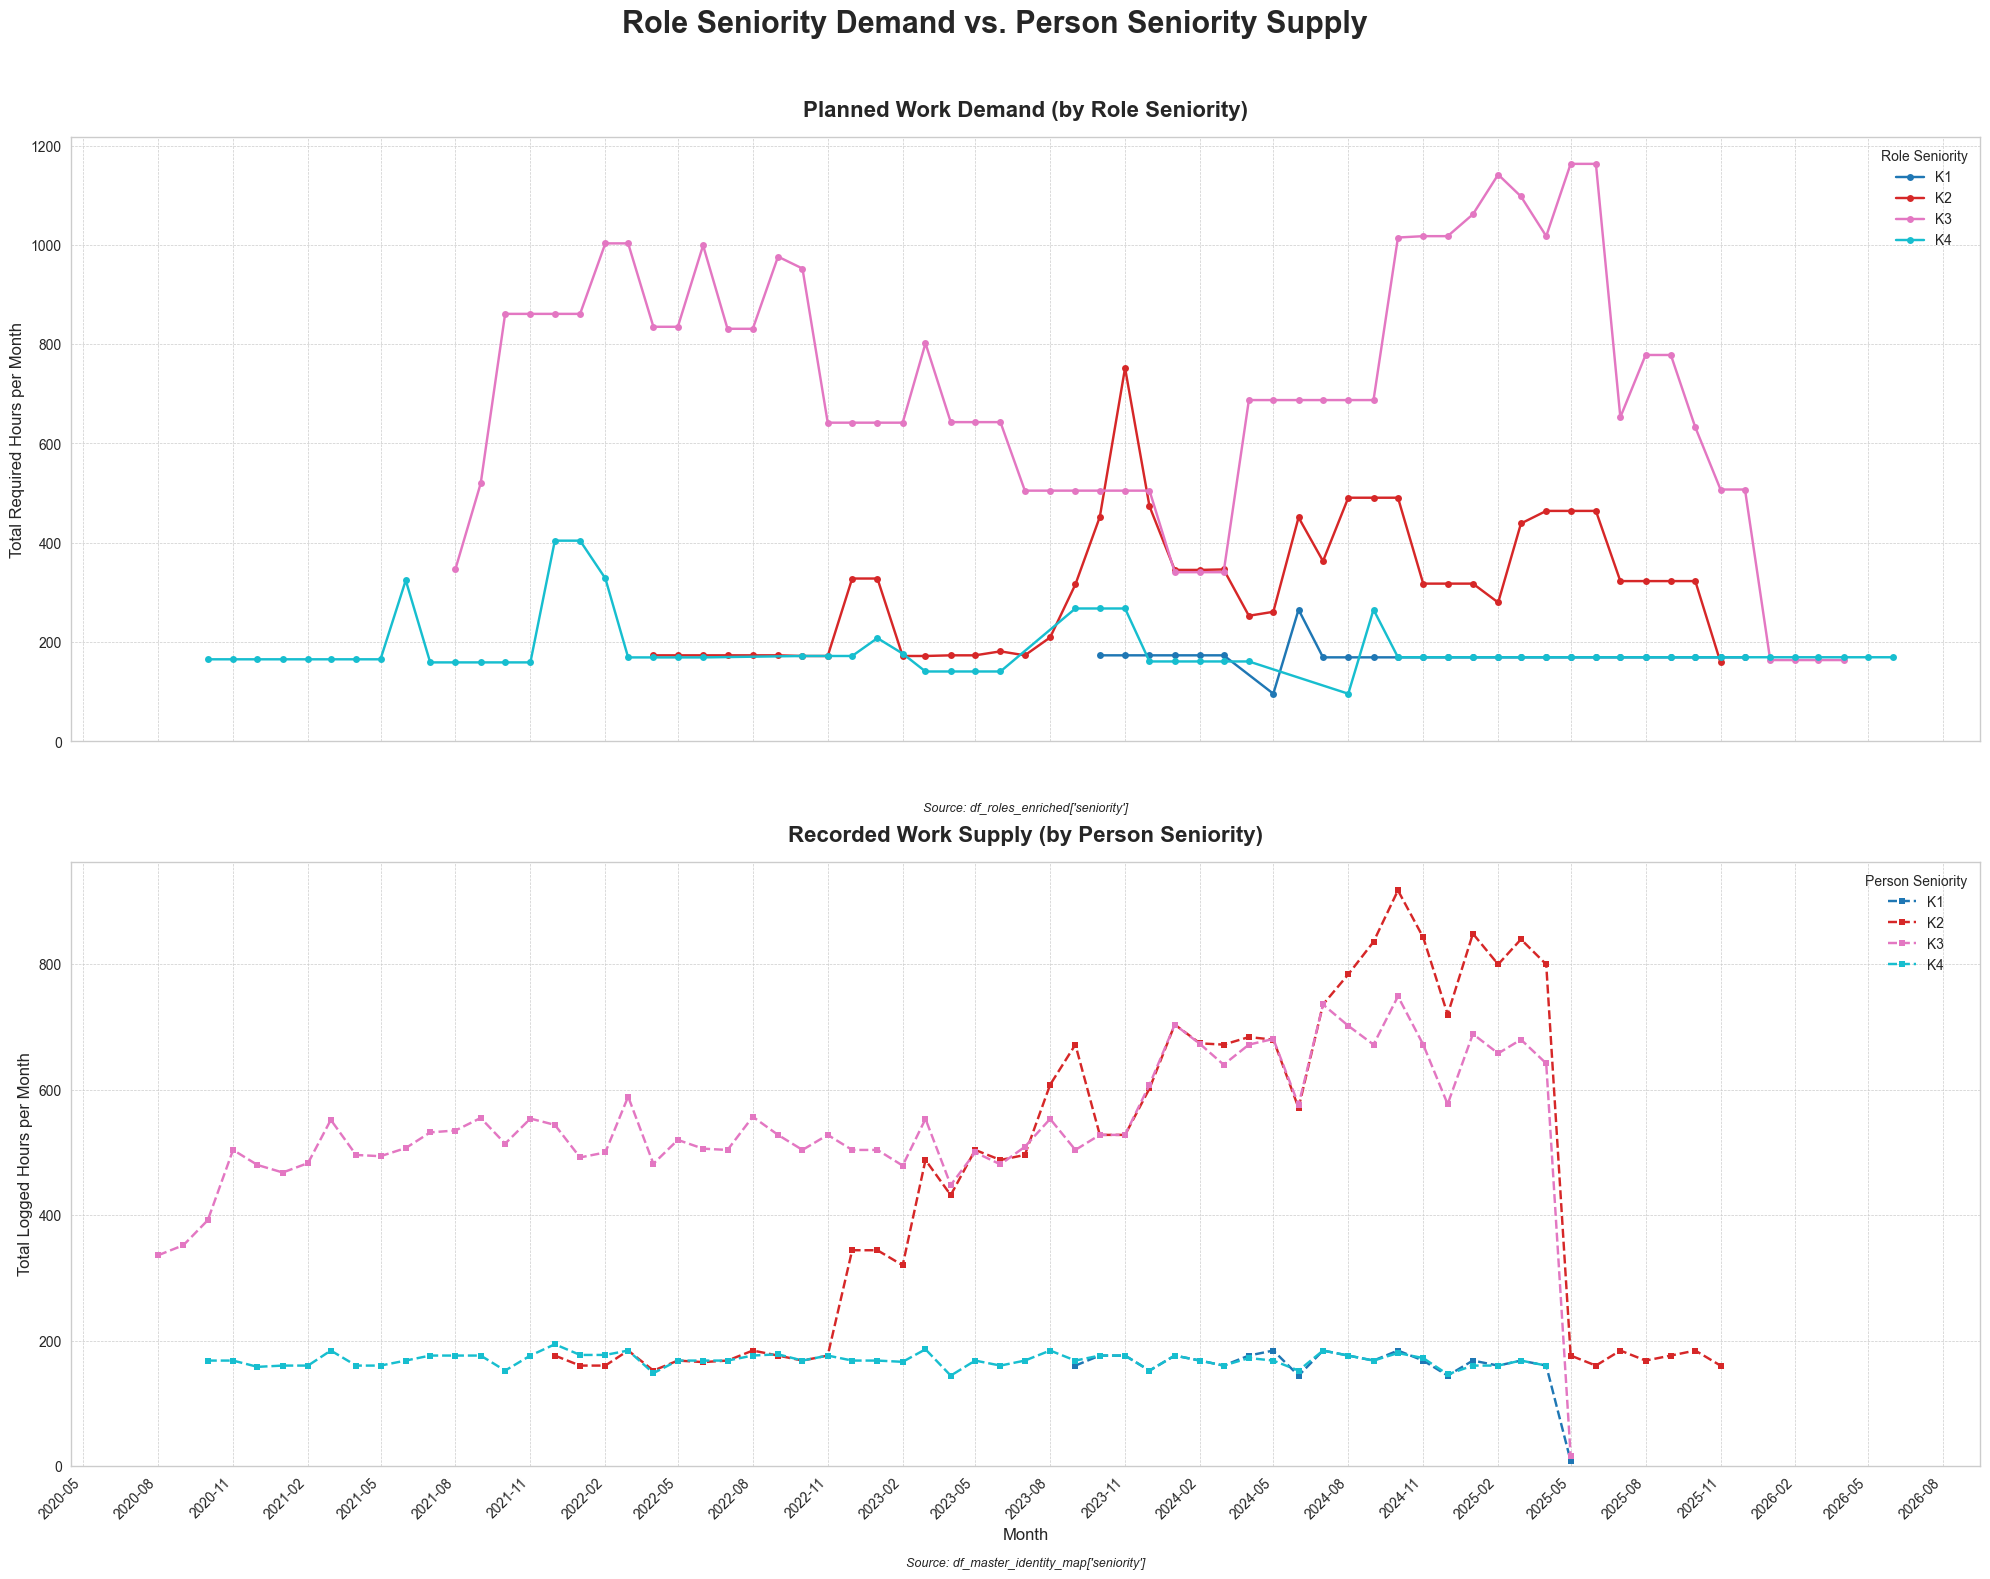

📈 ANALYSIS: ROLE SENIORITY DEMAND vs. PERSON SENIORITY SUPPLY
This analysis compares the seniority level required by roles against the seniority
of the people who actually logged the hours, on a monthly basis.



In [20]:
print("="*80)
print("📈 ANALYSIS: ROLE SENIORITY DEMAND vs. PERSON SENIORITY SUPPLY")
print("="*80)
print("This analysis compares the seniority level required by roles against the seniority\n"
      "of the people who actually logged the hours, on a monthly basis.\n")

# --- 1. Data Preparation ---
print("[1] Preparing monthly data...")

# A. Calculate PLANNED work demand by ROLE seniority
# This uses the seniority defined in the role itself.
df_roles_with_seniority = df_roles_enriched.copy()
role_demand_monthly = []

for _, role in df_roles_with_seniority.iterrows():
    if pd.isna(role['startdate']) or pd.isna(role['enddate']) or role['startdate'] > role['enddate']:
        continue
    
    months_active = pd.date_range(
        start=role['startdate'].to_period('M').to_timestamp(),
        end=role['enddate'].to_period('M').to_timestamp(),
        freq='MS'
    )
    
    if len(months_active) > 0:
        hours_per_month = role['required_hours'] / len(months_active)
        for month in months_active:
            role_demand_monthly.append({
                'month': month,
                'role_seniority': role['seniority'], # Seniority from the role
                'planned_demand_hours': hours_per_month
            })

df_role_demand = pd.DataFrame(role_demand_monthly)
df_role_demand_agg = df_role_demand.groupby(['month', 'role_seniority'])['planned_demand_hours'].sum().reset_index()
print("✓ Calculated monthly planned work demand by ROLE seniority.")

# B. Calculate RECORDED work supply by PERSON seniority
# This uses the seniority of the person logging the time.
df_person_supply = df_time_entries_enriched.copy()
if 'seniority' not in df_person_supply.columns:
    df_person_supply = pd.merge(
        df_person_supply,
        df_master_identity_map[['master_person_id', 'seniority']],
        on='master_person_id',
        how='left'
    )
df_person_supply['month'] = pd.to_datetime(df_person_supply['dt']).dt.to_period('M').dt.to_timestamp()

df_person_supply_agg = df_person_supply.groupby(['month', 'seniority']).agg(
    recorded_supply_hours=('hours', 'sum')
).reset_index().rename(columns={'seniority': 'person_seniority'})
print("✓ Calculated monthly recorded work supply by PERSON seniority.\n")


# --- 2. Visualization ---
print("[2] Generating comparison charts...")

# Get all unique seniority levels from both sources for consistent coloring
all_seniorities = sorted(list(set(df_role_demand_agg['role_seniority'].unique()) | set(df_person_supply_agg['person_seniority'].unique())))
colors = plt.cm.tab10(np.linspace(0, 1, len(all_seniorities)))
seniority_colors = dict(zip(all_seniorities, colors))

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(20, 16), sharex=True)
fig.suptitle('Role Seniority Demand vs. Person Seniority Supply', fontsize=22, fontweight='bold')

# --- Chart 1: Planned Demand by Role Seniority ---
ax1 = axes[0]
for seniority_level in all_seniorities:
    subset = df_role_demand_agg[df_role_demand_agg['role_seniority'] == seniority_level].sort_values('month')
    if not subset.empty:
        ax1.plot(subset['month'], subset['planned_demand_hours'], 
                 label=seniority_level, color=seniority_colors.get(seniority_level), 
                 marker='o', linestyle='-', markersize=5)

ax1.set_title('Planned Work Demand (by Role Seniority)', fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('Total Required Hours per Month', fontsize=12)
ax1.legend(title='Role Seniority', fontsize=10)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_ylim(bottom=0)
ax1.text(0.5, -0.1, "Source: df_roles_enriched['seniority']", ha='center', va='top', transform=ax1.transAxes, fontsize=9, style='italic')


# --- Chart 2: Recorded Supply by Person Seniority ---
ax2 = axes[1]
for seniority_level in all_seniorities:
    subset = df_person_supply_agg[df_person_supply_agg['person_seniority'] == seniority_level].sort_values('month')
    if not subset.empty:
        ax2.plot(subset['month'], subset['recorded_supply_hours'], 
                 label=seniority_level, color=seniority_colors.get(seniority_level), 
                 marker='s', linestyle='--', markersize=5)

ax2.set_title('Recorded Work Supply (by Person Seniority)', fontsize=16, fontweight='bold', pad=15)
ax2.set_ylabel('Total Logged Hours per Month', fontsize=12)
ax2.set_xlabel('Month', fontsize=12)
ax2.legend(title='Person Seniority', fontsize=10)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.set_ylim(bottom=0)
ax2.text(0.5, -0.15, "Source: df_master_identity_map['seniority']", ha='center', va='top', transform=ax2.transAxes, fontsize=9, style='italic')


# Formatting x-axis
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
# filepath: c:\Users\guine\Documents\BC#4\Hyper_python\BI project\Data-Edge-BI-analysis\Data-Edge-BI-analysis\notebooks\Matching_clients_projects.ipynb
print("="*80)
print("📈 ANALYSIS: ROLE SENIORITY DEMAND vs. PERSON SENIORITY SUPPLY")
print("="*80)
print("This analysis compares the seniority level required by roles against the seniority\n"
      "of the people who actually logged the hours, on a monthly basis.\n")

